# API

In [95]:
import matplotlib.pyplot as plt
import time
import pickle
import scipy.stats
from scipy import interpolate
from copy import copy
# %load_ext line_profiler

In [96]:
plt.rcParams['text.usetex']=True
plt.rcParams['font.family']='serif'
plt.rcParams['font.size']=9
plt.rcParams['axes.titlesize']=plt.rcParams['font.size']
plt.rcParams['figure.figsize']=(6.8,4)

In [4]:
# ipcluster start --engines=MPI
import ipyparallel as ipp
rc = ipp.Client()
rc[:].execute("from Majorana_chain import *")
rc[:].execute("import numpy as np")

<AsyncResult: execute>

In [97]:
# %%writefile Majorana_chain.py
import numpy as np
import scipy.linalg as la
import numpy.linalg as nla
import numpy.matlib
import itertools

class Params:
    '''
    example: params=Params(delta=2)
    '''
    def __init__(self,
    delta=0,    
    L=100,
    T=0,
    dmax=100,
    bc=-1,    # 0: open boundary condition; +1: PBC; -1: APBC
    basis='f',    # 'generate Hamiltonian of fermionic ('f') and Majorana basis ('m') or both ('mf')
    dE=None,
    E0=None,
    kappa=0.5,
    history=True
    ):
        self.delta=delta
        self.mu=2*(1-delta)
        self.t=-(1+delta)
        self.Delta=-(1+delta)
        self.L=L
        self.tau_z=np.array([[1,0],[0,-1]])
        self.tau_y=np.array([[0,-1j],[1j,0]])
        self.bc=bc
        self.T=T
        self.dE=dE
        self.E0=E0
        self.kappa=kappa
        self.history=history

        if L<np.inf:
            if 'f' in basis:
                band1sm=np.diag(np.ones(L-1),1)
                band1sm[-1,0]=bc
                id_mat=np.eye(L)
                # Hamiltonian in the ferimion basis
                # self.Hamiltonian_f=np.block([[-self.mu*id_mat-self.t*(band1sm+band1sm.T),-self.Delta*(band1sm-band1sm.T)],
                # [self.Delta*(band1sm-band1sm.T),self.mu*id_mat+self.t*(band1sm+band1sm.T)]])
                # BdG Hamiltonian back to original        
                # self.Hamiltonian_f/=2
                A=-(1-delta)*id_mat+(1+delta)/2*(band1sm+band1sm.T)
                B=-(1+delta)/2*(band1sm.T-band1sm)
                self.Hamiltonian_f=np.block([[A,B],[-B,-A]])

            if 'm' in basis:    
                # Hamiltonian in the Majorana basis
                band=np.vstack([np.ones(L)*(1-delta)*1j,np.ones(L)*(1+delta)*1j]).flatten('F')
                Ham=np.diag(band[:-1],-1)
                Ham[0,-1]=(1+delta)*1j*bc
                Ham=Ham+Ham.conj().T
                self.Hamiltonian_m=Ham
        else:
            self.dmax=dmax

    def bandstructure(self,basis='mf'):
        if 'f' in basis:    
            val,vec=nla.eigh(self.Hamiltonian_f)
            sortindex=np.argsort(val)
            self.val_f=val[sortindex]
            self.vec_f=vec[:,sortindex]
        if 'm' in basis:
            val,vec=nla.eigh(self.Hamiltonian_m) 
            sortindex=np.argsort(val)
            self.val_m=val[sortindex]
            self.vec_m=vec[:,sortindex]    
    
    def E_k(self,k,branch):
        return branch*np.sqrt(2+2*self.delta**2-2*(1-self.delta**2)*np.cos(k))

    def fermi_dist_k(self,k,branch,E_F=0):
        if self.T==0:
            # return np.heaviside(E_F-self.E_k(k,branch),0)
            if branch==1:
                return 0*k
            if branch==-1:
                return 1-0*k
            ValueError('branch (%d) not defined'.format(branch))
        else:
            return 1/(1+np.exp((self.E_k(k,branch)-E_F)/self.T))

    def fermi_dist(self,energy,E_F):      
        if self.T==0:
            return np.heaviside(E_F-energy,0)
        elif self.T<np.inf:
            return 1/(1+np.exp((energy-E_F)/self.T))
        else:

            assert self.dE is not None, 'dE is unspecified when T is inf'
            k=int(len(energy)*self.kappa)
            if self.L%2==0:
                index0=np.arange(0,self.L*2,2)
            else:
                index0=np.arange(1,self.L*2,2)
            index=np.random.choice(index0,k//2,replace=False)
            index=np.hstack((index,(index+1)%(2*self.L)))
            E_mean=np.sum(energy[index])/self.L
            while np.abs(E_mean-self.E0)>self.dE:
                if self.L%2==0:
                    index0=np.arange(0,self.L*2,2)
                else:
                    index0=np.arange(1,self.L*2,2)
                index=np.random.choice(index0,k//2,replace=False)
                index=np.hstack((index,(index+1)%(2*self.L)))
                E_mean=np.sum(energy[index])/self.L
                # print(Esum)
            filt=np.zeros(len(energy),dtype=int)
            filt[index]=1
            self.filt=filt
            self.index=index
            self.E_mean=E_mean
            return filt


    def correlation_matrix(self,E_F=0):
        '''
        ??? may be wrong by a transpose
        G_{ij}=[[<f_i f_j^\dagger>,<f_i f_j>],
                [<f_i^\dagger f_j^\dagger>,<f_i^\dagger f_j>]]
        '''
        if not (hasattr(self,'val_f') and hasattr(self,'vec_f')):
            self.bandstructure('f')
        occupancy=self.fermi_dist(self.val_f,E_F)
        occupancy_mat=np.matlib.repmat(occupancy,self.vec_f.shape[0],1)
        # print('Max of imag {:.2f}'.format(np.abs((occupancy_mat*self.vec_f)@self.vec_f.T.conj()).max()))
        self.C_f=((occupancy_mat*self.vec_f)@self.vec_f.T.conj())

    def correlation_matrix_inf_fft(self,threshold=1024):
        '''
        self.dmax: the maximal distance (in terms of unit cell) 
        Directly call fft to evaluate the integral
        '''
        assert self.L==np.inf, "Wire length should be inf"
        d=max(2*self.dmax,threshold)
        k_list=np.arange(0,2*np.pi,2*np.pi/d)
        fermi_dist_k_p=self.fermi_dist_k(np.arange(0,2*np.pi,2*np.pi/d),1)
        fermi_dist_k_m=self.fermi_dist_k(np.arange(0,2*np.pi,2*np.pi/d),-1)

        costheta=1/2*(-self.mu-2*np.cos(k_list)*self.t)/(self.E_k(k_list,1)+1e-18)
        sintheta=-1/2*(2*self.Delta*np.sin(k_list))/(self.E_k(k_list,1)+1e-18)
        integrand_11=fermi_dist_k_m*(1-costheta)/2+fermi_dist_k_p*(1+costheta)/2
        integrand_22=fermi_dist_k_m*(1+costheta)/2+fermi_dist_k_p*(1-costheta)/2
        integrand_12=fermi_dist_k_m*(1j/2)*sintheta+fermi_dist_k_p*(-1j/2)*sintheta
        integrand_21=fermi_dist_k_m*(-1j/2)*sintheta+fermi_dist_k_p*(1j/2)*sintheta

        A_11=np.fft.ifftshift(np.fft.ifft(integrand_11))
        A_22=np.fft.ifftshift(np.fft.ifft(integrand_22))
        A_12=np.fft.ifftshift(np.fft.ifft(integrand_12))
        A_21=np.fft.ifftshift(np.fft.ifft(integrand_21))

        C_f_11=np.zeros((self.dmax,self.dmax),dtype=complex)
        C_f_22=np.zeros((self.dmax,self.dmax),dtype=complex)
        C_f_12=np.zeros((self.dmax,self.dmax),dtype=complex)
        C_f_21=np.zeros((self.dmax,self.dmax),dtype=complex)
        for i in range(self.dmax):
            C_f_11[i]=A_11[d//2-i:d//2+self.dmax-i]
            C_f_22[i]=A_22[d//2-i:d//2+self.dmax-i]
            C_f_12[i]=A_12[d//2-i:d//2+self.dmax-i]
            C_f_21[i]=A_21[d//2-i:d//2+self.dmax-i]

        C_f=np.block([[C_f_11,C_f_12],[C_f_21,C_f_22]])
        C_f_err=np.imag(C_f).__abs__().max()
        assert C_f_err<1e-12, 'C_f not real; the max imag is {:e}'.format(C_f_err)
        self.C_f=np.real(C_f)


    def covariance_matrix_f(self,E_F=0):
        '''
        Gamma from fermionic basis
        Gamma_ij=i<gamma_i gamma_j>/2
        '''
        if not (hasattr(self,'C_f')):
            if self.L<np.inf:
                self.correlation_matrix(E_F)
            else:
                self.correlation_matrix_inf_fft()

        # G=self.C_f[self.L:,self.L:]
        # F=self.C_f[self.L:,:self.L]
        if self.L<np.inf:
            G=self.C_f[:self.L,:self.L]
            # F=self.C_f[:self.L,self.L:]
            F=self.C_f[self.L:,:self.L]
        else:
            G=self.C_f[:self.dmax,:self.dmax]
            F=self.C_f[self.dmax:,:self.dmax]

        self.G=G
        self.F=F
        A11=1j*(F.T.conj()+F+G-G.T)
        A22=-1j*(F.T.conj()+F-G+G.T)
        A21=-(np.eye(F.shape[0])+F.T.conj()-F-G-G.T)
        A12=-A21.T
        if self.L<np.inf:
            A=np.zeros((2*self.L,2*self.L),dtype=complex)
        else:
            A=np.zeros((2*self.dmax,2*self.dmax),dtype=complex)
        # even=np.arange(2*self.L)[::2]
        # odd=np.arange(2*self.L)[1::2]
        # A[np.ix_(even,even)]=A11
        # A[np.ix_(even,odd)]=A12
        # A[np.ix_(odd,even)]=A21
        # A[np.ix_(odd,odd)]=A22
        A[::2,::2]=A11
        A[::2,1::2]=A12
        A[1::2,::2]=A21
        A[1::2,1::2]=A22

        assert np.abs(np.imag(A)).max()<1e-10, "Covariance matrix not real"
        self.C_m=A
        self.C_m=np.real(A-A.T.conj())/2   
        self.C_m_history=[self.C_m]    

    def covariance_matrix_m(self,E_F=0):
        '''
        Gamma from Majorana basis
        '''
        if not (hasattr(self,'val_m') and hasattr(self,'vec_m')):
            self.bandstructure('m')
        occupancy=self.fermi_dist(self.val_m,E_F)
        occupancy_mat=np.matlib.repmat(occupancy,self.vec_m.shape[0],1)
        self.C_m=(1j*2*(occupancy_mat*self.vec_m)@self.vec_m.T.conj())-1j*np.eye(self.L*2)
        assert np.abs(np.imag(self.C_m)).max()<1e-10, "Covariance matrix not real"        
        self.C_m=np.real(self.C_m-self.C_m.T.conj())/2
        self.C_m_history=[self.C_m]
    
    def projection(self,s):
        '''
        occupancy number: s= 0,1 
        (-1)^0 even parity, (-1)^1 odd parity

        '''
        assert (s==0 or s==1),"s={} is either 0 or 1".format(s)
        blkmat=np.array([[0,-(-1)**s,0,0],
                        [(-1)**s,0,0,0],
                        [0,0,0,(-1)**s],
                        [0,0,-(-1)**s,0]])
        return blkmat


    def measure(self,s,ix):
        if not hasattr(self,'C_m'):
            self.covariance_matrix_f()
        if not hasattr(self,'s_history'):
            self.s_history=[]
        if not hasattr(self,'i_history'):
            self.i_history=[]
                
        m=self.C_m_history[-1].copy()

        for i_ind,i in enumerate(ix):
            m[[i,-(len(ix)-i_ind)]]=m[[-(len(ix)-i_ind),i]]
            m[:,[i,-(len(ix)-i_ind)]]=m[:,[-(len(ix)-i_ind),i]]

        self.m=m

        Gamma_LL=m[:-len(ix),:-len(ix)]
        Gamma_LR=m[:-len(ix),-len(ix):]
        Gamma_RR=m[-len(ix):,-len(ix):]       

        proj=self.projection(s)
        Upsilon_LL=proj[:-len(ix),:-len(ix)]
        Upsilon_RR=proj[-len(ix):,-len(ix):]
        Upsilon_RL=proj[-len(ix):,:-len(ix)]
        zero=np.zeros((m.shape[0]-len(ix),len(ix)))
        zero0=np.zeros((len(ix),len(ix)))
        mat1=np.block([[Gamma_LL,zero],[zero.T,Upsilon_RR]])
        mat2=np.block([[Gamma_LR,zero],[zero0,Upsilon_RL]])
        mat3=np.block([[Gamma_RR,np.eye(len(ix))],[-np.eye(len(ix)),Upsilon_LL]])
        self.mat2=mat2
        if np.count_nonzero(mat2):
            Psi=mat1+mat2@(la.solve(mat3,mat2.T))
            # Psi=mat1+mat2@(la.lstsq(mat3,mat2.T)[0])
            assert np.abs(np.trace(Psi))<1e-5, "Not trace zero {:e}".format(np.trace(Psi))
        else:
            Psi=mat1
        
        for i_ind,i in enumerate(ix):
            Psi[[i,-(len(ix)-i_ind)]]=Psi[[-(len(ix)-i_ind),i]]
            Psi[:,[i,-(len(ix)-i_ind)]]=Psi[:,[-(len(ix)-i_ind),i]]
        
        Psi=(Psi-Psi.T)/2   # Anti-symmetrize
        if self.history:
            self.C_m_history.append(Psi)
            self.s_history.append(s)
            self.i_history.append(i)
        else:
            self.C_m_history=[Psi]
            self.s_history=[s]
            self.i_history=[i]

    def c_subregion_f(self,subregion):
        if not hasattr(self,'C'):
            self.correlation_matrix()
        try:
            subregion=np.array(subregion)
        except:
            raise ValueError("The subregion is ill-defined"+subregion)
        subregion_ph=np.concatenate([subregion,subregion+self.L])
        return self.C_f[np.ix_(subregion_ph,subregion_ph)]

    def von_Neumann_entropy_f(self,subregion):
        c_A=self.c_subregion_f(subregion)
        val=nla.eigvalsh(c_A)
        self.val_sh=val
        val=np.sort(val)[:subregion.shape[0]]
        return np.real(-np.sum(val*np.log(val+1e-18j))-np.sum((1-val)*np.log(1-val+1e-18j)))

    def linearize_index(self,subregion,n,k=2,proj=False):
        try:
            subregion=np.array(subregion)
        except:
            raise ValueError("The subregion is ill-defined"+subregion)
        if proj:
            return sorted(np.concatenate([n*subregion+i for i in range(0,n,k)]))
        else:
            return sorted(np.concatenate([n*subregion+i for i in range(n)]))

    def c_subregion_m(self,subregion,Gamma=None):
        if not hasattr(self,'C_m'):
            self.covariance_matrix_f()
        if Gamma is None:
            Gamma=self.C_m_history[-1]
        subregion=self.linearize_index(subregion,2)
        return Gamma[np.ix_(subregion,subregion)]
        
    def von_Neumann_entropy_m(self,subregion):
        c_A=self.c_subregion_m(subregion)
        val=nla.eigvalsh(1j*c_A)
        self.val_sh=val
        val=np.sort(val)
        val=(1-val)/2+1e-18j   #\lambda=(1-\xi)/2
        
        return np.real(-np.sum(val*np.log(val))-np.sum((1-val)*np.log(1-val)))/2

    def mutual_information_f(self,subregion_A,subregion_B):
        s_A=self.von_Neumann_entropy_f(subregion_A)
        s_B=self.von_Neumann_entropy_f(subregion_B)
        assert np.intersect1d(subregion_A,subregion_B).size==0 , "Subregion A and B overlap"
        subregion_AB=np.concatenate([subregion_A,subregion_B])
        s_AB=self.von_Neumann_entropy_f(subregion_AB)
        return s_A+s_B-s_AB

    def mutual_information_m(self,subregion_A,subregion_B):
        assert np.intersect1d(subregion_A,subregion_B).size==0 , "Subregion A and B overlap"
        s_A=self.von_Neumann_entropy_m(subregion_A)
        s_B=self.von_Neumann_entropy_m(subregion_B)
        subregion_AB=np.concatenate([subregion_A,subregion_B])
        s_AB=self.von_Neumann_entropy_m(subregion_AB)
        return s_A+s_B-s_AB

    def measure_batch(self,batchsize,proj_range):
        for _ in range(batchsize):
            i=np.random.randint(*proj_range)
            s=np.random.randint(0,2)
            self.measure(s,[i,i+1])
        return self

    def measure_all(self,s_prob,proj_range=None):
        '''
        The probability of s=0 (unoccupied)
        '''
        if proj_range is None:
            proj_range=np.arange(self.L//4,self.L//2)
        proj_range=self.linearize_index(proj_range,2,proj=True,k=2)
        for i in proj_range:
            if s_prob==0:
                s=1
            elif s_prob==1:
                s=0
            else:           
                s=s_prob<np.random.rand()
            self.measure(s,[i,i+1])
        return self
    
   

    def measure_all_Born(self,proj_range=None,order=None,prob=None):
        # proj_range should be in the format of fermionic sites
        if proj_range is None:
            proj_range=np.arange(self.L//4,self.L//2)
        if order=='e2':
            proj_range=np.concatenate((proj_range[::2],proj_range[1::2]))
        if order=='e3':
            proj_range=np.concatenate((proj_range[::3],proj_range[1::3],proj_range[2::3]))
        if order=='e4':
            proj_range=np.concatenate((proj_range[::4],proj_range[1::4],proj_range[2::4]+proj_range[3::4]))
        proj_range=self.linearize_index(proj_range,2,proj=True,k=2)
        # self.P_0_list=[]
        if not hasattr(self, 'C_m'):
            self.covariance_matrix_f()
        for index,i in enumerate(proj_range):
            if prob is None:
                P_0=(self.C_m_history[-1][i,i+1]+1)/2
                # self.P_0_list.append(P_0)
            else:
                if isinstance(prob,list):
                    assert len(prob)==len(proj_range), "len of prob {:d} not equal to len of proj_range {:d}".format(len(prob),len(proj_range))
                    P_0=prob[index]
                else:
                    P_0=prob
            if np.random.rand() < P_0:                
                self.measure(0,[i,i+1])
            else:
                self.measure(1,[i,i+1])
        return self


    def log_neg(self,subregionA,subregionB,Gamma=None):
        subregionA=self.linearize_index(subregionA,2)
        subregionB=self.linearize_index(subregionB,2)
        assert np.intersect1d(subregionA,subregionB).size==0 , "Subregion A and B overlap"
        if not hasattr(self,'C_m'):
            self.covariance_matrix_f()
        
        if Gamma is None:
            Gamma=self.C_m_history[-1]
        subregionA=np.array(subregionA)
        subregionB=np.array(subregionB)
        Gm_p= np.block([
            [-Gamma[np.ix_(subregionA,subregionA)],1j*Gamma[np.ix_(subregionA,subregionB)]],
            [1j*Gamma[np.ix_(subregionB,subregionA)],Gamma[np.ix_(subregionB,subregionB)]]
        ])
        Gm_n= np.block([
            [-Gamma[np.ix_(subregionA,subregionA)],-1j*Gamma[np.ix_(subregionA,subregionB)]],
            [-1j*Gamma[np.ix_(subregionB,subregionA)],Gamma[np.ix_(subregionB,subregionB)]]
        ])
        idm=np.eye(Gm_p.shape[0])
        # Gm_x=idm-(idm+1j*Gm_p)@nla.inv(idm-Gm_n@Gm_p)@(idm+1j*Gm_n)
        Gm_x=idm-(idm+1j*Gm_p)@(la.solve((idm-Gm_n@Gm_p),(idm+1j*Gm_n)))
        Gm_x=(Gm_x+Gm_x.T.conj())/2
        xi=nla.eigvalsh(Gm_x)
        subregionAB=np.concatenate([subregionA,subregionB])
        eA=np.sum(np.log(((1+xi+0j)/2)**0.5+((1-xi+0j)/2)**0.5))/2
        chi=nla.eigvalsh(1j*Gamma[np.ix_(subregionAB,subregionAB)])
        sA=np.sum(np.log(((1+chi)/2)**2+((1-chi)/2)**2))/4
        return np.real(eA+sA)

     
    
def cross_ratio(x,L):
    if L<np.inf:
        xx=lambda i,j: (np.sin(np.pi/(L)*np.abs(x[i]-x[j])))
    else:
        xx=lambda i,j: np.abs(x[i]-x[j])
    eta=(xx(0,1)*xx(2,3))/(xx(0,2)*xx(1,3))
    return eta

from scipy.interpolate import UnivariateSpline
def find_inflection(x,y):
    spl=UnivariateSpline(x,y,s=0)
    spld=spl.derivative()
    x_fit=np.linspace(x.min(),x.max(),500)
    y_fit=spl(x_fit)
    yd_fit=spld(x_fit)    
    x_max_index=np.argmax(np.abs(yd_fit))
    return x_fit[x_max_index],y_fit[x_max_index]

## Obsolete functions


In [ ]:

# def __init_obs__(self,
    # delta=0,    
    # L=100,
    # T=0,
    # bc=1    # 0: open boundary condition; >0: PBC; <0: APBC
    # ):
    #     self.delta=delta
    #     self.mu=2*(1-delta)
    #     self.t=-(1+delta)
    #     self.Delta=-(1+delta)
    #     self.L=L
    #     self.tau_z=sp.dia_matrix(np.diag([1,-1]))
    #     self.tau_y=sp.dia_matrix(np.array([[0,-1j],[1j,0]]))
    #     self.bc=bc
    #     self.T=T
    #     self.band1sm=sp.diags([1],[1],(L,L)).tocsr()
    #     self.bandm1sm=sp.diags([1],[-1],(L,L)).tocsr()
    #     self.band1sm[-1,0]=1*(2*np.heaviside(bc,1/2)-1)
    #     self.bandm1sm[0,-1]=1*(2*np.heaviside(bc,1/2)-1)
    #     # Hamiltonian in the ferimion basis
    #     self.Hamiltonian_f=-self.mu*sp.kron(self.tau_z,sp.identity(self.L))-sp.kron(self.t*self.tau_z+1j*self.Delta*self.tau_y,self.band1sm)-sp.kron(self.t*self.tau_z-1j*self.Delta*self.tau_y,self.bandm1sm)
    #     # BdG Hamiltonian back to original
        
    #     self.Hamiltonian_f/=2
    #     # Hamiltonian in the Majorana basis
    #     band=np.vstack([np.ones(L)*(1-delta)*1j,np.ones(L)*(1+delta)*1j]).flatten('F')
    #     Ham=sp.diags(np.array([band[:-1],band[:-1].conj()]),np.array([-1,1]),shape=(2*L,2*L)).tocsr()
    #     Ham[0,-1]=(1+delta)*1j*bc
    #     Ham[-1,0]=-(1+delta)*1j*bc
    #     self.Hamiltonian_m=Ham

    # def bandstructure_obs(self,H_type='f'):    
    #     if H_type=='f':    
    #         val,vec=la.eigh(self.Hamiltonian_f)
    #         sortindex=np.argsort(val)
    #         self.val_f=val[sortindex]
    #         self.vec_f=vec[:,sortindex]
    #     elif H_type=='m':
    #         val,vec=la.eigh(self.Hamiltonian_m) 
    #         sortindex=np.argsort(val)
    #         self.val_m=val[sortindex]
    #         self.vec_m=vec[:,sortindex]
    #     else:
    #         raise ValueError('type of Hamiltonian ({}) not found'.format(H_type))

    # def projection_obs(self,s):
    #     '''
    #     s= 0,1 occupancy number
    #     '''
    #     assert (s==0 or s==1),"s={} is either 0 or 1".format(s)
    #     blkmat=(np.array([[0,-(-1)**s],[(-1)**s,0]]))
    #     return sp.bmat([[blkmat,None],[None,blkmat.T]]).toarray()
    # Slower than measure() 8.3x times 
    # def measure_obs(self,s,i,j):
    #     permutation_mat=sp.diags([1],[0],(self.L*2,self.L*2)).tocsr()
    #     # i <-> -2
    #     permutation_mat[i,i]=0
    #     permutation_mat[-2,-2]=0
    #     permutation_mat[i,-2]=1
    #     permutation_mat[-2,i]=1
    #     # j <-> -1
    #     permutation_mat[j,j]=0
    #     permutation_mat[-1,-1]=0
    #     permutation_mat[j,-1]=1
    #     permutation_mat[-1,j]=1
    #     if not hasattr(self,'C_m'):
    #         self.covariance_matrix_m()

    #     # m=np.arange(64).reshape((8,8))
    #     # C_m_perm=permutation_mat.T@m@permutation_mat.T

    #     C_m_perm=permutation_mat.T@self.C_m_history[-1]@permutation_mat.T

    #     self.m=C_m_perm
    #     Gamma_LL=C_m_perm[:-2,:-2]
    #     Gamma_LR=C_m_perm[:-2,-2:]
    #     Gamma_RR=C_m_perm[-2:,-2:]

    #     proj=self.projection(s)
    #     Upsilon_LL=proj[:-2,:-2]
    #     Upsilon_LR=proj[:-2,-2:]
    #     Upsilon_RR=proj[-2:,-2:]
    #     Upsilon_RL=proj[-2:,:-2]
    #     zero=np.zeros((self.L*2-2,2))
    #     zero0=np.zeros((2,2))
    #     mat1=np.block([[Gamma_LL,zero],[zero.T,Upsilon_RR]])
    #     mat2=np.block([[Gamma_LR,zero],[zero0,Upsilon_RL]])
    #     mat3=np.block([[Gamma_RR,np.eye(2)],[-np.eye(2),Upsilon_LL]])
    #     self.mat2=mat2
    #     if np.count_nonzero(mat2):
    #         Psi=mat1+mat2@(la.solve(mat3,mat2.T))
    #     else:
    #         Psi=mat1
    #     Psi=permutation_mat.T@Psi@permutation_mat
        
        
    #     self.C_m_history.append(Psi)

    # Slower than measure() 1.7x times 
    # def measure_roll(self,s,i,j):
    #     if not hasattr(self,'C_m'):
    #         self.covariance_matrix_m()
        
    #     # m=np.arange(64).reshape((8,8))
        
    #     m=self.C_m_history[-1].copy()
    #     m[i:,:]=np.roll(m[i:,:],-1,0)
    #     m[:,i:]=np.roll(m[:,i:],-1,1)

    #     if j>i:
    #         j-=1    #the position of j is rotated by 1 ahead
    #     m[j:,:]=np.roll(m[j:,:],-1,0)
    #     m[:,j:]=np.roll(m[:,j:],-1,1)
    #     self.m=m

    #     Gamma_LL=m[:-2,:-2]
    #     Gamma_LR=m[:-2,-2:]
    #     Gamma_RR=m[-2:,-2:]       

    #     proj=self.projection(s)
    #     Upsilon_LL=proj[:-2,:-2]
    #     Upsilon_LR=proj[:-2,-2:]
    #     Upsilon_RR=proj[-2:,-2:]
    #     Upsilon_RL=proj[-2:,:-2]
    #     zero=np.zeros((self.L*2-2,2))
    #     zero0=np.zeros((2,2))
    #     mat1=np.block([[Gamma_LL,zero],[zero.T,Upsilon_RR]])
    #     mat2=np.block([[Gamma_LR,zero],[zero0,Upsilon_RL]])
    #     mat3=np.block([[Gamma_RR,np.eye(2)],[-np.eye(2),Upsilon_LL]])
    #     self.mat2=mat2
    #     if np.count_nonzero(mat2):
    #         Psi=mat1+mat2@(la.solve(mat3,mat2.T))
    #     else:
    #         Psi=mat1
        
    #     Psi[j:,:]=np.roll(Psi[j:,:],1,0)
    #     Psi[:,j:]=np.roll(Psi[:,j:],1,1)

    #     Psi[i:,:]=np.roll(Psi[i:,:],1,0)
    #     Psi[:,i:]=np.roll(Psi[:,i:],1,1)
    #     # Psi=permutation_mat.T@Psi@permutation_mat        
        
    #     self.C_m_history.append(Psi) 

# def c_subregion_f_obs(self,subregion):
    #     if not hasattr(self,'C'):
    #         self.covariance_matrix_f()
    #     try:
    #         subregion=np.array(subregion)
    #     except:
    #         raise ValueError("The subregion is ill-defined"+subregion)
    #     XX,YY=np.meshgrid(np.arange(2*self.L),np.arange(2*self.L))
    #     mask_hh=np.isin(XX,subregion)*np.isin(YY,subregion)
    #     mask_hp=np.isin(XX,subregion)*np.isin(YY,subregion+self.L)
    #     mask_ph=np.isin(XX,subregion+self.L)*np.isin(YY,subregion)
    #     mask_pp=np.isin(XX,subregion+self.L)*np.isin(YY,subregion+self.L)
    #     mask=mask_hh+mask_hp+mask_ph+mask_pp
    #     return self.C_f[mask].reshape((2*subregion.shape[0],2*subregion.shape[0]))

# def c_subregion_m_obs(self,subregion,Gamma=None):
#     if not hasattr(self,'C_m'):
#         self.covariance_matrix_m()

#     if Gamma is None:
#         Gamma=self.C_m_history[-1]
#     try:
#         subregion=np.array(subregion)
#     except:
#         raise ValueError("The subregion is ill-defined"+subregion)
#     XX,YY=np.meshgrid(np.arange(2*self.L),np.arange(2*self.L))
#     mask=np.isin(XX,subregion)*np.isin(YY,subregion)  
#     return Gamma[mask].reshape((subregion.shape[0],subregion.shape[0]))

# def measure_all_position(self,s_prob):
    #     '''
    #     The random position, the prob of s=0 (unoccupied)
    #     '''
    #     proj_range=np.arange(int(self.L/2),self.L,2)
    #     if random:
    #         s_choice=np.random.choice(range(len(proj_range)),int(s_prob*len(proj_range)),replace=False)
    #         s_list=np.ones(len(proj_range),dtype=int)
    #         s_list[s_choice]=0
    #         for i,s in zip(proj_range,s_list):            
    #             self.measure(s,i,i+1)  

# def log_neg_obs(self,La,Gamma=None):
#     '''
#     La: number of Majorana site in A, the corresponding Majorana site in B is 2*L-La
#     '''
    
#     if not hasattr(self,'C_m'):
#         self.covariance_matrix_m()
#     if La is None:
#         La=self.L
#     if Gamma is None:
#         Gamma=self.C_m_history[-1]

#     Gm_1= np.block([
#         [-Gamma[:La,:La], -1j*Gamma[:La,La:]],
#         [-1j*Gamma[La:,:La], Gamma[La:,La:]]
#     ])

#     Gm_2= np.block([
#     [-Gamma[:La,:La], 1j*Gamma[:La,La:]],
#     [1j*Gamma[La:,:La], Gamma[La:,La:]]
#     ])

#     Gx=np.eye(2*self.L)-np.dot(np.eye(2*self.L)+1j*Gm_2,np.dot(np.linalg.inv(np.eye(2*self.L)-np.dot(Gm_1,Gm_2)),np.eye(2*self.L)+1j*Gm_1))
#     Gx=(Gx+Gx.conj().T)/2
#     nu=np.linalg.eigvalsh(Gx)
#     eA=np.sum(np.log(((1+nu+1j*0)/2)**0.5+((1-nu+1j*0)/2)**0.5))/2
#     chi =np.linalg.eigvalsh(1j*Gamma)
#     sA=np.sum(np.log(((1+chi)/2)**2+((1-chi)/2)**2))/4
#     return np.real(eA+sA)


    # def measure(self,s,i,j):
    #     if not hasattr(self,'C_m'):
    #         self.covariance_matrix_m()
    #     if not hasattr(self,'s_history'):
    #         self.s_history=[]
    #     if not hasattr(self,'i_history'):
    #         self.i_history=[]
                
    #     m=self.C_m_history[-1].copy()
    #     # i<-> -2
    #     m[[i,-2]]=m[[-2,i]]
    #     m[:,[i,-2]]=m[:,[-2,i]]
    #     # j<->-1
    #     m[[j,-1]]=m[[-1,j]]
    #     m[:,[j,-1]]=m[:,[-1,j]]

    #     self.m=m

    #     Gamma_LL=m[:-2,:-2]
    #     Gamma_LR=m[:-2,-2:]
    #     Gamma_RR=m[-2:,-2:]       

    #     proj=self.projection(s)
    #     Upsilon_LL=proj[:-2,:-2]
    #     # Upsilon_LR=proj[:-2,-2:]
    #     Upsilon_RR=proj[-2:,-2:]
    #     Upsilon_RL=proj[-2:,:-2]
    #     zero=np.zeros((self.L*2-2,2))
    #     zero0=np.zeros((2,2))
    #     mat1=np.block([[Gamma_LL,zero],[zero.T,Upsilon_RR]])
    #     mat2=np.block([[Gamma_LR,zero],[zero0,Upsilon_RL]])
    #     mat3=np.block([[Gamma_RR,np.eye(2)],[-np.eye(2),Upsilon_LL]])
    #     self.mat2=mat2
    #     if np.count_nonzero(mat2):
    #         Psi=mat1+mat2@(la.solve(mat3,mat2.T))
    #         # Psi=mat1+mat2@(la.lstsq(mat3,mat2.T)[0])
    #         assert np.abs(np.trace(Psi))<1e-5, "Not trace zero {:e}".format(np.trace(Psi))
    #     else:
    #         Psi=mat1
        
    #     Psi[[j,-1]]=Psi[[-1,j]]
    #     Psi[:,[j,-1]]=Psi[:,[-1,j]]

    #     Psi[[i,-2]]=Psi[[-2,i]]
    #     Psi[:,[i,-2]]=Psi[:,[-2,i]]
        
    #     Psi=(Psi-Psi.T)/2   # Anti-symmetrize
    #     self.C_m_history.append(Psi)
    #     self.s_history.append(s)
    #     self.i_history.append(i)

       # def CFT_correlator(self,x,type='both'):
    #     assert type in ['MI','LN','both'], 'output type must be "MI" | "LN" |"both"'
    #     xx=lambda i,j: (np.sin(np.pi/(2*self.L)*np.abs(x[i]-x[j])))
    #     eta=(xx(0,1)*xx(2,3))/(xx(0,2)*xx(1,3))
    #     subregionA=np.arange(x[0],x[1])
    #     subregionB=np.arange(x[2],x[3])
    #     if type=='both':
    #         MI=self.mutual_information_m(subregionA,subregionB)
    #         LN=self.log_neg(subregionA,subregionB)
    #         return eta, MI,LN
    #     if type=='MI':
    #         MI=self.mutual_information_m(subregionA,subregionB)
    #         return eta,MI
    #     if type=='LN':
    #         LN=self.log_neg(subregionA,subregionB)
    #         return eta,LN    

     # def generate_position_list(self,proj_range,s_prob):
    #     '''
    #     proj_range: the list of first index of the specific projection operator 
    #     return: a iterator for s=0
    #     Generate position list, then feed into measure_list()
    #     '''        
    #     r=int(len(proj_range)*(s_prob))
    #     index_all=range(len(proj_range))
    #     index_s_0=itertools.combinations(index_all,r)
    #     s_list_list=[]
    #     for s_0 in index_s_0:
    #         s_list=np.ones(len(proj_range),dtype=int)
    #         s_list[list(s_0)]=0
    #         s_list_list.append(s_list)
    #     return s_list_list
        

    # def measure_list(self,proj_range,s_list):
    #     '''
    #     proj_range: the list of first index of the specific projection operator
    #     s_list: 0: emtpy; 1: filled; other: no measurement
    #     '''
    #     assert len(proj_range) == len(s_list), 'Length of proj_range ({}) is not equal to the length of s_list ({})'.format(len(proj_range),len(s_list))
    #     for position,s in zip(proj_range,s_list):
    #         if s == 0 or s ==1:
    #             self.measure(s,[position,position+1])
    #     return self
    
    # def measure_all_random(self,batchsize,proj_range):
    #     choice=np.random.choice(range(*proj_range),batchsize,replace=False)
    #     for i in choice:
    #         s=np.random.randint(0,2)
    #         self.measure(s,[i,i+1])  
    #     return self


    # def measure_all_random_even(self,batchsize,proj_range):
    #     '''
    #     proj_range: (start,end) tuple
    #     '''       
    #     proj_range_even=[i//2 for i in proj_range]
    #     choice=np.random.choice(range(*proj_range_even),batchsize,replace=False)
    #     for i in choice:
    #         s=np.random.randint(0,2)
    #         self.measure(s,[2*i,2*i+1])  
    #     return self

# Band structure

In [159]:
params_m=Params(delta=1,L=,bc=1,basis='mf',T=0,dmax=3)
# params_m.bandstructure(basis='mf')
params_m.covariance_matrix_f()
# Esum=[np.random.choice(params_m.val_m,params_m.L,replace=False).sum()/params_m.L for i in range(2000)]

In [160]:
params_m.measure_all_Born(prob=0,proj_range=np.array([1]))

In [164]:
params_m.mutual_information_m([0],[2,3])

1.386294361119887

In [161]:
params_m.von_Neumann_entropy_m([0,2,3])

-1.0907125632035568e-14

In [91]:
params_m.Hamiltonian_m

array([[0.+0.j, 0.+0.j, 0.+0.j, 0.-2.j],
       [0.+0.j, 0.+0.j, 0.-2.j, 0.+0.j],
       [0.+0.j, 0.+2.j, 0.+0.j, 0.+0.j],
       [0.+2.j, 0.+0.j, 0.+0.j, 0.+0.j]])

In [92]:
params_m.Hamiltonian_f

array([[ 0.,  0., -0.,  2.],
       [ 0.,  0., -2., -0.],
       [ 0., -2., -0., -0.],
       [ 2.,  0., -0., -0.]])

In [93]:
Gamma_m=np.round(params_m.C_m_history[-1],10)

In [94]:
Gamma_m

array([[ 0.,  0.,  0.,  1.],
       [-0.,  0.,  1.,  0.],
       [ 0., -1.,  0.,  0.],
       [-1.,  0., -0.,  0.]])

In [71]:
W=scipy.linalg.funm(-1j*Gamma_m,np.arctanh)*2

In [72]:
rho=scipy.linalg.expm(W/4)

In [73]:
rho_n=rho/np.trace(rho)

In [75]:
rho_n

array([[ 2.50000000e-01+2.49998128e-01j, -5.15784376e-01+8.37943453e-04j,
         7.12549449e-04+5.15659348e-01j,  2.49741909e-01-2.49997841e-01j],
       [ 1.25062474e-04-1.25061639e-04j,  2.50000356e-01-2.49740044e-01j,
        -2.49741909e-01-2.49998554e-01j,  1.78316269e-10-2.49994101e-04j],
       [-4.60062511e-19-6.59770967e-17j,  2.49999867e-01+2.49998198e-01j,
         2.50000000e-01-2.49998128e-01j,  1.25062474e-04+1.25061639e-04j],
       [-2.49999867e-01+2.49998198e-01j, -7.12549271e-04-5.15909342e-01j,
        -5.15784376e-01+5.87820175e-04j,  2.49999644e-01+2.49740044e-01j]])

In [74]:
np.trace(rho_n@rho_n)

(4.060936958493086e-07+3.2659985826910543e-13j)

In [54]:
print()

[[0.25+0.j         0.  +0.j         0.  +0.j         0.  -0.06122967j]
 [0.  +0.j         0.25+0.j         0.  -0.06122967j 0.  +0.j        ]
 [0.  +0.j         0.  +0.06122967j 0.25+0.j         0.  +0.j        ]
 [0.  +0.06122967j 0.  +0.j         0.  +0.j         0.25+0.j        ]]


In [346]:
params_m.measure_all_Born(prob=0)

In [347]:
val,vec=nla.eig(params_m.C_m_history[-1])

In [ ]:
val

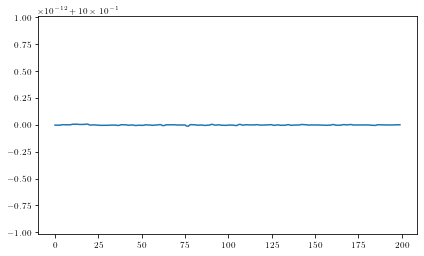

In [349]:
plt.plot(np.abs(val))

In [114]:
params_m.von_Neumann_entropy_m(np.hstack([np.arange(params_m.L//2,params_m.L//4*3)]))

0.6931471805599432

In [115]:
params_m.von_Neumann_entropy_m(np.hstack([np.arange(params_m.L//4)]))

0.6931471805599432

In [ ]:
params_m.von_Neumann_entropy_m(np.hstack([np.arange(params_m.L//4),np.arange(params_m.L//2,params_m.L//4*3)]))

0.6931471805599484

In [112]:
params_m.mutual_information_m(np.arange(params_m.L//4),np.arange(params_m.L//2,params_m.L//4*3))/np.log(2)

0.9999999999999895

In [111]:
params_m.log_neg(np.arange(params_m.L//4),np.arange(params_m.L//2,params_m.L//4*3))/np.log(2)

0.5000000107489152

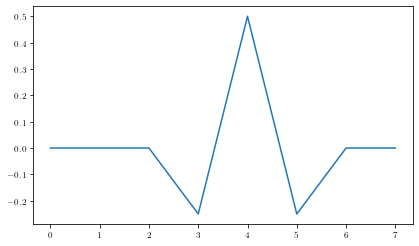

In [90]:
plt.plot(params_m.C_f[:params_m.L,:params_m.L][params_m.L//2])

In [176]:
z1=params_m.C_m

In [183]:
params=Params(delta=-0.5,L=np.inf,T=2)
params.correlation_matrix_inf_fft()

In [184]:
for i in range(2):
    for j in range(2):
        print(((params.C_f)[i*params.dmax:i*params.dmax+4,j*params.dmax:j*params.dmax+4]-(params_m.C_f)[i*params_m.L:i*params_m.L+4,j*params_m.L:j*params_m.L+4]).__abs__().max())

3.3306690738754696e-16
1.5959455978986625e-16
1.5265566588595902e-16
3.3306690738754696e-16


In [80]:
np.imag(params.C_f).__abs__().max()

0.0

In [81]:
(params_m.C_f)[:4,:4]

array([[ 7.02918921e-01, -9.46787344e-02, -6.21612354e-03,
        -5.16796853e-04],
       [-9.46787344e-02,  7.02918921e-01, -9.46787344e-02,
        -6.21612354e-03],
       [-6.21612354e-03, -9.46787344e-02,  7.02918921e-01,
        -9.46787344e-02],
       [-5.16796853e-04, -6.21612354e-03, -9.46787344e-02,
         7.02918921e-01]])

In [82]:
(params.C_f)[:4,:4]

array([[ 7.02918921e-01, -9.46787344e-02, -6.21612354e-03,
        -5.16796853e-04],
       [-9.46787344e-02,  7.02918921e-01, -9.46787344e-02,
        -6.21612354e-03],
       [-6.21612354e-03, -9.46787344e-02,  7.02918921e-01,
        -9.46787344e-02],
       [-5.16796853e-04, -6.21612354e-03, -9.46787344e-02,
         7.02918921e-01]])

In [95]:
(params_m.C_f)[:4,128:128+4]

array([[ 1.04094341e-17, -1.08240187e-01, -7.34532904e-03,
        -6.12408645e-04],
       [ 1.08240187e-01, -1.01294860e-17, -1.08240187e-01,
        -7.34532904e-03],
       [ 7.34532904e-03,  1.08240187e-01, -6.53354258e-17,
        -1.08240187e-01],
       [ 6.12408645e-04,  7.34532904e-03,  1.08240187e-01,
         3.73508667e-18]])

In [96]:
params.C_f[:4,100:104]

array([[ 0.        , -0.10824019, -0.00734533, -0.00061241],
       [ 0.10824019,  0.        , -0.10824019, -0.00734533],
       [ 0.00734533,  0.10824019,  0.        , -0.10824019],
       [ 0.00061241,  0.00734533,  0.10824019,  0.        ]])

In [59]:
(params.C_f)[:4,100:104]-params.C_f[:4,100:104]

array([[0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.]])

In [55]:
((params.C_f)[:20,:20]-(params_m.C_f)[:20,:20]).__abs__().max()

8.871583010211428e-06

In [53]:
params_m.bandstructure()

In [ ]:
plt.hist(Esum)

In [ ]:
params_f=Params(delta=-1,L=4,bc=-1,basis='mf')
params_f.covariance_matrix_f()

In [ ]:
params_m.von_Neumann_entropy_f(np.arange(4))

In [ ]:
params_f.measure(0,0,1)

In [ ]:
params_f.measure_all_Born()

In [ ]:
params_f.C_f

In [ ]:
params_f.P_0_list

In [ ]:
np.round(params_f.C_m_history[-1],3)

In [ ]:
params.measure_all_Born()

In [ ]:
params.P_0_list

In [ ]:
params.C_m@params.C_m

In [ ]:
params=Params(delta=0,L=64,bc=-1,basis='mf')
params.covariance_matrix_f()
params.C_m

In [ ]:
params.C_m@params.C_m

In [ ]:
params.C_m

In [ ]:
params.C_f

In [ ]:
params.measure_all_Born()

In [ ]:
params.P_0_list

In [ ]:
params.covariance_matrix_f()

In [ ]:
print(np.round(params.C_m,3))

In [ ]:
params.covariance_matrix_m()

In [ ]:
print(np.round(params.C_f,3))

In [ ]:
params.C_f[1,1]

In [ ]:
params.C_f[1,1]+params.C_f[1+params.L,1+params.L]

In [ ]:
zz=params.projection(1)

In [ ]:
zz@zz

In [ ]:
delta_list=np.linspace(-1,1,100)
eigvallist_f=[]
eigvallist_m=[]
for delta in delta_list:
    params=Params(delta,L=64,bc=1,basis='mf')
    params.bandstructure('f')
    params.bandstructure('m')
    eigvallist_f.append(params.val_f)
    eigvallist_m.append(params.val_m)


In [ ]:
fig,ax=plt.subplots(1,2,sharey=True)
for index in range(eigvallist_f[0].shape[0]):
    ax[0].plot(delta_list,np.array(eigvallist_m)[:,index],'k')
    ax[1].plot(delta_list,np.array(eigvallist_f)[:,index],'k')
[ax.set_xlabel(r'$\delta$') for ax in ax]
ax[0].set_ylabel(r'$E$')
[ax.text(.5,1,text,transform=ax.transAxes,ha='center',va='bottom') for ax,text in zip(ax,('Majorana basis','Particle-hole basis'))]
# ax[0].set_ylim(-1,1)

fig.tight_layout()

# fig.savefig('/mnt/d/kitp/Rp_SPT/3/bandstructure-apbc.pdf',bbox_inches='tight')


In [ ]:
delta_list=np.linspace(-1,1,100)
eigvallist_f=[]
eigvallist_m=[]
for delta in delta_list:
    params=Params(delta,L=16,bc=0)
    params.bandstructure('f')
    params.bandstructure('m')
    eigvallist_f.append(params.val_f)
    eigvallist_m.append(params.val_m)


In [ ]:
fig,ax=plt.subplots(1,2,sharey=True)
for index in range(eigvallist_m[0].shape[0]):
    ax[0].plot(delta_list,np.array(eigvallist_m)[:,index],'k')
    ax[1].plot(delta_list,np.array(eigvallist_f)[:,index],'k')
[ax.set_xlabel(r'$\delta$') for ax in ax]
ax[0].set_ylabel(r'$E$')
[ax.text(.5,1,text,transform=ax.transAxes,ha='center',va='bottom') for ax,text in zip(ax,('Majorana basis','Particle-hole basis'))]

fig.tight_layout()

# fig.savefig('/mnt/d/kitp/Rp_SPT/3/bandstructure-obc.pdf',bbox_inches='tight')


# Covariance and Correlation matrix

In [ ]:
params=Params(delta=-.9,L=4,bc=-1)

In [ ]:
params.bandstructure('f')
params.bandstructure('m')

# %lprun -f params.covariance_matrix_m params.covariance_matrix_m()
# %lprun -f params.covariance_matrix_m_obs params.covariance_matrix_m_obs()
# params.correlation_matrix()
# params.covariance_matrix_f()

In [ ]:
# Born rule may be incorrect because Gamma is transponsed

In [ ]:
zo=params.C_m

In [ ]:
plt.imshow(zn)

In [ ]:
zn

In [ ]:
zn=(np.real(params.C_m))

In [ ]:
plt.imshow(params.C_f)

In [ ]:
print(params.C_f[:4,:4])

In [ ]:
print(params.C_f[:4,4:])

In [ ]:
params.C_f[4:,:4]

In [ ]:
print(params.C_f[4:,4:])

In [ ]:
l=8
val_sub={}
val_sub['f']=la.eigh(params.c_subregion_f(np.arange(l)),eigvals_only=True)
val_sub['m']=la.eigh(1j*params.c_subregion_m(np.arange(2*l)),eigvals_only=True)

In [ ]:
fig,ax=plt.subplots(2,2,figsize=(6.8,6.8))
im0=ax[0,0].imshow(params.C_m,cmap='seismic')
im1=ax[0,1].imshow(params.C_m@params.C_m,cmap='hot')
ax[0,0].text(0.5,1.1,r'$\Gamma$',transform=ax[0,0].transAxes,ha='center',va='bottom')
ax[0,1].text(0.5,1.1,r'$\Gamma^2$',transform=ax[0,1].transAxes,ha='center',va='bottom')


# [ax.set_box_aspect(1) for ax in ax]

axins0=ax[0,0].inset_axes([0.0, -.1, 1, 0.05],transform=ax[0,0].transAxes) 
cb0=fig.colorbar(im0,cax=axins0,orientation='horizontal')
cb0.ax.xaxis.set_tick_params(pad=0)

axins1=ax[0,1].inset_axes([0.0, -.1, 1, 0.05],transform=ax[0,1].transAxes) 
cb1=fig.colorbar(im1,cax=axins1,orientation='horizontal')
cb1.ax.xaxis.set_tick_params(pad=0)

im2=ax[1,0].imshow(params.C_f,cmap='seismic',vmax=1,vmin=-1)
ax[1,0].text(0.5,1.1,r'$G$',transform=ax[1,0].transAxes,ha='center',va='bottom')
axins2=ax[1,0].inset_axes([0.0, -.1, 1, 0.05],transform=ax[1,0].transAxes) 
cb2=fig.colorbar(im2,cax=axins2,orientation='horizontal')
cb2.ax.xaxis.set_tick_params(pad=0)

color = 'tab:red'
ax[1,1].plot(val_sub['f'],'.',marker="x",color=color)
ax[1,1].set_xlabel('Number of eigenvalues')
ax[1,1].set_ylabel(r'Eigenvalues of $G$', color=color)
ax[1,1].tick_params(axis='y', labelcolor=color)


ax2=ax[1,1].twinx()
color = 'tab:blue'
ax2.plot(val_sub['m'],'.',marker="+",color=color)
ax2.set_ylabel(r'Eigenvalues of $i\Gamma$', color=color)  # we already handled the x-label with ax1
ax2.tick_params(axis='y', labelcolor=color)

[ax.xaxis.set_label_position('top') for ax in ax.flatten()[:3]]
[ax.xaxis.tick_top() for ax in ax.flatten()[:3]]
[ax.set_xticks([0,15,31]) for ax in ax.flatten()[:3]]
[ax.set_yticks([0,15,31]) for ax in ax.flatten()[:3]]
[ax.set_xticklabels([1,16,32]) for ax in ax.flatten()[:3]]
[ax.set_yticklabels([1,16,32]) for ax in ax.flatten()[:3]]

[ax.text(-0.,1.02,'({})'.format(text),transform=ax.transAxes,ha='right',va='bottom') for ax,text in zip(ax.flatten(),'abcd')]
ax[1,1].set_box_aspect(1)
fig.tight_layout()
# fig.savefig('/mnt/d/kitp/Rp_SPT/3/cov.pdf',bbox_inches='tight')


In [ ]:
params=Params(delta=0,L=128,bc=-1)
# params=Params(delta=1,L=64,bc=-1)
params.covariance_matrix_m()
params.covariance_matrix_f()
l=40
val_sub={}
val_sub['f']=la.eigh(params.c_subregion_f(np.arange(l)),eigvals_only=True)
val_sub['m']=la.eigh(1j*params.c_subregion_m(np.arange(2*l)),eigvals_only=True)

In [ ]:
fig,ax=plt.subplots(2,2,figsize=(6.8,6.8))
im0=ax[0,0].imshow(params.C_m,cmap='seismic')
im1=ax[0,1].imshow(params.C_m@params.C_m,cmap='hot')
ax[0,0].text(0.5,1.1,r'$\Gamma$',transform=ax[0,0].transAxes,ha='center',va='bottom')
ax[0,1].text(0.5,1.1,r'$\Gamma^2$',transform=ax[0,1].transAxes,ha='center',va='bottom')


# [ax.set_box_aspect(1) for ax in ax]

axins0=ax[0,0].inset_axes([0.0, -.1, 1, 0.05],transform=ax[0,0].transAxes) 
cb0=fig.colorbar(im0,cax=axins0,orientation='horizontal')
cb0.ax.xaxis.set_tick_params(pad=0)

axins1=ax[0,1].inset_axes([0.0, -.1, 1, 0.05],transform=ax[0,1].transAxes) 
cb1=fig.colorbar(im1,cax=axins1,orientation='horizontal')
cb1.ax.xaxis.set_tick_params(pad=0)

im2=ax[1,0].imshow(params.C_f,cmap='seismic',vmax=1,vmin=-1)
ax[1,0].text(0.5,1.1,r'$G$',transform=ax[1,0].transAxes,ha='center',va='bottom')
axins2=ax[1,0].inset_axes([0.0, -.1, 1, 0.05],transform=ax[1,0].transAxes) 
cb2=fig.colorbar(im2,cax=axins2,orientation='horizontal')
cb2.ax.xaxis.set_tick_params(pad=0)

color = 'tab:red'
ax[1,1].plot(val_sub['f'],'.',marker="x",color=color)
ax[1,1].set_xlabel('Number of eigenvalues')
ax[1,1].set_ylabel(r'Eigenvalues of $G$', color=color)
ax[1,1].tick_params(axis='y', labelcolor=color)


ax2=ax[1,1].twinx()
color = 'tab:blue'
ax2.plot(val_sub['m'],'.',marker="+",color=color)
ax2.set_ylabel(r'Eigenvalues of $i\Gamma$', color=color)  # we already handled the x-label with ax1
ax2.tick_params(axis='y', labelcolor=color)

[ax.xaxis.set_label_position('top') for ax in ax.flatten()[:3]]
[ax.xaxis.tick_top() for ax in ax.flatten()[:3]]
[ax.set_xticks([0,params.L-1,2*params.L-1]) for ax in ax.flatten()[:3]]
[ax.set_yticks([0,params.L-1,2*params.L-1]) for ax in ax.flatten()[:3]]
[ax.set_xticklabels([1,params.L,2*params.L]) for ax in ax.flatten()[:3]]
[ax.set_yticklabels([1,params.L,2*params.L]) for ax in ax.flatten()[:3]]

[ax.text(-0.,1.02,'({})'.format(text),transform=ax.transAxes,ha='right',va='bottom') for ax,text in zip(ax.flatten(),'abcd')]
ax[1,1].set_box_aspect(1)
fig.tight_layout()
# fig.savefig('/mnt/d/kitp/Rp_SPT/4/cov.pdf',bbox_inches='tight')


In [ ]:
# val_sub_f={}
# val_sub_m={}
for i in (0.02,):
    params=Params(delta=i,L=128,bc=-1)
    params.covariance_matrix_m()
    params.covariance_matrix_f()
    l=40
    val_sub_f[i]=la.eigh(params.c_subregion_f(np.arange(l)),eigvals_only=True)
    val_sub_m[i]=la.eigh(1j*params.c_subregion_m(np.arange(2*l)),eigvals_only=True)

In [ ]:
val_sub_f.keys()

In [ ]:
fig,axs=plt.subplots(3,3,sharex=True,sharey=True)

delta_list=(-0.1,-0.05,-0.02,-0.01,0,0.01,0.1,0.02,0.05,0.1)

for index,(ax,delta) in enumerate(zip(axs.flatten(),delta_list)):
    color = 'tab:red'
    ax.plot(val_sub_f[delta],'.',marker="x",color=color)
    if index>=6:
        ax.set_xlabel('Number of eigenvalues')
    ax.tick_params(axis='y', labelcolor=color)
    if index % 3==0:
        [ax.set_ylabel(r'Eigenvalues of $G$', color=color) for ax in axs[:,0]]

    ax.text(.5,1,r'$\delta$={:.2f}'.format(delta),ha='center',va='bottom',transform=ax.transAxes)

    ax2=ax.twinx()
    color = 'tab:blue'
    ax2.plot(val_sub_m[delta],'.',marker="+",color=color)
    if (index-2) %3 ==0:
        ax2.set_ylabel(r'Eigenvalues of $i\Gamma$', color=color)  
    ax2.tick_params(axis='y', labelcolor=color)

fig.savefig('/mnt/d/kitp/Rp_SPT/5/entanglement_spectrum.pdf',bbox_inches='tight')

# [ax.set_ylabel(r'Eigenvalues of $i\Gamma$', color=color)]

# Mutual information

In [ ]:
delta_list=np.linspace(-1,1,100)**5
mutual_info_list=[]
for delta in delta_list:
    params=Params(delta=delta,L=64,bc=-1)
    mutual_info_list.append(params.mutual_information_m(np.arange(2),np.arange(2)+30))

In [ ]:
plt.plot(delta_list,mutual_info_list/np.log(2))

# Profiling

In [ ]:
p_n.Hamiltonian_m-p_o.Hamiltonian_m

In [ ]:
st=time.time()
%lprun -f Params.__init__ p_n=Params(delta=0,L=64,bc=-1,basis='mf')
# params.measure_all_random_even(16,(int(params.L/2),params.L))
print((time.time()-st))

In [ ]:
st=time.time()
%lprun -f Params.__init__ p_o=Params(delta=0,L=64,bc=-1)
# params.measure_all_random_even(16,(int(params.L/2),params.L))
print(time.time()-st)

In [ ]:
st=time.time()
%lprun -f Params.__init__ Params(delta=0,L=64,bc=-1)
# params.measure_all_random_even(16,(int(params.L/2),params.L))
print(time.time()-st)

In [ ]:
np.sort(params.i_history)

In [ ]:
params.s_history

In [ ]:
params=Params(delta=delta,L=64,bc=-1)
%lprun -f params.measure_all_random_even params.measure_all_random_even(12,(int(params.L/2),params.L))

In [ ]:
%%prun
delta_dict={}
mutual_info_dis_dict={}
for i in (12,):
    print(i)
    delta_dict[i],mutual_info_dis_dict[i]=mutual_info_run(i)

In [ ]:
m = range(25)
m =np.reshape(m,(5,5))
print(m)

In [ ]:
m[[1,-2],:]

In [ ]:
m[:,[1,-2]]=m[:,[-2,1]]

In [ ]:
print(m)

In [ ]:
idx=1
m[idx:,:]=np.roll(m[idx:,:],-1,0)
m[:,idx:]=np.roll(m[:,idx:],-1,1)
print(m)

In [ ]:
jdx=2
m[jdx:,:]=np.roll(m[jdx:,:],-1,0)
m[:,jdx:]=np.roll(m[:,jdx:],-1,1)
print(m)

In [ ]:
m[jdx:,:]=np.roll(m[jdx:,:],1,0)
m[:,jdx:]=np.roll(m[:,jdx:],1,1)
print(m)

In [ ]:
m[idx:,:]=np.roll(m[idx:,:],1,0)
m[:,idx:]=np.roll(m[:,idx:],1,1)
print(m)

In [ ]:
np.roll(m,1,axis=1)

In [ ]:
np.roll(m[row][:column+1], 1)

In [ ]:
params=Params(delta=0.3,L=64,bc=-1)
params.covariance_matrix_m()
z1=(params.C_m_history)
params.measure_obs(0,2,3)
params.measure_obs(0,12,13)
z11=params.C_m_history

In [ ]:
params2=Params(delta=0.3,L=64,bc=-1)
params2.covariance_matrix_m()
z2=params2.C_m_history
params2.measure(0,2,3)
params2.measure(0,12,13)
z21=params2.C_m_history

In [ ]:
params3=Params(delta=0.3,L=64,bc=-1)
params3.covariance_matrix_m()
z3=(params3.C_m_history)
params3.measure_new(0,2,3)
params3.measure_new(0,12,13)
z31=params3.C_m_history

In [ ]:
params.m

In [ ]:
params2.m

In [ ]:
(params.m-params2.m).max()

In [ ]:
z1[0]-z2[0]

In [ ]:
z1[-3]-z2[-3]

In [ ]:
z3[-1]-z2[-1]

In [ ]:
z11[0]-z1[0]

In [ ]:
z21[0]-z2[0]

In [ ]:
(z2[-1]-z1[-1]).max()

In [ ]:
params2.C_m_history[0]-params.C_m_history[0]


In [ ]:
params=Params(delta=delta,L=64,bc=-1)
%lprun -f params.projection params.projection(1)

In [ ]:
params=Params(delta=delta,L=64,bc=-1)
%lprun -f params.projection params.projection(1)

In [ ]:
params=Params(delta=delta,L=64,bc=-1)
%lprun -f params.projection params.projection(1)

In [ ]:
pp_o=Params(delta=0.3,L=64,bc=-1)
%lprun -f Params.bandstructure_obs pp_o.bandstructure_obs('m')

In [ ]:
pp_n=Params(delta=0.3,L=64,bc=-1)
%lprun -f Params.bandstructure pp_n.bandstructure('m')

In [ ]:
params=Params(delta=delta,L=64,bc=-1)
# params.covariance_matrix_m()
%lprun -f params.covariance_matrix_m params.covariance_matrix_m()

In [ ]:
params=Params(delta=delta,L=64,bc=-1)
params.covariance_matrix_m()
%lprun -f params.measure_new params.measure_new(0,14,15)

In [ ]:
params=Params(delta=delta,L=64,bc=-1)
params.covariance_matrix_m()
%lprun -f params.measure params.measure(0,11,12)

In [ ]:
params=Params(delta=delta,L=64,bc=-1)
params.covariance_matrix_m()
%lprun -f params.measure params.measure(0,14,15)

In [ ]:
params=Params(delta=delta,L=64,bc=-1)
params.covariance_matrix_m()
%lprun -f params.measure_obs params.measure_obs(0,14,15)

In [ ]:
%lprun -f mutual_info_run mutual_info_run(12)

In [ ]:
%lprun -f mutual_info_run mutual_info_run(12)

In [ ]:
%lprun -f mutual_info_run mutual_info_run(12)

# Mutual info - density of operators

In [ ]:
def mutual_info_run(batchsize):
    delta_list=np.linspace(-1,1,20)**3
    mutual_info_dis_list=[]
    if batchsize==0:
        ensemblesize=1
    else:
        ensemblesize=100

    for delta in delta_list:
        mutual_info_ensemble_list=[]
        for ensemble in range(ensemblesize):
            params=Params(delta=delta,L=64,bc=-1)
            params.measure_all_random_even(batchsize,(int(params.L/2),params.L))
            mutual_info_ensemble_list.append(params.mutual_information_m(np.arange(int(params.L/2)),np.arange(int(params.L/2))+params.L))
        mutual_info_dis_list.append(mutual_info_ensemble_list)
    return delta_list,mutual_info_dis_list

In [ ]:
np.random.rand()

In [ ]:
delta_dict={}
mutual_info_dis_dict={}
i=12
for i in (0,12,13,14,15,16):
    print(i)
    delta_dict[i],mutual_info_dis_dict[i]=mutual_info_run(i)
print(time.time()-st)

In [ ]:
for i in (0,13,14,15,16):
    print(i)
    delta_dict[i],mutual_info_dis_dict[i]=mutual_info_run(i)

In [ ]:
delta_dict.keys()

In [ ]:
fig,ax=plt.subplots()
for i in (0,12,14,15,16):
    ax.plot(delta_dict[i],np.array(mutual_info_dis_dict[i]).mean(axis=1)/np.log(2),label='Number of gates: {}'.format(i))

ax.legend()
ax.set_xlabel(r'$\delta$')
ax.set_ylabel(r'Mutual information between A and B [$\log2$]')

# fig.savefig('/mnt/d/kitp/Rp_SPT/4/mutual_info_Ap_En200.pdf',bbox_inches='tight')


In [ ]:
es=1000
with open('/mnt/d/KITP/Rp_SPT/5/mutual_info_Ap_En{:d}.pickle'.format(es),'rb') as f:
    delta_dict_para,mutual_info_dis_dict_para=pickle.load(f)

In [ ]:
fig,axs=plt.subplots(2,1,figsize=(6.8,6.8),sharex=True)
colorlist='bgrcmyk'
ax=axs[0]
for i,color in zip(delta_dict_para.keys(),colorlist):
    ax.plot(delta_dict_para[i],remove_outlier(mutual_info_dis_dict_para[i]).mean(axis=1)/np.log(2),'.-',label='Number of gates: {}'.format(i),color=color)

ax.legend()
# ax.set_xlabel(r'$\delta$')
ax.set_ylabel(r'Mutual information between A and B [$\log2$]')

ax=axs[1]
for i,color in zip(delta_dict_para.keys(),colorlist):
    ax.plot(delta_dict_para[i],remove_outlier(mutual_info_dis_dict_para[i]).std(axis=1)/np.log(2),'.-',label='Number of gates: {}'.format(i),color=color)

ax.legend()
ax.set_xlabel(r'$\delta$')
ax.set_ylabel(r'STD of MI between A and B [$\log2$]')
fig.tight_layout()
fig.savefig('/mnt/d/kitp/Rp_SPT/5/mutual_info_Ap_En{:d}.pdf'.format(es),bbox_inches='tight')


In [ ]:
es=2000
with open('/mnt/d/KITP/Rp_SPT/5/mutual_info_Ap_En{:d}.pickle'.format(es),'rb') as f:
    delta_dict_para,mutual_info_dis_dict_para=pickle.load(f)

In [ ]:
fig,axs=plt.subplots(2,1,figsize=(6.8,6.8),sharex=True)
colorlist='bgrcmyk'
ax=axs[0]
for i,color in zip(delta_dict_para.keys(),colorlist):
    ax.plot(delta_dict_para[i],remove_outlier(mutual_info_dis_dict_para[i]).mean(axis=1)/np.log(2),'.-',label='Number of gates: {}'.format(i),color=color)

ax.legend()
# ax.set_xlabel(r'$\delta$')
ax.set_ylabel(r'Mutual information between A and B [$\log2$]')

ax=axs[1]
for i,color in zip(delta_dict_para.keys(),colorlist):
    ax.plot(delta_dict_para[i],remove_outlier(mutual_info_dis_dict_para[i]).std(axis=1)/np.log(2),'.-',label='Number of gates: {}'.format(i),color=color)

ax.legend()
ax.set_xlabel(r'$\delta$')
ax.set_ylabel(r'STD of MI between A and B [$\log2$]')
fig.tight_layout()
fig.savefig('/mnt/d/kitp/Rp_SPT/5/mutual_info_Ap_En{:d}.pdf'.format(es),bbox_inches='tight')


In [ ]:
es=3000
with open('/mnt/d/KITP/Rp_SPT/5/mutual_info_Ap_En{:d}.pickle'.format(es),'rb') as f:
    delta_dict_para,mutual_info_dis_dict_para=pickle.load(f)

In [ ]:
def remove_outlier(a):
    if np.array(a).shape[1]==1:
        return np.array(a)
    else:
        return np.sort(np.array(a),axis=1)[:,1:-1]

In [ ]:
fig,axs=plt.subplots(2,1,figsize=(6.8,6.8),sharex=True)
colorlist='bgrcmyk'
ax=axs[0]
for i,color in zip(delta_dict_para.keys(),colorlist):
    ax.plot(delta_dict_para[i],remove_outlier(mutual_info_dis_dict_para[i]).mean(axis=1)/np.log(2),'.-',label='Number of gates: {}'.format(i),color=color)

ax.legend()
# ax.set_xlabel(r'$\delta$')
ax.set_ylabel(r'Mutual information between A and B [$\log2$]')

ax=axs[1]
for i,color in zip(delta_dict_para.keys(),colorlist):
    ax.plot(delta_dict_para[i],remove_outlier(mutual_info_dis_dict_para[i]).std(axis=1)/np.log(2),'.-',label='Number of gates: {}'.format(i),color=color)

ax.legend()
ax.set_xlabel(r'$\delta$')
ax.set_ylabel(r'STD of MI between A and B [$\log2$]')
fig.tight_layout()
fig.savefig('/mnt/d/kitp/Rp_SPT/5/mutual_info_Ap_En{:d}.pdf'.format(es),bbox_inches='tight')


In [ ]:
es=5000
with open('/mnt/d/KITP/Rp_SPT/5/mutual_info_Ap_En{:d}.pickle'.format(es),'rb') as f:
    delta_dict_para,mutual_info_dis_dict_para=pickle.load(f)

In [ ]:
fig,axs=plt.subplots(2,1,figsize=(6.8,6.8),sharex=True)
colorlist='bgrcmyk'
ax=axs[0]
for i,color in zip(delta_dict_para.keys(),colorlist):
    ax.plot(delta_dict_para[i],remove_outlier(mutual_info_dis_dict_para[i]).mean(axis=1)/np.log(2),'.-',label='Number of gates: {}'.format(i),color=color)

ax.legend()
# ax.set_xlabel(r'$\delta$')
ax.set_ylabel(r'Mutual information between A and B [$\log2$]')

ax=axs[1]
for i,color in zip(delta_dict_para.keys(),colorlist):
    ax.plot(delta_dict_para[i],remove_outlier(mutual_info_dis_dict_para[i]).std(axis=1)/np.log(2),'.-',label='Number of gates: {}'.format(i),color=color)

ax.legend()
ax.set_xlabel(r'$\delta$')
ax.set_ylabel(r'STD of MI between A and B [$\log2$]')
fig.tight_layout()
fig.savefig('/mnt/d/kitp/Rp_SPT/5/mutual_info_Ap_En{:d}.pdf'.format(es),bbox_inches='tight')


In [ ]:
es=10000
with open('/mnt/d/KITP/Rp_SPT/5/mutual_info_Ap_En{:d}.pickle'.format(es),'rb') as f:
    delta_dict_para,mutual_info_dis_dict_para=pickle.load(f)

In [ ]:
fig,axs=plt.subplots(2,1,figsize=(6.8,6.8),sharex=True)
colorlist='bgrcmyk'
ax=axs[0]
for i,color in zip(delta_dict_para.keys(),colorlist):
    ax.plot(delta_dict_para[i],remove_outlier(mutual_info_dis_dict_para[i]).mean(axis=1)/np.log(2),'.-',label='Number of gates: {}'.format(i),color=color)

ax.legend()
# ax.set_xlabel(r'$\delta$')
ax.set_ylabel(r'Mutual information between A and B [$\log2$]')

ax=axs[1]
for i,color in zip(delta_dict_para.keys(),colorlist):
    ax.plot(delta_dict_para[i],remove_outlier(mutual_info_dis_dict_para[i]).std(axis=1)/np.log(2),'.-',label='Number of gates: {}'.format(i),color=color)

ax.legend()
ax.set_xlabel(r'$\delta$')
ax.set_ylabel(r'STD of MI between A and B [$\log2$]')
fig.tight_layout()
fig.savefig('/mnt/d/kitp/Rp_SPT/5/mutual_info_Ap_En{:d}.pdf'.format(es),bbox_inches='tight')


# Measure all gates to intermedate region with same projection

## Measurement on A or B after projection

### no measurment

In [4]:
params=Params(delta=0,L=64,bc=-1,basis='f')

In [5]:
params.mutual_information_m(np.arange(params.L//4),np.arange(params.L//4)+params.L//2)

0.11544416870824792

In [6]:
delta_list=np.linspace(-1,1,100)**3
MI_list=[]
LN_list=[]

for delta in delta_list:
    params=Params(delta=delta,L=64,bc=-1,basis='f')
    MI_list.append(params.mutual_information_m(np.arange(params.L//4),np.arange(params.L//4)+params.L//2))
    LN_list.append(params.log_neg(np.arange(params.L//4),np.arange(params.L//4)+params.L//2))

### all projections to 0 (emtpy) charge=1


In [7]:
MI_pos_list=[]
LN_pos_list=[]
for delta in delta_list:
    params=Params(delta=delta,L=64,bc=-1)
    params.measure_all(1)
    MI_pos_list.append(params.mutual_information_m(np.arange(params.L//4),np.arange(params.L//4)+params.L//2))
    LN_pos_list.append(params.log_neg(np.arange(params.L//4),np.arange(params.L//4)+params.L//2))

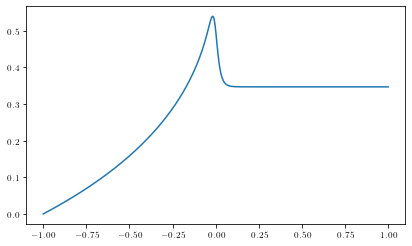

In [8]:
plt.plot(delta_list,LN_pos_list)

### all projections to 1 (occupied) charge=-1


In [9]:
MI_neg_list=[]
LN_neg_list=[]
for delta in delta_list:
    params=Params(delta=delta,L=64,bc=-1)
    params.measure_all(0)
    MI_neg_list.append(params.mutual_information_m(np.arange(params.L//4),np.arange(params.L//4)+params.L//2))
    LN_neg_list.append(params.log_neg(np.arange(params.L//4),np.arange(params.L//4)+params.L//2))

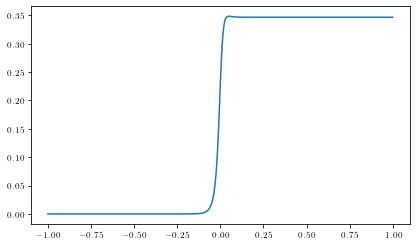

In [10]:
plt.plot(delta_list,LN_neg_list)

### Born rules

In [13]:
es=100
MI_Born_list=np.zeros((delta_list.shape[0],es))
LN_Born_list=np.zeros((delta_list.shape[0],es))
for delta_i,delta in enumerate(delta_list):
    for es_i in range(es):
        params=Params(delta=delta,L=64,bc=-1)
        params.measure_all_Born()
        MI_Born_list[delta_i,es_i]=(params.mutual_information_m(np.arange(params.L//4),np.arange(params.L//4)+params.L//2))
        LN_Born_list[delta_i,es_i]=(params.log_neg(np.arange(params.L//4),np.arange(params.L//4)+params.L//2))

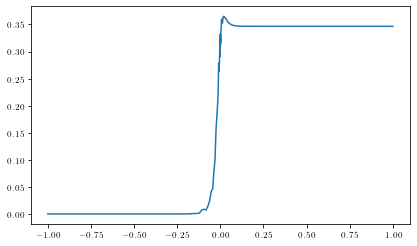

In [14]:
plt.plot(delta_list,LN_Born_list.mean(axis=1))

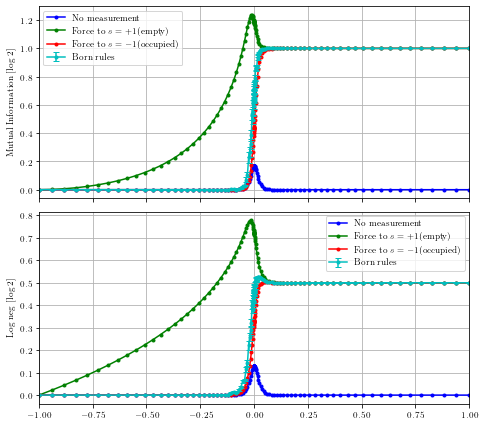

In [35]:
fig,ax=plt.subplots(2,1,figsize=(6.8,6),sharex=True,tight_layout=True)
ax[0].plot(delta_list,MI_list/np.log(2),'.-',color='b',label='No measurement')
ax[0].plot(delta_list,MI_pos_list/np.log(2),'.-',color='g',label='Force to $s=+1$(empty)')
ax[0].plot(delta_list,MI_neg_list/np.log(2),'.-',color='r',label='Force to $s=-1$(occupied)')
ax[0].errorbar(delta_list,MI_Born_list.mean(axis=1)/np.log(2),MI_Born_list.std(axis=1)/np.sqrt(es)/np.log(2),capsize=3,fmt='.-',color='c',label='Born rules')
ax[0].grid('on')
ax[0].margins(x=0)
ax[0].legend()
ax[0].set_ylabel('Mutual Information [log 2]')

ax[1].plot(delta_list,LN_list/np.log(2),'.-',color='b',label='No measurement')
ax[1].plot(delta_list,LN_pos_list/np.log(2),'.-',color='g',label='Force to $s=+1$(empty)')
ax[1].plot(delta_list,LN_neg_list/np.log(2),'.-',color='r',label='Force to $s=-1$(occupied)')
ax[1].errorbar(delta_list,LN_Born_list.mean(axis=1)/np.log(2),LN_Born_list.std(axis=1)/np.sqrt(es)/np.log(2),capsize=3,fmt='.-',color='c',label='Born rules')
ax[1].grid('on')
ax[1].margins(x=0)
ax[1].legend()
ax[1].set_ylabel('Log neg [log 2]')

fig.savefig('/mnt/d/KITP/Rp_SPT/13/Maj_meas.pdf')

### all projections to 0 followed by measuring 0 within A 

In [ ]:
mutual_info_pos_post0A_list=[]
for delta in delta_list:
    params=Params(delta=delta,L=64,bc=-1)
    params.measure_all(1)
    params.measure(0,0,1)
    mutual_info_pos_post0A_list.append(params.mutual_information_m(np.arange(int(params.L/2)),np.arange(params.L/2)+params.L))

In [ ]:
LN_pos_post0A_list=[]
for delta in delta_list:
    params=Params(delta=delta,L=64,bc=-1)
    params.measure_all(1)
    params.measure(0,0,1)
    LN_pos_post0A_list.append(params.log_neg())

### all projections to 0 followed by measuring 0 within A and B


In [ ]:
mutual_info_pos_post0AB_list=[]
for delta in delta_list:
    params=Params(delta=delta,L=64,bc=-1)
    params.measure_all(1)
    params.measure(0,0,1)
    params.measure(0,64,65)
    mutual_info_pos_post0AB_list.append(params.mutual_information_m(np.arange(int(params.L/2)),np.arange(params.L/2)+params.L))

In [ ]:
LN_pos_post0AB_list=[]
for delta in delta_list:
    params=Params(delta=delta,L=64,bc=-1)
    params.measure_all(1)
    params.measure(0,0,1)
    params.measure(0,64,65)
    LN_pos_post0AB_list.append(params.log_neg())

In [ ]:
plt.plot(delta_list,LN_pos_post1A_B_list)

### all projections to 0 followed by measuring 0 within all A

In [ ]:
mutual_info_pos_post0A_all_list=[]
for delta in delta_list:
    params=Params(delta=delta,L=64,bc=-1)
    params.measure_all(1)
    [params.measure(0,i,i+1) for i in range(0,int(params.L/2),2)]
    mutual_info_pos_post0A_all_list.append(params.mutual_information_m(np.arange(int(params.L/2)),np.arange(params.L/2)+params.L))

In [ ]:
LN_pos_post0A_all_list=[]
for delta in delta_list:
    params=Params(delta=delta,L=64,bc=-1)
    params.measure_all(1)
    [params.measure(0,i,i+1) for i in range(0,int(params.L/2),2)]
    LN_pos_post0A_all_list.append(params.log_neg())

### all projections to 0 followed by measuring 0 within all A & B

In [ ]:
mutual_info_pos_post0AB_all_list=[]
for delta in delta_list:
    params=Params(delta=delta,L=64,bc=-1)
    params.measure_all(1)
    [params.measure(0,i,i+1) for i in range(0,int(params.L/2),2)]
    [params.measure(0,i+params.L,i+1+params.L) for i in range(0,int(params.L/2),2)]
    mutual_info_pos_post0AB_all_list.append(params.mutual_information_m(np.arange(int(params.L/2)),np.arange(params.L/2)+params.L))

In [ ]:
LN_pos_post0AB_all_list=[]
for delta in delta_list:
    params=Params(delta=delta,L=64,bc=-1)
    params.measure_all(1)
    [params.measure(0,i,i+1) for i in range(0,int(params.L/2),2)]
    [params.measure(0,i+params.L,i+1+params.L) for i in range(0,int(params.L/2),2)]
    LN_pos_post0AB_all_list.append(params.log_neg())

### all projections to 0 followed by measuring 1 within all A

In [ ]:
mutual_info_pos_post1A_all_list=[]
for delta in delta_list:
    params=Params(delta=delta,L=64,bc=-1)
    params.measure_all(1)
    [params.measure(1,i,i+1) for i in range(0,int(params.L/2),2)]
    mutual_info_pos_post1A_all_list.append(params.mutual_information_m(np.arange(int(params.L/2)),np.arange(params.L/2)+params.L))

In [ ]:
LN_pos_post1A_all_list=[]
for delta in delta_list:
    params=Params(delta=delta,L=64,bc=-1)
    params.measure_all(1)
    [params.measure(1,i,i+1) for i in range(0,int(params.L/2),2)]
    LN_pos_post1A_all_list.append(params.log_neg())

### all projections to 0 followed by measuring 1 within all A & B

In [ ]:
mutual_info_pos_post1AB_all_list=[]
for delta in delta_list:
    params=Params(delta=delta,L=64,bc=-1)
    params.measure_all(1)
    [params.measure(1,i,i+1) for i in range(0,int(params.L/2),2)]
    [params.measure(1,i+params.L,i+1+params.L) for i in range(0,int(params.L/2),2)]
    mutual_info_pos_post1AB_all_list.append(params.mutual_information_m(np.arange(int(params.L/2)),np.arange(params.L/2)+params.L))

In [ ]:
LN_pos_post1AB_all_list=[]
for delta in delta_list:
    params=Params(delta=delta,L=64,bc=-1)
    params.measure_all(1)
    [params.measure(1,i,i+1) for i in range(0,int(params.L/2),2)]
    [params.measure(1,i+params.L,i+1+params.L) for i in range(0,int(params.L/2),2)]
    LN_pos_post1AB_all_list.append(params.log_neg())

### all projections to 0 followed by measuring 1 within A 

In [ ]:
mutual_info_pos_post1A_list=[]
for delta in delta_list:
    params=Params(delta=delta,L=64,bc=-1)
    params.measure_all(1)
    params.measure(1,0,1)
    mutual_info_pos_post1A_list.append(params.mutual_information_m(np.arange(int(params.L/2)),np.arange(params.L/2)+params.L))

In [ ]:
LN_pos_post1A_list=[]
for delta in delta_list:
    params=Params(delta=delta,L=64,bc=-1)
    params.measure_all(1)
    params.measure(1,0,1)
    LN_pos_post1A_list.append(params.log_neg())

### all projections to 0 followed by measuring 1 within A and B

In [ ]:
mutual_info_pos_post1AB_list=[]
for delta in delta_list:
    params=Params(delta=delta,L=64,bc=-1)
    params.measure_all(1)
    params.measure(1,0,1)
    params.measure(1,64,65)
    mutual_info_pos_post1AB_list.append(params.mutual_information_m(np.arange(int(params.L/2)),np.arange(params.L/2)+params.L))

In [ ]:
LN_pos_post1AB_list=[]
for delta in delta_list:
    params=Params(delta=delta,L=64,bc=-1)
    params.measure_all(1)
    params.measure(1,0,1)
    params.measure(1,64,65)
    LN_pos_post1AB_list.append(params.log_neg())

### all projections to 0 followed by measuring 0 cross AB

In [ ]:
mutual_info_pos_post0A_B_list=[]
for delta in delta_list:
    params=Params(delta=delta,L=64,bc=-1)
    params.measure_all(1)
    params.measure(0,0,64)
    mutual_info_pos_post0A_B_list.append(params.mutual_information_m(np.arange(int(params.L/2)),np.arange(params.L/2)+params.L))

In [ ]:
LN_pos_post0A_B_list=[]
for delta in delta_list:
    params=Params(delta=delta,L=64,bc=-1)
    params.measure_all(1)
    params.measure(0,0,64)
    LN_pos_post0A_B_list.append(params.log_neg())

### all projections to 0 followed by measuring 1 cross AB

In [ ]:
mutual_info_pos_post1A_B_list=[]
for delta in delta_list:
    params=Params(delta=delta,L=64,bc=-1)
    params.measure_all(1)
    params.measure(1,0,64)
    mutual_info_pos_post1A_B_list.append(params.mutual_information_m(np.arange(int(params.L/2)),np.arange(params.L/2)+params.L))

In [ ]:
LN_pos_post1A_B_list=[]
for delta in delta_list:
    params=Params(delta=delta,L=64,bc=-1)
    params.measure_all(1)
    params.measure(1,0,64)
    LN_pos_post1A_B_list.append(params.log_neg())

project to 0/1?
project within A, cross A and A', cross A and B, both within A and B sequentially


In [ ]:
fig,ax=plt.subplots(figsize=(6.8,4))
colorlist=iter('bgrcmyk')
ax.plot(delta_list,mutual_info_pos_list/np.log(2),'.-',label='None',color=colorlist.__next__())
ax.plot(delta_list,mutual_info_pos_post0A_list/np.log(2),'.-',label=r'$\Pi_{s=1}^{(1,2)}$',color=colorlist.__next__())
ax.plot(delta_list,mutual_info_pos_post1A_list/np.log(2),'.-',label=r'$\Pi_{s=-1}^{(1,2)}$',color=colorlist.__next__())
ax.plot(delta_list,mutual_info_pos_post0AB_list/np.log(2),'.-',label=r'$\Pi_{s=1}^{(1,2)} \Pi_{s=1}^{(65,66)}$',color=colorlist.__next__())
ax.plot(delta_list,mutual_info_pos_post1AB_list/np.log(2),'.-',label=r'$\Pi_{s=-1}^{(1,2)} \Pi_{s=-1}^{(65,66)}$',color=colorlist.__next__())
ax.plot(delta_list,mutual_info_pos_post0A_B_list/np.log(2),'.-',label=r'$\Pi_{s=1}^{(1,65)} $',color=colorlist.__next__())
ax.plot(delta_list,mutual_info_pos_post1A_B_list/np.log(2),'.-',label=r'$\Pi_{s=-1}^{(1,65)} $',color=colorlist.__next__())
# ax.plot(delta_list,mutual_info_pos_post0A_all_list/np.log(2),'.-',label=r'measure all +1, $\Pi_{i=1}^{16}\Pi_{s=1}^{(2i-1,2i)} $',color='dimgray')
# ax.plot(delta_list,mutual_info_pos_post1A_all_list/np.log(2),'.-',label=r'measure all +1, $\Pi_{i=1}^{16}\Pi_{s=-1}^{(2i-1,2i)} $',color='silver')

ax.set_xlabel(r'$\delta$')
ax.set_ylabel(r'MI [$\log 2$]')
ax.legend(title='measure all +1, then ...')
fig.tight_layout()
fig.savefig('/mnt/d/kitp/Rp_SPT/5/MI_pos_post.pdf',bbox_inches='tight')

In [ ]:
fig,axs=plt.subplots(2,1,figsize=(6.8,8))

ax=axs[0]
colorlist=iter('bgrcmyk')
ax.plot(delta_list,mutual_info_pos_list/np.log(2),'.-',label='None',color=colorlist.__next__())
ax.plot(delta_list,mutual_info_pos_post0A_list/np.log(2),'.-',label=r'$\Pi_{s=1}^{(1,2)}$',color=colorlist.__next__())
ax.plot(delta_list,mutual_info_pos_post1A_list/np.log(2),'.-',label=r'$\Pi_{s=-1}^{(1,2)}$',color=colorlist.__next__())
ax.plot(delta_list,mutual_info_pos_post0AB_list/np.log(2),'.-',label=r'$\Pi_{s=1}^{(1,2)} \Pi_{s=1}^{(65,66)}$',color=colorlist.__next__())
ax.plot(delta_list,mutual_info_pos_post1AB_list/np.log(2),'.-',label=r'$\Pi_{s=-1}^{(1,2)} \Pi_{s=-1}^{(65,66)}$',color=colorlist.__next__())
ax.plot(delta_list,mutual_info_pos_post0A_B_list/np.log(2),'.-',label=r'$\Pi_{s=1}^{(1,65)} $',color=colorlist.__next__())
ax.plot(delta_list,mutual_info_pos_post1A_B_list/np.log(2),'.-',label=r'$\Pi_{s=-1}^{(1,65)} $',color=colorlist.__next__())
# ax.plot(delta_list,mutual_info_pos_post0A_all_list/np.log(2),'.-',label=r'measure all +1, $\Pi_{i=1}^{16}\Pi_{s=1}^{(2i-1,2i)} $',color='dimgray')
# ax.plot(delta_list,mutual_info_pos_post1A_all_list/np.log(2),'.-',label=r'measure all +1, $\Pi_{i=1}^{16}\Pi_{s=-1}^{(2i-1,2i)} $',color='silver')

ax.set_xlabel(r'$\delta$')
ax.set_ylabel(r'MI [$\log 2$]')
ax.legend(title='measure all +1, then ...',loc=4)
ax.grid('on')
ax=axs[1]
colorlist=iter('bgrcmyk')
ax.plot(delta_list,LN_pos_list/np.log(2),'.-',label='None',color=colorlist.__next__())
ax.plot(delta_list,LN_pos_post0A_list/np.log(2),'.-',label=r'$\Pi_{s=1}^{(1,2)}$',color=colorlist.__next__())
ax.plot(delta_list,LN_pos_post1A_list/np.log(2),'.-',label=r'$\Pi_{s=-1}^{(1,2)}$',color=colorlist.__next__())
ax.plot(delta_list,LN_pos_post0AB_list/np.log(2),'.-',label=r'$\Pi_{s=1}^{(1,2)} \Pi_{s=1}^{(65,66)}$',color=colorlist.__next__())
ax.plot(delta_list,LN_pos_post1AB_list/np.log(2),'.-',label=r'$\Pi_{s=-1}^{(1,2)} \Pi_{s=-1}^{(65,66)}$',color=colorlist.__next__())
ax.plot(delta_list,LN_pos_post0A_B_list/np.log(2),'.-',label=r'$\Pi_{s=1}^{(1,65)} $',color=colorlist.__next__())
ax.plot(delta_list,LN_pos_post1A_B_list/np.log(2),'.-',label=r'$\Pi_{s=-1}^{(1,65)} $',color=colorlist.__next__())
# ax.plot(delta_list,LN_pos_post0A_all_list/np.log(2),'.-',label=r'$\Pi_{i=1}^{16}\Pi_{s=1}^{(2i-1,2i)} $',color='dimgray')
# ax.plot(delta_list,LN_pos_post1A_all_list/np.log(2),'.-',label=r'$\Pi_{i=1}^{16}\Pi_{s=-1}^{(2i-1,2i)} $',color='silver')

ax.set_xlabel(r'$\delta$')
ax.set_ylabel(r'LN [$\log 2$]')
ax.legend(title='measure all +1, then ...',loc=4)
ax.grid('on')
fig.tight_layout()
# fig.savefig('/mnt/d/kitp/Rp_SPT/5/MILN_pos_post.pdf',bbox_inches='tight')

In [ ]:
fig,ax=plt.subplots(figsize=(6.8,4))
colorlist=iter('bgrcmyk')
ax.plot(delta_list,mutual_info_pos_list/np.log(2),'.-',label='measure all +1',color=colorlist.__next__())
ax.plot(delta_list,mutual_info_pos_post0A_all_list/np.log(2),'.-',label=r'measure all +1, $\Pi_{i=1}^{16}\Pi_{s=1}^{(2i-1,2i)} $',color=colorlist.__next__())
ax.plot(delta_list,mutual_info_pos_post1A_all_list/np.log(2),'.-',label=r'measure all +1, $\Pi_{i=1}^{16}\Pi_{s=-1}^{(2i-1,2i)} $',color=colorlist.__next__())
# ax.plot(delta_list,mutual_info_pos_post0AB_all_list/np.log(2),'.-',label=r'measure all +1, $\Pi_{i=1}^{16}\Pi_{s=1}^{(2i-1,2i)} \Pi_{i=32}^{48}\Pi_{s=1}^{(2i,2i+1)} $',color=colorlist.__next__())
# ax.plot(delta_list,mutual_info_pos_post1AB_all_list/np.log(2),'.-',label=r'measure all +1, $\Pi_{i=1}^{16}\Pi_{s=-1}^{(2i-1,2i)} \Pi_{i=32}^{48}\Pi_{s=-1}^{(2i,2i+1)}$',color=colorlist.__next__())

ax.set_xlabel(r'$\delta$')
ax.set_ylabel(r'Mutual information [$\log 2$]')
ax.legend()
fig.tight_layout()
fig.savefig('/mnt/d/kitp/Rp_SPT/5/MI_pos_post_all.pdf',bbox_inches='tight')

### all projections to 1

In [ ]:
mutual_info_neg_list=[]
for delta in delta_list:
    params=Params(delta=delta,L=64,bc=-1)
    params.measure_all(0)
    mutual_info_neg_list.append(params.mutual_information_m(np.arange(int(params.L/2)),np.arange(params.L/2)+params.L))

In [ ]:
LN_neg_list=[]
for delta in delta_list:
    params=Params(delta=delta,L=64,bc=-1)
    params.measure_all(0)
    LN_neg_list.append(params.log_neg())

### all projections to 1, followed by measuring 0 within A


In [ ]:
mutual_info_neg_post0A_list=[]
for delta in delta_list:
    params=Params(delta=delta,L=64,bc=-1)
    params.measure_all(0)
    params.measure(0,0,1)
    mutual_info_neg_post0A_list.append(params.mutual_information_m(np.arange(int(params.L/2)),np.arange(params.L/2)+params.L))

In [ ]:
LN_neg_post0A_list=[]
for delta in delta_list:
    params=Params(delta=delta,L=64,bc=-1)
    params.measure_all(0)
    params.measure(0,0,1)
    LN_neg_post0A_list.append(params.log_neg())

### all projections to 1 followed by measuring 0 within all A 


In [ ]:
mutual_info_neg_post0A_all_list=[]
for delta in delta_list:
    params=Params(delta=delta,L=64,bc=-1)
    params.measure_all(0)
    [params.measure(0,i,i+1) for i in range(0,int(params.L/2),2)]
    mutual_info_neg_post0A_all_list.append(params.mutual_information_m(np.arange(int(params.L/2)),np.arange(params.L/2)+params.L))

In [ ]:
LN_neg_post0A_all_list=[]
for delta in delta_list:
    params=Params(delta=delta,L=64,bc=-1)
    params.measure_all(0)
    [params.measure(0,i,i+1) for i in range(0,int(params.L/2),2)]
    LN_neg_post0A_all_list.append(params.log_neg())

### all projections to 1, followed by measuring 1 within A

In [ ]:
mutual_info_neg_post1A_list=[]
for delta in delta_list:
    params=Params(delta=delta,L=64,bc=-1)
    params.measure_all(0)
    params.measure(1,0,1)
    mutual_info_neg_post1A_list.append(params.mutual_information_m(np.arange(int(params.L/2)),np.arange(params.L/2)+params.L))

In [ ]:
LN_neg_post1A_list=[]
for delta in delta_list:
    params=Params(delta=delta,L=64,bc=-1)
    params.measure_all(0)
    params.measure(1,0,1)
    LN_neg_post1A_list.append(params.log_neg())

### all projections to 1 followed by measuring 1 within all A 


In [ ]:
mutual_info_neg_post1A_all_list=[]
for delta in delta_list:
    params=Params(delta=delta,L=64,bc=-1)
    params.measure_all(0)
    [params.measure(1,i,i+1) for i in range(0,int(params.L/2),2)]
    mutual_info_neg_post1A_all_list.append(params.mutual_information_m(np.arange(int(params.L/2)),np.arange(params.L/2)+params.L))

In [ ]:
LN_neg_post1A_all_list=[]
for delta in delta_list:
    params=Params(delta=delta,L=64,bc=-1)
    params.measure_all(0)
    [params.measure(1,i,i+1) for i in range(0,int(params.L/2),2)]
    LN_neg_post1A_all_list.append(params.log_neg())

### all projections to 1, followed by measuring 0 within A and B


In [ ]:
mutual_info_neg_post0AB_list=[]
for delta in delta_list:
    params=Params(delta=delta,L=64,bc=-1)
    params.measure_all(0)
    params.measure(0,0,1)
    params.measure(0,64,65)
    mutual_info_neg_post0AB_list.append(params.mutual_information_m(np.arange(int(params.L/2)),np.arange(params.L/2)+params.L))

In [ ]:
LN_neg_post0AB_list=[]
for delta in delta_list:
    params=Params(delta=delta,L=64,bc=-1)
    params.measure_all(0)
    params.measure(0,0,1)
    params.measure(0,64,65)
    LN_neg_post0AB_list.append(params.log_neg())

### all projections to 1, followed by measuring 1 within A and B


In [ ]:
mutual_info_neg_post1AB_list=[]
for delta in delta_list:
    params=Params(delta=delta,L=64,bc=-1)
    params.measure_all(0)
    params.measure(1,0,1)
    params.measure(1,64,65)
    mutual_info_neg_post1AB_list.append(params.mutual_information_m(np.arange(int(params.L/2)),np.arange(params.L/2)+params.L))

In [ ]:
LN_neg_post1AB_list=[]
for delta in delta_list:
    params=Params(delta=delta,L=64,bc=-1)
    params.measure_all(0)
    params.measure(1,0,1)
    params.measure(1,64,65)
    LN_neg_post1AB_list.append(params.log_neg())

### all projections to 0 followed by measuring 0 cross AB


In [ ]:
mutual_info_neg_post0A_B_list=[]
for delta in delta_list:
    params=Params(delta=delta,L=64,bc=-1)
    params.measure_all(0)
    params.measure(0,0,64)
    mutual_info_neg_post0A_B_list.append(params.mutual_information_m(np.arange(int(params.L/2)),np.arange(params.L/2)+params.L))

In [ ]:
LN_neg_post0A_B_list=[]
for delta in delta_list:
    params=Params(delta=delta,L=64,bc=-1)
    params.measure_all(0)
    params.measure(0,0,64)
    LN_neg_post0A_B_list.append(params.log_neg())

### all projections to 0 followed by measuring 1 cross AB


In [ ]:
mutual_info_neg_post1A_B_list=[]
for delta in delta_list:
    params=Params(delta=delta,L=64,bc=-1)
    params.measure_all(0)
    params.measure(1,0,64)
    mutual_info_neg_post1A_B_list.append(params.mutual_information_m(np.arange(int(params.L/2)),np.arange(params.L/2)+params.L))

In [ ]:
LN_neg_post1A_B_list=[]
for delta in delta_list:
    params=Params(delta=delta,L=64,bc=-1)
    params.measure_all(0)
    params.measure(1,0,64)
    LN_neg_post1A_B_list.append(params.log_neg())

In [ ]:
fig,ax=plt.subplots(figsize=(6.8,4))
colorlist=iter('bgrcmyk')
ax.plot(delta_list,mutual_info_neg_list/np.log(2),'.-',label='measure all -1',color=colorlist.__next__())
ax.plot(delta_list,mutual_info_neg_post0A_list/np.log(2),'.-',label=r'measure all -1, $\Pi_{s=1}^{(0,1)}$',color=colorlist.__next__())
ax.plot(delta_list,mutual_info_neg_post1A_list/np.log(2),'.-',label=r'measure all -1, $\Pi_{s=-1}^{(0,1)}$',color=colorlist.__next__())
ax.plot(delta_list,mutual_info_neg_post0AB_list/np.log(2),'.-',label=r'measure all -1, $\Pi_{s=1}^{(0,1)} \Pi_{s=1}^{(64,65)}$',color=colorlist.__next__())
ax.plot(delta_list,mutual_info_neg_post1AB_list/np.log(2),'.-',label=r'measure all -1, $\Pi_{s=-1}^{(0,1)} \Pi_{s=-1}^{(64,65)}$',color=colorlist.__next__())
ax.plot(delta_list,mutual_info_neg_post0A_B_list/np.log(2),'.-',label=r'measure all -1, $\Pi_{s=1}^{(0,64)} $',color=colorlist.__next__())
ax.plot(delta_list,mutual_info_neg_post1A_B_list/np.log(2),'.-',label=r'measure all -1, $\Pi_{s=-1}^{(0,64)} $',color=colorlist.__next__())
# ax.plot(delta_list,mutual_info_neg_post0A_all_list/np.log(2),'.-',label=r'measure all -1, $\Pi_{i=1}^{16}\Pi_{s=1}^{(2i-1,2i)} $',color='dimgray')
# ax.plot(delta_list,mutual_info_neg_post1A_all_list/np.log(2),'.-',label=r'measure all -1, $\Pi_{i=1}^{16}\Pi_{s=-1}^{(2i-1,2i)} $',color='silver')


ax.set_xlabel(r'$\delta$')
ax.set_ylabel(r'Mutual information [$\log 2$]')
ax.legend()
fig.tight_layout()
# fig.savefig('/mnt/d/kitp/Rp_SPT/5/MI_neg_post.pdf',bbox_inches='tight')

In [ ]:
fig,axs=plt.subplots(2,1,figsize=(6.8,8))
ax=axs[0]
colorlist=iter('bgrcmyk')
ax.plot(delta_list,mutual_info_neg_list/np.log(2),'.-',label='None',color=colorlist.__next__())
ax.plot(delta_list,mutual_info_neg_post0A_list/np.log(2),'.-',label=r'$\Pi_{s=1}^{(1,2)}$',color=colorlist.__next__())
ax.plot(delta_list,mutual_info_neg_post1A_list/np.log(2),'.-',label=r'$\Pi_{s=-1}^{(1,2)}$',color=colorlist.__next__())
ax.plot(delta_list,mutual_info_neg_post0AB_list/np.log(2),'.-',label=r'$\Pi_{s=1}^{(1,2)} \Pi_{s=1}^{(65,66)}$',color=colorlist.__next__())
ax.plot(delta_list,mutual_info_neg_post1AB_list/np.log(2),'.-',label=r'$\Pi_{s=-1}^{(1,2)} \Pi_{s=-1}^{(65,66)}$',color=colorlist.__next__())
ax.plot(delta_list,mutual_info_neg_post0A_B_list/np.log(2),'.-',label=r'$\Pi_{s=1}^{(1,65)} $',color=colorlist.__next__())
ax.plot(delta_list,mutual_info_neg_post1A_B_list/np.log(2),'.-',label=r'$\Pi_{s=-1}^{(1,65)} $',color=colorlist.__next__())
# ax.plot(delta_list,mutual_info_neg_post0A_all_list/np.log(2),'.-',label=r'measure all -1, $\Pi_{i=1}^{16}\Pi_{s=1}^{(2i-1,2i)} $',color='dimgray')
# ax.plot(delta_list,mutual_info_neg_post1A_all_list/np.log(2),'.-',label=r'measure all -1, $\Pi_{i=1}^{16}\Pi_{s=-1}^{(2i-1,2i)} $',color='silver')


ax.set_xlabel(r'$\delta$')
ax.set_ylabel(r'MI [$\log 2$]')
ax.legend(title='measure all -1, then ...',loc=4)


ax=axs[1]
colorlist=iter('bgrcmyk')
ax.plot(delta_list,LN_neg_list/np.log(2),'.-',label='None',color=colorlist.__next__())
ax.plot(delta_list,LN_neg_post0A_list/np.log(2),'.-',label=r'$\Pi_{s=1}^{(1,2)}$',color=colorlist.__next__())
ax.plot(delta_list,LN_neg_post1A_list/np.log(2),'.-',label=r'$\Pi_{s=-1}^{(1,2)}$',color=colorlist.__next__())
ax.plot(delta_list,LN_neg_post0AB_list/np.log(2),'.-',label=r'$\Pi_{s=1}^{(1,2)} \Pi_{s=1}^{(65,66)}$',color=colorlist.__next__())
ax.plot(delta_list,LN_neg_post1AB_list/np.log(2),'.-',label=r'$\Pi_{s=-1}^{(1,2)} \Pi_{s=-1}^{(65,66)}$',color=colorlist.__next__())
ax.plot(delta_list,LN_neg_post0A_B_list/np.log(2),'.-',label=r'$\Pi_{s=1}^{(1,65)} $',color=colorlist.__next__())
ax.plot(delta_list,LN_neg_post1A_B_list/np.log(2),'.-',label=r'$\Pi_{s=-1}^{(1,65)} $',color=colorlist.__next__())


ax.set_xlabel(r'$\delta$')
ax.set_ylabel(r'LN [$\log 2$]')
ax.legend(title='measure all -1, then ...',loc=4)

fig.tight_layout()
fig.savefig('/mnt/d/kitp/Rp_SPT/5/MILN_neg_post.pdf',bbox_inches='tight')

## Random probabilty

In [ ]:
with open('mutual_info_s_prob_En20.pickle','rb') as f:
    delta_s_prob_list,MI_s_prob_list=pickle.load(f)

In [ ]:
fig,ax=plt.subplots()
for i in delta_s_prob_list.keys():
    ax.plot(delta_s_prob_list[i],np.array(MI_s_prob_list[i]).mean(axis=1)/np.log(2),label='Prob(s=0): {}'.format(i))
    # ax.plot(delta_s_prob_list[i],np.array(MI_s_prob_list[i])/np.log(2),label='Number of gates: {}'.format(i))

ax.legend()
ax.set_xlabel(r'$\delta$')
ax.set_ylabel(r'Mutual information between A and B [$\log2$]')

# fig.savefig('/mnt/d/kitp/Rp_SPT/5/mutual_info_Ap_En200.pdf',bbox_inches='tight')


In [ ]:
es=1000
with open('/mnt/d/KITP/Rp_SPT/5/mutual_info_s_prob_En{:d}.pickle'.format(es),'rb') as f:
    delta_dict_para,mutual_info_dis_dict_para=pickle.load(f)

In [ ]:
fig,axs=plt.subplots(2,1,figsize=(6.8,6.8),sharex=True)
colorlist='bgrcmyk'
ax=axs[0]
for i,color in zip(delta_dict_para.keys(),colorlist):
    ax.plot(delta_dict_para[i],np.array(mutual_info_dis_dict_para[i]).mean(axis=1)/np.log(2),'.-',label=r'$P(s=0)={:.1f}$'.format(i),color=color)

ax.legend()
# ax.set_xlabel(r'$\delta$')
ax.set_ylabel(r'Mutual information between A and B [$\log2$]')

ax=axs[1]
for i,color in zip(delta_dict_para.keys(),colorlist):
    ax.plot(delta_dict_para[i],np.array(mutual_info_dis_dict_para[i]).std(axis=1)/np.log(2),'.-',label=r'$P(s=0)={:.1f}$'.format(i),color=color)

ax.legend()
ax.set_xlabel(r'$\delta$')
ax.set_ylabel(r'STD of MI between A and B [$\log2$]')
fig.tight_layout()
fig.savefig('/mnt/d/kitp/Rp_SPT/5/mutual_info_s_prob_En{:d}.pdf'.format(es),bbox_inches='tight')


In [ ]:
es=2000
with open('/mnt/d/KITP/Rp_SPT/5/mutual_info_s_prob_En{:d}.pickle'.format(es),'rb') as f:
    delta_dict_para,mutual_info_dis_dict_para=pickle.load(f)

In [ ]:
fig,axs=plt.subplots(2,1,figsize=(6.8,6.8),sharex=True)
colorlist='bgrcmyk'
ax=axs[0]
for i,color in zip(delta_dict_para.keys(),colorlist):
    ax.plot(delta_dict_para[i],np.array(mutual_info_dis_dict_para[i]).mean(axis=1)/np.log(2),'.-',label=r'$P(s=0)={:.1f}$'.format(i),color=color)

ax.legend()
# ax.set_xlabel(r'$\delta$')
ax.set_ylabel(r'Mutual information between A and B [$\log2$]')

ax=axs[1]
for i,color in zip(delta_dict_para.keys(),colorlist):
    ax.plot(delta_dict_para[i],np.array(mutual_info_dis_dict_para[i]).std(axis=1)/np.log(2),'.-',label=r'$P(s=0)={:.1f}$'.format(i),color=color)

ax.legend()
ax.set_xlabel(r'$\delta$')
ax.set_ylabel(r'STD of MI between A and B [$\log2$]')
fig.tight_layout()
fig.savefig('/mnt/d/kitp/Rp_SPT/5/mutual_info_s_prob_En{:d}.pdf'.format(es),bbox_inches='tight')


In [ ]:
es=3000
with open('/mnt/d/KITP/Rp_SPT/5/mutual_info_s_prob_En{:d}.pickle'.format(es),'rb') as f:
    delta_dict_para,mutual_info_dis_dict_para=pickle.load(f)

In [ ]:
fig,axs=plt.subplots(2,1,figsize=(6.8,6.8),sharex=True)
colorlist='bgrcmyk'
ax=axs[0]
for i,color in zip(delta_dict_para.keys(),colorlist):
    ax.plot(delta_dict_para[i],np.array(mutual_info_dis_dict_para[i]).mean(axis=1)/np.log(2),'.-',label=r'$P(s=0)={:.1f}$'.format(i),color=color)

ax.legend()
# ax.set_xlabel(r'$\delta$')
ax.set_ylabel(r'Mutual information between A and B [$\log2$]')

ax=axs[1]
for i,color in zip(delta_dict_para.keys(),colorlist):
    ax.plot(delta_dict_para[i],np.array(mutual_info_dis_dict_para[i]).std(axis=1)/np.log(2),'.-',label=r'$P(s=0)={:.1f}$'.format(i),color=color)

ax.legend()
ax.set_xlabel(r'$\delta$')
ax.set_ylabel(r'STD of MI between A and B [$\log2$]')
fig.tight_layout()
fig.savefig('/mnt/d/kitp/Rp_SPT/5/mutual_info_s_prob_En{:d}.pdf'.format(es),bbox_inches='tight')


In [ ]:
es=5000
with open('/mnt/d/KITP/Rp_SPT/5/mutual_info_s_prob_En{:d}.pickle'.format(es),'rb') as f:
    delta_dict_para,mutual_info_dis_dict_para=pickle.load(f)

In [ ]:
fig,axs=plt.subplots(2,1,figsize=(6.8,6.8),sharex=True)
colorlist='bgrcmyk'
ax=axs[0]
for i,color in zip(delta_dict_para.keys(),colorlist):
    ax.plot(delta_dict_para[i],np.array(mutual_info_dis_dict_para[i]).mean(axis=1)/np.log(2),'.-',label=r'$P(s=0)={:.1f}$'.format(i),color=color)

ax.legend()
# ax.set_xlabel(r'$\delta$')
ax.set_ylabel(r'Mutual information between A and B [$\log2$]')

ax=axs[1]
for i,color in zip(delta_dict_para.keys(),colorlist):
    ax.plot(delta_dict_para[i],np.array(mutual_info_dis_dict_para[i]).std(axis=1)/np.log(2),'.-',label=r'$P(s=0)={:.1f}$'.format(i),color=color)

ax.legend()
ax.set_xlabel(r'$\delta$')
ax.set_ylabel(r'STD of MI between A and B [$\log2$]')
fig.tight_layout()
fig.savefig('/mnt/d/kitp/Rp_SPT/5/mutual_info_s_prob_En{:d}.pdf'.format(es),bbox_inches='tight')


In [ ]:
es=10000
with open('/mnt/d/KITP/Rp_SPT/5/mutual_info_s_prob_En{:d}.pickle'.format(es),'rb') as f:
    delta_dict_para,mutual_info_dis_dict_para=pickle.load(f)

In [ ]:
fig,axs=plt.subplots(2,1,figsize=(6.8,6.8),sharex=True)
colorlist='bgrcmyk'
ax=axs[0]
for i,color in zip(delta_dict_para.keys(),colorlist):
    ax.plot(delta_dict_para[i],np.array(mutual_info_dis_dict_para[i]).mean(axis=1)/np.log(2),'.-',label=r'$P(s=0)={:.1f}$'.format(i),color=color)

ax.legend()
# ax.set_xlabel(r'$\delta$')
ax.set_ylabel(r'Mutual information between A and B [$\log2$]')

ax=axs[1]
for i,color in zip(delta_dict_para.keys(),colorlist):
    ax.plot(delta_dict_para[i],np.array(mutual_info_dis_dict_para[i]).std(axis=1)/np.log(2),'.-',label=r'$P(s=0)={:.1f}$'.format(i),color=color)

ax.legend()
ax.set_xlabel(r'$\delta$')
ax.set_ylabel(r'STD of MI between A and B [$\log2$]')
fig.tight_layout()
fig.savefig('/mnt/d/kitp/Rp_SPT/5/mutual_info_s_prob_En{:d}.pdf'.format(es),bbox_inches='tight')


In [ ]:
es=20000
with open('/mnt/d/KITP/Rp_SPT/5/mutual_info_s_prob_En{:d}.pickle'.format(es),'rb') as f:
    delta_dict_para,mutual_info_dis_dict_para=pickle.load(f)

In [ ]:
fig,axs=plt.subplots(2,1,figsize=(6.8,6.8),sharex=True)
colorlist='bgrcmyk'
ax=axs[0]
for i,color in zip(delta_dict_para.keys(),colorlist):
    ax.plot(delta_dict_para[i],np.array(mutual_info_dis_dict_para[i]).mean(axis=1)/np.log(2),'.-',label=r'$P(s=0)={:.1f}$'.format(i),color=color)

ax.legend()
# ax.set_xlabel(r'$\delta$')
ax.set_ylabel(r'Mutual information between A and B [$\log2$]')

ax=axs[1]
for i,color in zip(delta_dict_para.keys(),colorlist):
    ax.plot(delta_dict_para[i],np.array(mutual_info_dis_dict_para[i]).std(axis=1)/np.log(2),'.-',label=r'$P(s=0)={:.1f}$'.format(i),color=color)

ax.legend()
ax.set_xlabel(r'$\delta$')
ax.set_ylabel(r'STD of MI between A and B [$\log2$]')
fig.tight_layout()
fig.savefig('/mnt/d/kitp/Rp_SPT/5/mutual_info_s_prob_En{:d}.pdf'.format(es),bbox_inches='tight')


## random position

In [ ]:
# all projections to 0
mutual_info_pos_list=[]
for delta in delta_list:
    params=Params(delta=delta,L=64,bc=-1)
    params.measure_all_position(1.0)
    mutual_info_pos_list.append(params.mutual_information_m(np.arange(int(params.L/2)),np.arange(params.L/2)+params.L))

In [ ]:
# 0.5 projections to 0
mutual_info_x_list=[]
for delta in delta_list:
    params=Params(delta=delta,L=64,bc=-1)
    params.measure_all_position(8/(params.L/4))
    mutual_info_x_list.append(params.mutual_information_m(np.arange(int(params.L/2)),np.arange(params.L/2)+params.L))

In [ ]:
# all projections to 1
mutual_info_neg_list=[]
for delta in delta_list:
    params=Params(delta=delta,L=64,bc=-1)
    params.measure_all_position(0)
    mutual_info_neg_list.append(params.mutual_information_m(np.arange(int(params.L/2)),np.arange(params.L/2)+params.L))

In [ ]:
np.linspace(0,16,5)

In [ ]:
fig,ax=plt.subplots(figsize=(6.8,4))
# ax.plot(delta_list,mutual_info_list/np.log(2),label='no measurement')
ax.plot(delta_list,mutual_info_pos_list/np.log(2),label='measure +1')
# ax.plot(delta_list,mutual_info_x_list/np.log(2),label='0.5 measure -1')
ax.plot(delta_list,mutual_info_neg_list/np.log(2),label='measure -1')
ax.set_xlabel(r'$\delta$')
ax.set_ylabel(r'Mutual information [$\log 2$]')
ax.legend()
# fig.savefig('/mnt/d/kitp/Rp_SPT/4/M_L64_ApBp_shared.pdf',bbox_inches='tight')

In [ ]:
es=1000
with open('/mnt/d/KITP/Rp_SPT/5/mutual_info_position_En{:d}.pickle'.format(es),'rb') as f:
    delta_dict_para,mutual_info_dis_dict_para=pickle.load(f)

In [ ]:
fig,axs=plt.subplots(2,1,figsize=(6.8,6.8),sharex=True)
colorlist='bgrcmyk'
ax=axs[0]
for i,color in zip(delta_dict_para.keys(),colorlist):
    ax.plot(delta_dict_para[i],np.array(mutual_info_dis_dict_para[i]).mean(axis=1)/np.log(2),'.-',label=r'$P(s=0)={:.2f}$'.format(i),color=color)

ax.legend()
# ax.set_xlabel(r'$\delta$')
ax.set_ylabel(r'Mutual information between A and B [$\log2$]')

ax=axs[1]
for i,color in zip(delta_dict_para.keys(),colorlist):
    ax.plot(delta_dict_para[i],np.array(mutual_info_dis_dict_para[i]).std(axis=1)/np.log(2),'.-',label=r'$P(s=0)={:.2f}$'.format(i),color=color)

ax.legend()
ax.set_xlabel(r'$\delta$')
ax.set_ylabel(r'STD of MI between A and B [$\log2$]')
fig.tight_layout()
fig.savefig('/mnt/d/kitp/Rp_SPT/5/mutual_info_position_En{:d}.pdf'.format(es),bbox_inches='tight')


In [ ]:
es=2000
with open('/mnt/d/KITP/Rp_SPT/5/mutual_info_position_En{:d}.pickle'.format(es),'rb') as f:
    delta_dict_para,mutual_info_dis_dict_para=pickle.load(f)

In [ ]:
fig,axs=plt.subplots(2,1,figsize=(6.8,6.8),sharex=True)
colorlist='bgrcmyk'
ax=axs[0]
for i,color in zip(delta_dict_para.keys(),colorlist):
    ax.plot(delta_dict_para[i],np.array(mutual_info_dis_dict_para[i]).mean(axis=1)/np.log(2),'.-',label=r'$P(s=0)={:.2f}$'.format(i),color=color)

ax.legend()
# ax.set_xlabel(r'$\delta$')
ax.set_ylabel(r'Mutual information between A and B [$\log2$]')

ax=axs[1]
for i,color in zip(delta_dict_para.keys(),colorlist):
    ax.plot(delta_dict_para[i],np.array(mutual_info_dis_dict_para[i]).std(axis=1)/np.log(2),'.-',label=r'$P(s=0)={:.2f}$'.format(i),color=color)

ax.legend()
ax.set_xlabel(r'$\delta$')
ax.set_ylabel(r'STD of MI between A and B [$\log2$]')
fig.tight_layout()
fig.savefig('/mnt/d/kitp/Rp_SPT/5/mutual_info_position_En{:d}.pdf'.format(es),bbox_inches='tight')


In [ ]:
es=3000
with open('/mnt/d/KITP/Rp_SPT/5/mutual_info_position_En{:d}.pickle'.format(es),'rb') as f:
    delta_dict_para,mutual_info_dis_dict_para=pickle.load(f)

In [ ]:
fig,axs=plt.subplots(2,1,figsize=(6.8,6.8),sharex=True)
colorlist='bgrcmyk'
ax=axs[0]
for i,color in zip(delta_dict_para.keys(),colorlist):
    ax.plot(delta_dict_para[i],np.array(mutual_info_dis_dict_para[i]).mean(axis=1)/np.log(2),'.-',label=r'$P(s=0)={:.2f}$'.format(i),color=color)

ax.legend()
# ax.set_xlabel(r'$\delta$')
ax.set_ylabel(r'Mutual information between A and B [$\log2$]')

ax=axs[1]
for i,color in zip(delta_dict_para.keys(),colorlist):
    ax.plot(delta_dict_para[i],np.array(mutual_info_dis_dict_para[i]).std(axis=1)/np.log(2),'.-',label=r'$P(s=0)={:.2f}$'.format(i),color=color)

ax.legend()
ax.set_xlabel(r'$\delta$')
ax.set_ylabel(r'STD of MI between A and B [$\log2$]')
fig.tight_layout()
fig.savefig('/mnt/d/kitp/Rp_SPT/5/mutual_info_position_En{:d}.pdf'.format(es),bbox_inches='tight')


In [ ]:
es=5000
with open('/mnt/d/KITP/Rp_SPT/5/mutual_info_position_En{:d}.pickle'.format(es),'rb') as f:
    delta_dict_para,mutual_info_dis_dict_para=pickle.load(f)

In [ ]:
fig,axs=plt.subplots(2,1,figsize=(6.8,6.8),sharex=True)
colorlist='bgrcmyk'
ax=axs[0]
for i,color in zip(delta_dict_para.keys(),colorlist):
    ax.plot(delta_dict_para[i],np.array(mutual_info_dis_dict_para[i]).mean(axis=1)/np.log(2),'.-',label=r'$P(s=0)={:.2f}$'.format(i),color=color)

ax.legend()
# ax.set_xlabel(r'$\delta$')
ax.set_ylabel(r'Mutual information between A and B [$\log2$]')

ax=axs[1]
for i,color in zip(delta_dict_para.keys(),colorlist):
    ax.plot(delta_dict_para[i],np.array(mutual_info_dis_dict_para[i]).std(axis=1)/np.log(2),'.-',label=r'$P(s=0)={:.2f}$'.format(i),color=color)

ax.legend()
ax.set_xlabel(r'$\delta$')
ax.set_ylabel(r'STD of MI between A and B [$\log2$]')
fig.tight_layout()
fig.savefig('/mnt/d/kitp/Rp_SPT/5/mutual_info_position_En{:d}.pdf'.format(es),bbox_inches='tight')


In [ ]:
es=10000
with open('/mnt/d/KITP/Rp_SPT/5/mutual_info_position_En{:d}.pickle'.format(es),'rb') as f:
    delta_dict_para,mutual_info_dis_dict_para=pickle.load(f)

In [ ]:
fig,axs=plt.subplots(2,1,figsize=(6.8,6.8),sharex=True)
colorlist='bgrcmyk'
ax=axs[0]
for i,color in zip(delta_dict_para.keys(),colorlist):
    ax.plot(delta_dict_para[i],np.array(mutual_info_dis_dict_para[i]).mean(axis=1)/np.log(2),'.-',label=r'$P(s=0)={:.2f}$'.format(i),color=color)

ax.legend()
# ax.set_xlabel(r'$\delta$')
ax.set_ylabel(r'Mutual information between A and B [$\log2$]')

ax=axs[1]
for i,color in zip(delta_dict_para.keys(),colorlist):
    ax.plot(delta_dict_para[i],np.array(mutual_info_dis_dict_para[i]).std(axis=1)/np.log(2),'.-',label=r'$P(s=0)={:.2f}$'.format(i),color=color)

ax.legend()
ax.set_xlabel(r'$\delta$')
ax.set_ylabel(r'STD of MI between A and B [$\log2$]')
fig.tight_layout()
fig.savefig('/mnt/d/kitp/Rp_SPT/5/mutual_info_position_En{:d}.pdf'.format(es),bbox_inches='tight')


In [ ]:
es=20000
with open('/mnt/d/KITP/Rp_SPT/5/mutual_info_position_En{:d}.pickle'.format(es),'rb') as f:
    delta_dict_para,mutual_info_dis_dict_para=pickle.load(f)

In [ ]:
fig,axs=plt.subplots(2,1,figsize=(6.8,6.8),sharex=True)
colorlist='bgrcmyk'
ax=axs[0]
for i,color in zip(delta_dict_para.keys(),colorlist):
    ax.plot(delta_dict_para[i],np.array(mutual_info_dis_dict_para[i]).mean(axis=1)/np.log(2),'.-',label=r'$P(s=0)={:.2f}$'.format(i),color=color)

ax.legend()
# ax.set_xlabel(r'$\delta$')
ax.set_ylabel(r'Mutual information between A and B [$\log2$]')

ax=axs[1]
for i,color in zip(delta_dict_para.keys(),colorlist):
    ax.plot(delta_dict_para[i],np.array(mutual_info_dis_dict_para[i]).std(axis=1)/np.log(2),'.-',label=r'$P(s=0)={:.2f}$'.format(i),color=color)

ax.legend()
ax.set_xlabel(r'$\delta$')
ax.set_ylabel(r'STD of MI between A and B [$\log2$]')
fig.tight_layout()
fig.savefig('/mnt/d/kitp/Rp_SPT/5/mutual_info_position_En{:d}.pdf'.format(es),bbox_inches='tight')


### All configs

In [ ]:
params=Params(L=64,bc=-1,basis='m')

In [ ]:
s_list_list=params.generate_position_list(np.arange(int(params.L/2),params.L,2),.75)

In [ ]:
params.measure_list(np.arange(int(params.L/2),params.L,2),s_list_list[0])

In [ ]:
params.i_history

In [ ]:
with open('mutual_info_position_exhaust_L32.pickle','rb') as f:
    delta_dict_para,mutual_info_dis_dict_para=pickle.load(f)

In [ ]:
fig,axs=plt.subplots(2,1,figsize=(6.8,6.8),sharex=True)
colorlist='bgrcmyk'
ax=axs[0]
for i,color in zip(delta_dict_para.keys(),colorlist):
    ax.plot(delta_dict_para[i],np.array(mutual_info_dis_dict_para[i]).mean(axis=1)/np.log(2),'.-',label=r'$P(s=0)={:.2f}$'.format(i),color=color)

ax.legend()
# ax.set_xlabel(r'$\delta$')
ax.set_ylabel(r'Mutual information between A and B [$\log2$]')

ax=axs[1]
for i,color in zip(delta_dict_para.keys(),colorlist):
    ax.plot(delta_dict_para[i],np.array(mutual_info_dis_dict_para[i]).std(axis=1)/np.log(2),'.-',label=r'$P(s=0)={:.2f}$'.format(i),color=color)

ax.legend()
ax.set_xlabel(r'$\delta$')
ax.set_ylabel(r'STD of MI between A and B [$\log2$]')
fig.tight_layout()
# fig.savefig('/mnt/d/kitp/Rp_SPT/5/mutual_info_position_En{:d}.pdf'.format(es),bbox_inches='tight')


In [ ]:
with open('/mnt/d/kitp/Rp_SPT/5/mutual_info_position_exhaust_L64.pickle','rb') as f:
    delta_dict_para,mutual_info_dis_dict_para=pickle.load(f)

In [ ]:
fig,axs=plt.subplots(2,1,figsize=(6.8,6.8),sharex=True)
colorlist='bgrcmyk'
ax=axs[0]
for i,color in zip(delta_dict_para.keys(),colorlist):
    ax.plot(delta_dict_para[i],np.array(mutual_info_dis_dict_para[i]).mean(axis=1)/np.log(2),'.-',label=r'$P(s=0)={:.2f}$'.format(i),color=color)

ax.legend()
# ax.set_xlabel(r'$\delta$')
ax.set_ylabel(r'Mutual information between A and B [$\log2$]')

ax=axs[1]
for i,color in zip(delta_dict_para.keys(),colorlist):
    ax.plot(delta_dict_para[i],np.array(mutual_info_dis_dict_para[i]).std(axis=1)/np.log(2),'.-',label=r'$P(s=0)={:.2f}$'.format(i),color=color)

ax.legend()
ax.set_xlabel(r'$\delta$')
ax.set_ylabel(r'STD of MI between A and B [$\log2$]')
fig.tight_layout()
fig.savefig('/mnt/d/kitp/Rp_SPT/5/mutual_info_position_exhaust_L64.pdf',bbox_inches='tight')


In [ ]:
def mutual_info_all_run(batchsize):
    delta_list=np.linspace(-1,1,40)
    mutual_info_dis_list=[]
    if batchsize==0:
        ensemblesize=1
    else:
        ensemblesize=100

    for delta in delta_list:
        mutual_info_ensemble_list=[]
        for ensemble in range(ensemblesize):
            params=Params(delta=delta,L=16,bc=-1)
            params.measure_batch(batchsize)    
            mutual_info_ensemble_list.append(params.mutual_information_m(np.arange(2),np.arange(2)+30))
        mutual_info_dis_list.append(mutual_info_ensemble_list)
    return delta_list,mutual_info_dis_list

## Born rules

In [ ]:
params=Params(delta=-0.1,L=64,bc=-1,basis='m')

In [ ]:
es=1000
with open('/mnt/d/kitp/Rp_SPT/5/mutual_info_Born_En{}.pickle'.format(es),'rb') as f:
    delta_dict_para,mutual_info_dis_dict_para,s_history_dis_dict_para=pickle.load(f)

In [ ]:
fig,axs=plt.subplots(3,1,figsize=(6.8,6.8),sharex=True)
colorlist='bgrcmyk'
ax=axs[0]
for i,color in zip(delta_dict_para.keys(),colorlist):
    ax.plot(delta_dict_para[i],np.array(mutual_info_dis_dict_para[i]).mean(axis=1)/np.log(2),'.-',label='Born rule: mean'.format(i),color=color)

ax.legend()
# ax.set_xlabel(r'$\delta$')
ax.set_ylabel(r'MI between A and B [$\log2$]')

ax=axs[1]
for i,color in zip(delta_dict_para.keys(),colorlist):
    ax.plot(delta_dict_para[i],np.array(mutual_info_dis_dict_para[i]).std(axis=1)/np.log(2),'.-',label='Born rule: std'.format(i),color=color)
ax.set_ylabel(r'STD of MI between A and B [$\log2$]')

ax.legend()
ax=axs[2]
for i,color in zip(delta_dict_para.keys(),colorlist):
    ax.plot(delta_dict_para[i],np.mean(s_history_dis_dict_para[i],axis=(1,2)),'.-',color=color)

ax.set_ylabel(r'Mean of prob to 1')

ax.set_xlabel(r'$\delta$')
fig.tight_layout()
# fig.savefig('/mnt/d/kitp/Rp_SPT/5/mutual_info_Born_En{:d}.pdf'.format(es),bbox_inches='tight')


In [ ]:
with open('/mnt/d/kitp/Rp_SPT/5/mutual_info_Born_En10000.pickle','rb') as f:
    delta_dict_para,mutual_info_dis_dict_para,s_history_dis_dict_para=pickle.load(f)

In [ ]:
fig,axs=plt.subplots(3,1,figsize=(6.8,6.8),sharex=True)
colorlist='bgrcmyk'
ax=axs[0]
for i,color in zip(delta_dict_para.keys(),colorlist):
    ax.plot(delta_dict_para[i],np.array(mutual_info_dis_dict_para[i]).mean(axis=1)/np.log(2),'.-',label='Born rule: mean'.format(i),color=color)

ax.legend()
# ax.set_xlabel(r'$\delta$')
ax.set_ylabel(r'MI between A and B [$\log2$]')

ax=axs[1]
for i,color in zip(delta_dict_para.keys(),colorlist):
    ax.plot(delta_dict_para[i],np.array(mutual_info_dis_dict_para[i]).std(axis=1)/np.log(2),'.-',label='Born rule: std'.format(i),color=color)
ax.set_ylabel(r'STD of MI between A and B [$\log2$]')

ax.legend()
ax=axs[2]
for i,color in zip(delta_dict_para.keys(),colorlist):
    ax.plot(delta_dict_para[i],np.mean(s_history_dis_dict_para[i],axis=(1,2)),'.-',color=color)

ax.set_ylabel(r'Mean of prob to 1')

ax.set_xlabel(r'$\delta$')
fig.tight_layout()
fig.savefig('/mnt/d/kitp/Rp_SPT/5/mutual_info_Born_En{:d}.pdf'.format(es),bbox_inches='tight')


In [ ]:
es=50000
with open('/mnt/d/kitp/Rp_SPT/5/mutual_info_Born_En50000.pickle','rb') as f:
    delta_dict_para,mutual_info_dis_dict_para,s_history_dis_dict_para=pickle.load(f)

In [ ]:
fig,axs=plt.subplots(4,1,figsize=(6.8,6.8),sharex=True)
colorlist='bgrcmyk'
ax=axs[0]
for i,color in zip(delta_dict_para.keys(),colorlist):
    ax.plot(delta_dict_para[i],np.array(mutual_info_dis_dict_para[i]).mean(axis=1)/np.log(2),'.-',label='Born rule: mean'.format(i),color=color)

ax.legend()
# ax.set_xlabel(r'$\delta$')
ax.set_ylabel(r'MI between A and B [$\log2$]')

ax=axs[1]
for i,color in zip(delta_dict_para.keys(),colorlist):
    ax.plot(delta_dict_para[i],np.array(mutual_info_dis_dict_para[i]).std(axis=1)/np.log(2),'.-',label='Born rule: std'.format(i),color=color)
ax.set_ylabel(r'STD of MI between A and B [$\log2$]')

ax.legend()

ax=axs[2]
for i,color in zip(delta_dict_para.keys(),colorlist):
    ax.plot(delta_dict_para[i],np.mean(s_history_dis_dict_para[i],axis=(1,2)),'.-',color=color)

ax.set_ylabel(r'Mean of prob to 1')

ax=axs[3]
for i,color in zip(delta_dict_para.keys(),colorlist):
    ax.plot(delta_dict_para[i],np.std(s_history_dis_dict_para[i],axis=(1,2)),'.-',color=color)

ax.set_ylabel(r'STD of prob to 1')

ax.set_xlabel(r'$\delta$')
fig.tight_layout()
fig.savefig('/mnt/d/kitp/Rp_SPT/5/mutual_info_Born_En{:d}.pdf'.format(es),bbox_inches='tight')


In [36]:
es=100000
with open('/mnt/d/kitp/Rp_SPT/5/mutual_info_Born_En{:d}.pickle'.format(es),'rb') as f:
    delta_dict_para,mutual_info_dis_dict_para,s_history_dis_dict_para=pickle.load(f)

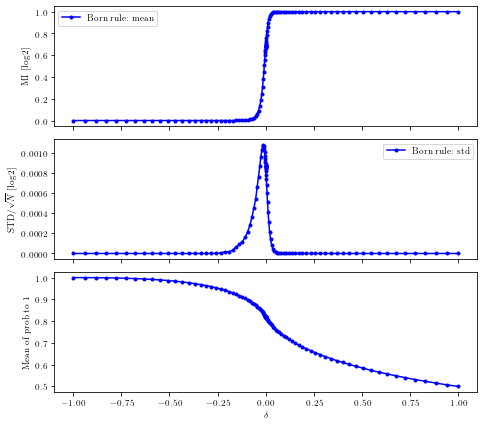

In [45]:
fig,axs=plt.subplots(3,1,figsize=(6.8,6),sharex=True,tight_layout=True)
colorlist='bgrcmyk'
ax=axs[0]
for i,color in zip(delta_dict_para.keys(),colorlist):
    ax.plot(delta_dict_para[i],np.array(mutual_info_dis_dict_para[i]).mean(axis=1)/np.log(2),'.-',label='Born rule: mean'.format(i),color=color)

ax.legend()
# ax.set_xlabel(r'$\delta$')
ax.set_ylabel(r'MI [$\log2$]')

ax=axs[1]
for i,color in zip(delta_dict_para.keys(),colorlist):
    ax.plot(delta_dict_para[i],np.array(mutual_info_dis_dict_para[i]).std(axis=1)/np.log(2)/np.sqrt(es),'.-',label='Born rule: std'.format(i),color=color)
ax.set_ylabel(r'STD/$\sqrt{N}$ [$\log2$]')

ax.legend()

ax=axs[2]
for i,color in zip(delta_dict_para.keys(),colorlist):
    ax.plot(delta_dict_para[i],np.mean(s_history_dis_dict_para[i],axis=(1,2)),'.-',color=color)

ax.set_ylabel(r'Mean of prob to 1')

# ax=axs[3]
# for i,color in zip(delta_dict_para.keys(),colorlist):
#     ax.plot(delta_dict_para[i],np.std(s_history_dis_dict_para[i],axis=(1,2)),'.-',color=color)

# ax.set_ylabel(r'STD of prob to 1')

ax.set_xlabel(r'$\delta$')
# fig.savefig('/mnt/d/kitp/Rp_SPT/5/mutual_info_Born_En{:d}.pdf'.format(es),bbox_inches='tight')
fig.savefig('/mnt/d/kitp/Rp_SPT/13/mutual_info_Born_En{:d}.pdf'.format(es),bbox_inches='tight')


### Decompose even and odd parity

In [41]:
odd_ensemble_mean=[]
odd_ensemble_std=[]
odd_ensemble_size=[]
even_ensemble_mean=[]
even_ensemble_std=[]
even_ensemble_size=[]

odd_filter=np.array(s_history_dis_dict_para[0]).sum(axis=2)%2==1
for odd_index,MI in zip(odd_filter,mutual_info_dis_dict_para[0]):
    # MI[odd_index]
    odd_ensemble_data=np.array(MI)[odd_index]
    even_ensemble_data=np.array(MI)[~odd_index]
    if odd_ensemble_data.size<2:
        odd_ensemble_size.append(0)
        odd_ensemble_mean.append(np.nan)
        odd_ensemble_std.append(np.nan)
    else:
        odd_ensemble_size.append(odd_ensemble_data.size)
        odd_ensemble_mean.append(odd_ensemble_data.mean())
        odd_ensemble_std.append(odd_ensemble_data.std())

    if even_ensemble_data.size<2:
        even_ensemble_size.append(0)
        even_ensemble_mean.append(np.nan)
        even_ensemble_std.append(np.nan)
    else:
        even_ensemble_size.append(even_ensemble_data.size)
        even_ensemble_mean.append(even_ensemble_data.mean())
        even_ensemble_std.append(even_ensemble_data.std())   

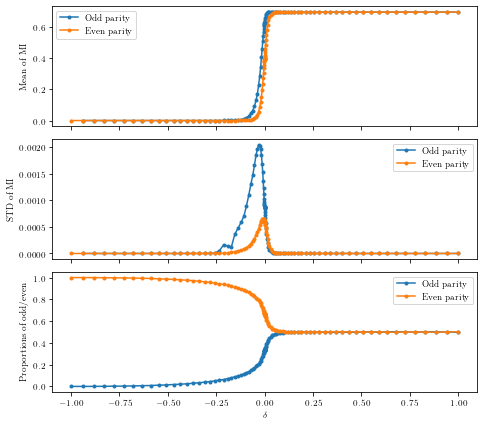

In [44]:
fig,axs=plt.subplots(3,1,figsize=(6.8,6),sharex=True)
ax=axs[0]
ax.plot(delta_dict_para[0],odd_ensemble_mean,'.-',label='Odd parity')
ax.plot(delta_dict_para[0],even_ensemble_mean,'.-',label='Even parity')
ax.set_ylabel('Mean of MI')
ax.legend()

ax=axs[1]
ax.plot(delta_dict_para[0],odd_ensemble_std/np.sqrt(odd_ensemble_size),'.-',label='Odd parity')
ax.plot(delta_dict_para[0],even_ensemble_std/np.sqrt(even_ensemble_size),'.-',label='Even parity')
ax.set_ylabel('STD of MI')
ax.legend()

ax=axs[2]
ax.plot(delta_dict_para[0],np.array(odd_ensemble_size)/es,'.-',label='Odd parity')
ax.plot(delta_dict_para[0],np.array(even_ensemble_size)/es,'.-',label='Even parity')
ax.set_ylabel('Proportions of odd/even')
ax.legend()


ax.set_xlabel(r'$\delta$')
fig.tight_layout()
# fig.savefig('/mnt/d/kitp/Rp_SPT/5/mutual_info_Born_En{:d}_L64_Parity.pdf'.format(es),bbox_inches='tight')

In [ ]:
es=100000
with open('/mnt/d/kitp/Rp_SPT/5/mutual_info_Born_En{:d}_L68.pickle'.format(es),'rb') as f:
    delta_dict_para,mutual_info_dis_dict_para,s_history_dis_dict_para=pickle.load(f)

In [ ]:
odd_ensemble_mean_=[]
odd_ensemble_std=[]
odd_ensemble_size=[]
even_ensemble_mean=[]
even_ensemble_std=[]
even_ensemble_size=[]

odd_filter=np.array(s_history_dis_dict_para[0]).sum(axis=2)%2==1
for odd_index,MI in zip(odd_filter,mutual_info_dis_dict_para[0]):
    # MI[odd_index]
    odd_ensemble_data=np.array(MI)[odd_index]
    even_ensemble_data=np.array(MI)[~odd_index]
    if odd_ensemble_data.size<2:
        odd_ensemble_size.append(0)
        odd_ensemble_mean_.append(np.nan)
        odd_ensemble_std.append(np.nan)
    else:
        odd_ensemble_size.append(odd_ensemble_data.size)
        odd_ensemble_mean_.append(odd_ensemble_data.mean())
        odd_ensemble_std.append(odd_ensemble_data.std())

    if even_ensemble_data.size<2:
        even_ensemble_size.append(0)
        even_ensemble_mean.append(np.nan)
        even_ensemble_std.append(np.nan)
    else:
        even_ensemble_size.append(even_ensemble_data.size)
        even_ensemble_mean.append(even_ensemble_data.mean())
        even_ensemble_std.append(even_ensemble_data.std()) 

In [ ]:
fig,axs=plt.subplots(3,1,figsize=(6.8,6),sharex=True)
ax=axs[0]
ax.plot(delta_dict_para[0],odd_ensemble_mean,'.-',label='Odd parity')
ax.plot(delta_dict_para[0],even_ensemble_mean,'.-',label='Even parity')
ax.set_ylabel('Mean of MI')
ax.legend()

ax=axs[1]
ax.plot(delta_dict_para[0],odd_ensemble_std,'.-',label='Odd parity')
ax.plot(delta_dict_para[0],even_ensemble_std,'.-',label='Even parity')
ax.set_ylabel('STD of MI')
ax.legend()

ax=axs[2]
ax.plot(delta_dict_para[0],np.array(odd_ensemble_size)/es,'.-',label='Odd parity')
ax.plot(delta_dict_para[0],np.array(even_ensemble_size)/es,'.-',label='Even parity')
ax.set_ylabel('Proportions of odd/even')
ax.legend()


ax.set_xlabel(r'$\delta$')
fig.tight_layout()
fig.savefig('/mnt/d/kitp/Rp_SPT/5/mutual_info_Born_En{:d}_L68_Parity.pdf'.format(es),bbox_inches='tight')

In [ ]:
es=100000
with open('/mnt/d/kitp/Rp_SPT/5/mutual_info_Born_En{:d}_alternating.pickle'.format(es),'rb') as f:
    delta_dict_e2,mutual_info_dis_dict_e2,s_history_dis_dict_e2=pickle.load(f)

In [ ]:
odd_ensemble_mean_e2=[]
odd_ensemble_std_e2=[]
odd_ensemble_size_e2=[]
even_ensemble_mean_e2=[]
even_ensemble_std_e2=[]
even_ensemble_size_e2=[]

odd_filter=np.array(s_history_dis_dict_e2[0]).sum(axis=2)%2==1
for odd_index,MI in zip(odd_filter,mutual_info_dis_dict_e2[0]):
    # MI[odd_index]
    odd_ensemble_data=np.array(MI)[odd_index]
    even_ensemble_data=np.array(MI)[~odd_index]
    if odd_ensemble_data.size<2:
        odd_ensemble_size_e2.append(0)
        odd_ensemble_mean_e2.append(np.nan)
        odd_ensemble_std_e2.append(np.nan)
    else:
        odd_ensemble_size_e2.append(odd_ensemble_data.size)
        odd_ensemble_mean_e2.append(odd_ensemble_data.mean())
        odd_ensemble_std_e2.append(odd_ensemble_data.std())

    if even_ensemble_data.size<2:
        even_ensemble_size_e2.append(0)
        even_ensemble_mean_e2.append(np.nan)
        even_ensemble_std_e2.append(np.nan)
    else:
        even_ensemble_size_e2.append(even_ensemble_data.size)
        even_ensemble_mean_e2.append(even_ensemble_data.mean())
        even_ensemble_std_e2.append(even_ensemble_data.std()) 

In [ ]:
fig,axs=plt.subplots(3,1,figsize=(6.8,6),sharex=True)
ax=axs[0]
ax.plot(delta_dict_alter[0],odd_ensemble_mean_alter,'.-',label='Odd parity')
ax.plot(delta_dict_alter[0],even_ensemble_mean_alter,'.-',label='Even parity')
ax.set_ylabel('Mean of MI')
ax.legend()

ax=axs[1]
ax.plot(delta_dict_alter[0],odd_ensemble_std_alter,'.-',label='Odd parity')
ax.plot(delta_dict_alter[0],even_ensemble_std_alter,'.-',label='Even parity')
ax.set_ylabel('STD of MI')
ax.legend()

ax=axs[2]
ax.plot(delta_dict_alter[0],np.array(odd_ensemble_size_alter)/es,'.-',label='Odd parity')
ax.plot(delta_dict_alter[0],np.array(even_ensemble_size_alter)/es,'.-',label='Even parity')
ax.set_ylabel('Proportions of odd/even')
ax.legend()


ax.set_xlabel(r'$\delta$')
fig.tight_layout()
# fig.savefig('/mnt/d/kitp/Rp_SPT/5/mutual_info_Born_En{:d}_L68_Parity.pdf'.format(es),bbox_inches='tight')

In [ ]:
es=100000
with open('/mnt/d/kitp/Rp_SPT/5/mutual_info_Born_En{:d}_e3.pickle'.format(es),'rb') as f:
    delta_dict_e3,mutual_info_dis_dict_e3,s_history_dis_dict_e3=pickle.load(f)

In [ ]:
odd_ensemble_mean_e3=[]
odd_ensemble_std_e3=[]
odd_ensemble_size_e3=[]
even_ensemble_mean_e3=[]
even_ensemble_std_e3=[]
even_ensemble_size_e3=[]

odd_filter=np.array(s_history_dis_dict_e3[0]).sum(axis=2)%2==1
for odd_index,MI in zip(odd_filter,mutual_info_dis_dict_e3[0]):
    # MI[odd_index]
    odd_ensemble_data=np.array(MI)[odd_index]
    even_ensemble_data=np.array(MI)[~odd_index]
    if odd_ensemble_data.size<2:
        odd_ensemble_size_e3.append(0)
        odd_ensemble_mean_e3.append(np.nan)
        odd_ensemble_std_e3.append(np.nan)
    else:
        odd_ensemble_size_e3.append(odd_ensemble_data.size)
        odd_ensemble_mean_e3.append(odd_ensemble_data.mean())
        odd_ensemble_std_e3.append(odd_ensemble_data.std())

    if even_ensemble_data.size<2:
        even_ensemble_size_e3.append(0)
        even_ensemble_mean_e3.append(np.nan)
        even_ensemble_std_e3.append(np.nan)
    else:
        even_ensemble_size_e3.append(even_ensemble_data.size)
        even_ensemble_mean_e3.append(even_ensemble_data.mean())
        even_ensemble_std_e3.append(even_ensemble_data.std()) 

In [ ]:
fig,axs=plt.subplots(3,1,figsize=(6.8,6),sharex=True)
ax=axs[0]
ax.plot(delta_dict_e3[0],odd_ensemble_mean_e3,'.-',label='Odd parity')
ax.plot(delta_dict_e3[0],even_ensemble_mean_e3,'.-',label='Even parity')
ax.set_ylabel('Mean of MI')
ax.legend()

ax=axs[1]
ax.plot(delta_dict_e3[0],odd_ensemble_std_e3,'.-',label='Odd parity')
ax.plot(delta_dict_e3[0],even_ensemble_std_e3,'.-',label='Even parity')
ax.set_ylabel('STD of MI')
ax.legend()

ax=axs[2]
ax.plot(delta_dict_e3[0],np.array(odd_ensemble_size_e3)/es,'.-',label='Odd parity')
ax.plot(delta_dict_e3[0],np.array(even_ensemble_size_e3)/es,'.-',label='Even parity')
ax.set_ylabel('Proportions of odd/even')
ax.legend()


ax.set_xlabel(r'$\delta$')
fig.tight_layout()
# fig.savefig('/mnt/d/kitp/Rp_SPT/5/mutual_info_Born_En{:d}_L68_Parity.pdf'.format(es),bbox_inches='tight')

In [ ]:
fig,ax=plt.subplots()
ax.plot(delta_dict_para[0],np.array(odd_ensemble_mean),'-',label='Odd parity:')
ax.plot(delta_dict_para[0],np.array(even_ensemble_mean),'-',label='Even parity:')
ax.plot(delta_dict_para[0],np.array(odd_ensemble_mean_alter),'-',label='Odd parity: every two')
ax.plot(delta_dict_para[0],np.array(even_ensemble_mean_alter),'-',label='Even parity: every two')
ax.plot(delta_dict_para[0],np.array(odd_ensemble_mean_e3),'-',label='Odd parity: every three')
ax.plot(delta_dict_para[0],np.array(even_ensemble_mean_e3),'-',label='Even parity: every three')

ax.legend()

# ax.plot(delta_dict_para[0],np.array(odd_ensemble_std)-np.array(odd_ensemble_std_alter),'-',label='Odd parity:')
# ax.plot(delta_dict_para[0],np.array(even_ensemble_std)-np.array(even_ensemble_std_alter),'-',label='Even parity:')

# ax.plot(delta_dict_para[0],np.array(odd_ensemble_std),'-',label='Odd parity:')
# ax.plot(delta_dict_para[0],np.array(even_ensemble_std),'-',label='Even parity:')
# ax.plot(delta_dict_para[0],np.array(odd_ensemble_std_alter),'-',label='Odd parity:')
# ax.plot(delta_dict_para[0],np.array(even_ensemble_std_alter),'-',label='Even parity:')


# ax.plot(delta_dict_para[0],np.array(odd_ensemble_size)-np.array(odd_ensemble_size_alter),'-',label='Odd parity:')
# ax.plot(delta_dict_para[0],np.array(even_ensemble_size)-np.array(even_ensemble_size_alter),'-',label='Even parity:')

# ax.plot(delta_dict_para[0],np.array(odd_ensemble_size),'-',label='Odd parity:')
# ax.plot(delta_dict_para[0],np.array(even_ensemble_size),'-',label='Even parity:')
# ax.plot(delta_dict_para[0],np.array(odd_ensemble_size_alter),'-',label='Odd parity:')
# ax.plot(delta_dict_para[0],np.array(even_ensemble_size_alter),'-',label='Even parity:')
# ax.plot(delta_dict_para[0],np.array(odd_ensemble_size_e3),'-',label='Odd parity:')
# ax.plot(delta_dict_para[0],np.array(even_ensemble_size_e3),'-',label='Even parity:')




In [ ]:
1+1

In [ ]:
mutual_info_dis_dict_para.keys()

In [ ]:
mutual_info_dis_dict_para
mutual_info_dis_dict_e2
mutual_info_dis_dict_e3

In [ ]:
wrap_dict={}

In [ ]:
for i,data in enumerate((mutual_info_dis_dict_para,mutual_info_dis_dict_e2,mutual_info_dis_dict_e3)):
    wrap_dict[i]={}
    wrap_dict[i]['mean']=np.array(data[0]).mean(axis=1)/np.log(2)
    wrap_dict[i]['std']=np.array(data[0]).std(axis=1)/np.log(2)
wrap_dict['delta']=delta_dict_para[0]

In [ ]:
with open('/mnt/d/kitp/Rp_SPT/5/order.pickle','wb') as f:
    pickle.dump(wrap_dict,f)

In [ ]:
with open('/mnt/d/kitp/Rp_SPT/5/order.pickle','rb') as f:
    wrap_dict=pickle.load(f)

In [ ]:
np.max(wrap_dict[0]['mean']-wrap_dict[1]['mean'])

In [ ]:
zz=np.array(mutual_info_dis_dict_para[0]).mean(axis=1)/np.log(2)

In [ ]:
xx=delta_dict_para[0]

In [ ]:
fig,axs=plt.subplots(2,1,figsize=(6.8,6.8),sharex=True,tight_layout=True)
colorlist='bgrcmyk'
labellist=['Sequential','Every 2','Every 3']
ax=axs[0]
for i,color,label in zip(range(3),colorlist,labellist):
    ax.plot(wrap_dict['delta'],wrap_dict[i]['mean'],color=color,label=label)

ax.legend()
ax.set_ylabel(r'MI between A and B [$\log2$]')


ax=axs[1]
for i,color,label in zip(range(3),colorlist,labellist):
    ax.plot(wrap_dict['delta'],wrap_dict[i]['std'],color=color,label=label)

ax.legend()
ax.set_ylabel(r'STD of MI between A and B [$\log2$]')

ax.set_xlabel(r'$\delta$')
fig.savefig('/mnt/d/kitp/Rp_SPT/5/mutual_info_Born_En100000_order.pdf',bbox_inches='tight')


In [ ]:
params=Params(delta=.5,L=64,T=0,bc=-1,basis='m')

In [ ]:
params.measure_all_Born(order='alternating')

In [ ]:
params.i_history

In [ ]:
plist=np.mean(s_history_dis_dict_para[0],axis=(1,2))

In [ ]:
paritylist=(1-(1-2*plist)**16)/2

In [ ]:
paritylist2=(1-(1-2*plist)**)/2

In [ ]:
plt.plot(delta_dict_para[0])

In [ ]:
plt.plot(delta_dict_para[0],paritylist)
# plt.plot(delta_dict_para[0],paritylist2)
# plt.plot(delta_dict_para[0],np.mean(s_history_dis_dict_para[0],axis=(1,2)))
plt.plot(delta_dict_para[0],np.array(odd_ensemble_size)/es,'.-',label='Odd parity')



In [ ]:
L=16
ensemble={}
prob_list=np.linspace(0,1,100)
for prob in prob_list:
    ensemble[prob]=[]
    for _ in range(10000):
        ensemble[prob].append(np.sum(np.random.rand(L)>prob)%2)

In [ ]:
prob_odd=[np.mean(ensemble[prob]) for prob in prob_list]

In [ ]:
paritylist=(1-(1-2*prob_list)**16)/2

In [ ]:
plt.plot(prob_list,prob_odd)
plt.plot(prob_list,paritylist)

In [ ]:
params=Params(delta=.5,L=64,T=0,bc=-1,basis='m')

In [ ]:
params.covariance_matrix_m()

In [ ]:
(1-params.C_m_history[-1][0,1])/2

In [ ]:
plt.plot([(1-params.C_m_history[-1][0+x,1+x])/2 for x in np.arange(0,128,2)])

In [ ]:
params.measure(1,0+50,1+50)

In [ ]:
(1-params.C_m_history[-1][0+2,1+2])/2

In [ ]:
plt.plot([(1-params.C_m_history[-1][0+x,1+x])/2 for x in np.arange(0,128,2)],'.-')

# Data collapse

In [323]:
def loss(delta_list,L_list,MI_list,nu):
    assert (MI_list).shape==(L_list.shape[0],delta_list.shape[1]),'dimension wrong ({:d},{:d}) != ({:d},{:d})'.format((MI_list).shape[0],(MI_list).shape[1],L_list.shape[0],delta_list.shape[1])
    # delta_expand_list=np.array([delta*nu for delta,L in zip(delta_list,L_list)])
    delta_expand_list=np.array([delta*L**nu for delta,L in zip(delta_list,L_list)])
    func=[scipy.interpolate.interp1d(delta_expand,MI) for delta_expand,MI in zip(delta_expand_list,MI_list)]
    delta_expand_max_list=[delta_expand.max() for delta_expand in delta_expand_list]
    delta_expand_min_list=[delta_expand.min() for delta_expand in delta_expand_list]
    
    x_sample_list=np.linspace(np.min(delta_expand_min_list),np.max(delta_expand_max_list),101)
    loss_sum=0
    for x_sample in x_sample_list:
        y_sample=[]
        for L_i,L in enumerate(L_list):
            if x_sample<=delta_expand_max_list[L_i] and x_sample>=delta_expand_min_list[L_i]:
                y_sample.append(func[L_i](x_sample))
        y_sample=np.array(y_sample)
        y_sample_mean=np.mean(y_sample)
        loss_sum+=np.sum((y_sample-y_sample_mean)**2)
    return loss_sum
    

In [25]:
def run(p):
    delta,dmax,LA,delta_i,L_i=p
    params=Params(delta=delta,L=np.inf,bc=-1,dmax=(2*LA+dmax)*2,basis='f')
    x=np.array([0,LA,LA+dmax,2*LA+dmax])
    eta=cross_ratio(x,np.inf)
    subA=np.arange(x[0],x[1])
    subB=np.arange(x[2],x[3])
    subAp=np.arange(x[1],x[2])
    MI0=params.mutual_information_m(subA,subB)
    params.measure_all_Born(prob=0,proj_range=subAp)
    # MI=params.von_Neumann_entropy_m(subA)
    MI1=params.mutual_information_m(subA,subB)
    # MI1=0
    # MI=params.log_neg(subA,subB)
    return eta,dmax,delta,MI0,MI1,delta_i,L_i

In [34]:
delta_list=np.linspace(-.1,.1,101)
# delta_list=np.array([0])
L_list=np.arange(16,64+1,16)
LA_list=[L for L in L_list]
MI0_list=np.zeros((L_list.shape[0],delta_list.shape[0]))
MI1_list=np.zeros((L_list.shape[0],delta_list.shape[0]))
eta_list=np.zeros((L_list.shape[0],delta_list.shape[0]))
r_list=np.zeros((L_list.shape[0],delta_list.shape[0]))
delta0_list=np.zeros((L_list.shape[0],delta_list.shape[0]))

inputs=[(delta,L,LA,delta_i,L_i) for delta_i,delta in enumerate(delta_list) for (L_i,L),LA in zip(enumerate(L_list),LA_list) ]

In [35]:
results=rc[:].map_sync(run,inputs)

In [36]:
for result in results:
    eta,r,delta,MI0,MI1,delta_i,L_i=result
    r_list[L_i,delta_i]=r
    delta0_list[L_i,delta_i]=delta
    eta_list[L_i,delta_i]=eta
    MI0_list[L_i,delta_i]=MI0
    MI1_list[L_i,delta_i]=MI1

In [433]:
def run_Born(p):
    delta,dmax,LA,delta_i,L_i=p
    es=50
    MI_list=[]
    for _ in range(es):
        params=Params(delta=delta,L=np.inf,bc=-1,dmax=(2*LA+dmax)*2,basis='f')
        x=np.array([0,LA,LA+dmax,2*LA+dmax])
        eta=cross_ratio(x,np.inf)
        subA=np.arange(x[0],x[1])
        subB=np.arange(x[2],x[3])
        subAp=np.arange(x[1],x[2])
        params.measure_all_Born(proj_range=subAp)
        # MI=params.von_Neumann_entropy_m(subA)
        MI1=params.mutual_information_m(subA,subB)
        # MI1=0
        # MI=params.log_neg(subA,subB)
        MI_list.append(MI1)
    MI=np.array(MI_list)
    return eta,dmax,delta,MI,delta_i,L_i

In [437]:
MI1_map=np.zeros((L_list.shape[0],delta_list.shape[0],50))

In [434]:
delta_list=np.linspace(-.1,.1,101)
# delta_list=np.array([0])
L_list=np.arange(16,64+1,16)
LA_list=[L for L in L_list]
# MI0_list=np.zeros((L_list.shape[0],delta_list.shape[0]))
MI1_map=np.zeros((L_list.shape[0],delta_list.shape[0],50))
eta_list=np.zeros((L_list.shape[0],delta_list.shape[0]))
r_list=np.zeros((L_list.shape[0],delta_list.shape[0]))
delta0_list=np.zeros((L_list.shape[0],delta_list.shape[0]))
inputs=[(delta,L,LA,delta_i,L_i) for delta_i,delta in enumerate(delta_list) for (L_i,L),LA in zip(enumerate(L_list),LA_list)]

In [435]:
results=rc[:].map_sync(run_Born,inputs)

In [438]:
for result in results:
    eta,r,delta,MI1,delta_i,L_i=result
    r_list[L_i,delta_i]=r
    delta0_list[L_i,delta_i]=delta
    eta_list[L_i,delta_i]=eta
    MI1_map[L_i,delta_i,:]=MI1
MI1_list=MI1_map.mean(axis=2)

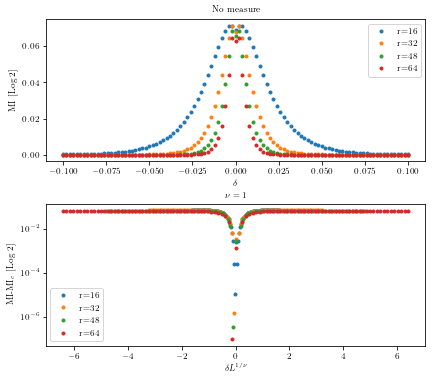

In [37]:
fig,axs=plt.subplots(2,1,figsize=(6.8,6),gridspec_kw=dict(hspace=0.3))
ax=axs[0]
for index,r in enumerate(L_list):
    ax.plot((delta0_list[index]),(MI0_list[index])/np.log(2),'.',label='r={:d}'.format(r))
ax.set_xlabel('$\delta$')
ax.set_ylabel('MI [Log 2]')
ax.legend()
ax.set_title(r'No measure')


ax=axs[1]

for index,r in enumerate(L_list):
    ax.plot((delta0_list[index])*r**(1.),np.abs(MI0_list[index]-np.max(MI0_list[index]))/np.log(2),'.',label='r={:d}'.format(r))
ax.set_yscale('log')
ax.set_xlabel(r'$\delta L^{1/\nu}$')
ax.set_ylabel('MI-MI$_c$ [Log 2]')
ax.set_title(r'$\nu=1$')
ax.legend()
fig.savefig('/mnt/d/KITP/Rp_SPT/6/collapse_no.pdf')

In [365]:
MI_map=[MI0_list[index]-np.max(MI0_list[index]) for index in range(L_list.shape[0])]

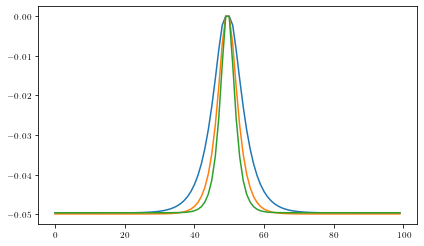

In [366]:
plt.plot(np.transpose(MI_map))

In [393]:
nu_list=np.linspace(0,2,51)
loss_list=[loss(delta0_list[:],L_list,([MI0_list[index]-np.max(MI0_list[index]) for index in range(L_list.shape[0])])/np.log(2),nu) for nu in nu_list]

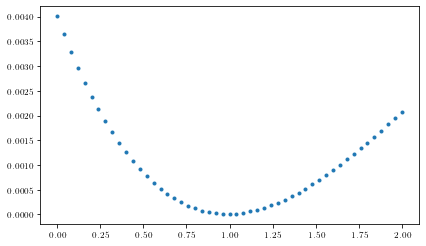

In [370]:
plt.plot(nu_list,loss_list,'.')

In [444]:
nu_list[np.argmin(loss_list)]

1.21

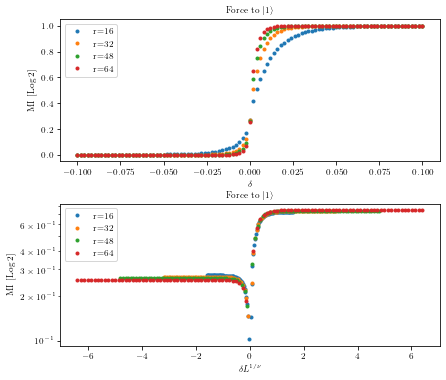

In [39]:
fig,axs=plt.subplots(2,1,figsize=(6.8,6),gridspec_kw=dict(hspace=0.3))
ax=axs[0]
for index,r in enumerate(L_list):
    ax.plot(delta0_list[index,:delta0_list.shape[1]],MI1_list[index,:delta0_list.shape[1]]/np.log(2),'.',label='r={:d}'.format(r),)
ax.set_xlabel('$\delta$')
ax.set_ylabel('MI [Log 2]')
ax.legend()
ax.set_title(r'Force to $|1\rangle$')
ax=axs[1]
for index,r in enumerate(L_list):
    ax.plot(delta0_list[index,:delta0_list.shape[1]]*r**1.,np.abs(MI1_list[index,:delta0_list.shape[1]]-MI1_list[index,delta0_list.shape[1]//2])/np.log(2),'.',label='r={:d}'.format(r))
ax.set_yscale('log')
ax.set_xlabel(r'$\delta L^{1/\nu}$')
ax.set_ylabel('MI [Log 2]')
ax.set_title(r'$\nu=1$')
ax.legend()
ax.set_title(r'Force to $|1\rangle$')
fig.savefig('/mnt/d/KITP/Rp_SPT/6/collapse_force_1.pdf')

In [6]:
with open('/mnt/d/KITP/Rp_SPT/6/Majorana_Born_es1000.pickle','rb') as f:
    [delta_list,L_list,MI_list]=pickle.load(f)
MI1_list=MI_list.mean(axis=2)

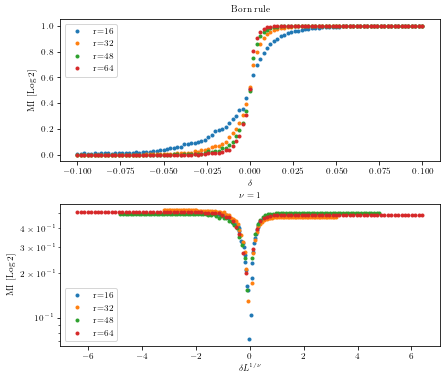

In [10]:
fig,axs=plt.subplots(2,1,figsize=(6.8,6),gridspec_kw=dict(hspace=0.3))
ax=axs[0]
for index,r in enumerate(L_list):
    ax.plot(delta_list,MI1_list[index]/np.log(2),'.',label='r={:d}'.format(r),)
ax.set_xlabel('$\delta$')
ax.set_ylabel('MI [Log 2]')
ax.legend()
ax.set_title(r'Born rule')
ax=axs[1]
for index,r in enumerate(L_list):
    ax.plot(delta_list*r**1.,np.abs(MI1_list[index]-MI1_list[index,MI1_list.shape[1]//2])/np.log(2),'.',label='r={:d}'.format(r))
ax.set_yscale('log')
ax.set_xlabel(r'$\delta L^{1/\nu}$')
ax.set_ylabel('MI [Log 2]')
ax.set_title(r'$\nu=1$')
ax.legend()

fig.savefig('/mnt/d/KITP/Rp_SPT/6/collapse_Born.pdf')

In [454]:
nu_list=np.linspace(0.5,1.5,101)
loss_list=[loss(delta0_list[1:,:delta0_list.shape[1]],L_list[1:],MI1_list[1:,:delta0_list.shape[1]]/np.log(2),nu) for nu in nu_list]

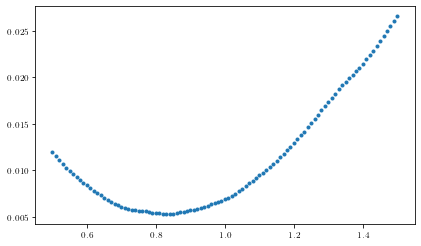

In [455]:
plt.plot(nu_list,loss_list,'.')

In [251]:
nu_list[np.argmin(loss_list)]

1.59

In [478]:
# delta_list=np.linspace(-.1,.1,100)
delta_list=np.array([0])
L_list=np.arange(16,100+1)
LA_list=[100 for L in L_list]
MI0_list=np.zeros((L_list.shape[0],delta_list.shape[0]))
MI1_list=np.zeros((L_list.shape[0],delta_list.shape[0]))
eta_list=np.zeros((L_list.shape[0],delta_list.shape[0]))
r_list=np.zeros((L_list.shape[0],delta_list.shape[0]))
delta0_list=np.zeros((L_list.shape[0],delta_list.shape[0]))

inputs=[(delta,L,LA,delta_i,L_i) for delta_i,delta in enumerate(delta_list) for (L_i,L),LA in zip(enumerate(L_list),LA_list) ]
results=rc[:].map_sync(run,inputs)
for result in results:
    eta,r,delta,MI0,MI1,delta_i,L_i=result
    r_list[L_i,delta_i]=r
    delta0_list[L_i,delta_i]=delta
    eta_list[L_i,delta_i]=eta
    MI0_list[L_i,delta_i]=MI0
    MI1_list[L_i,delta_i]=MI1

In [462]:
eta_list.shape

(49, 1)

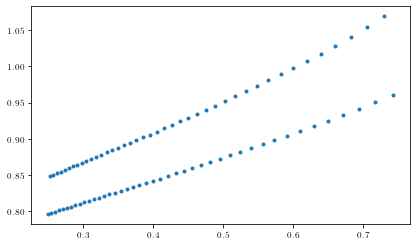

In [481]:
fig,ax=plt.subplots()
ax.plot(eta_list[:,0],MI1_list[:,0],'.')
# ax.set_xscale('log')
# ax.set_yscale('log')

In [482]:
lr_even=scipy.stats.linregress(np.log(eta_list[::2,0]),np.log(MI1_list[::2,0]))
lr_odd=scipy.stats.linregress(np.log(eta_list[1::2,0]),np.log(MI1_list[1::2,0]))

In [483]:
[lr_even.slope,lr_odd.slope]

[0.1639187995437526, 0.20588248260143868]

In [484]:
[lr_even.rvalue,lr_odd.rvalue]

[0.9882630932618822, 0.9870130149721769]

In [7]:
params.measure_all_Born(prob=1)

In [10]:
params.von_Neumann_entropy_m(np.arange(params.L//4))

1.0386808181889196

# Logarithmic Negativity

In [ ]:
delta_list=np.linspace(-1,1,100)**3
logneg_list={}
for L in (8,16,32,64):
    logneg_list[L]=[]
    for delta in delta_list:
        params=Params(delta=delta,L=64,bc=-1)
        logneg_list[L].append(params.log_neg(np.arange(L),np.arange(L,2*params.L)))

In [ ]:
fig,ax=plt.subplots()
for k,v in logneg_list.items():
    ax.plot(delta_list,v/np.log(2),'-',label=k)
ax.grid('on')
ax.legend()
ax.set_xlabel(r'$\delta$')
ax.set_ylabel(r'log neg [log 2]')
fig.tight_layout()
fig.savefig('/mnt/d/kitp/Rp_SPT/5/Log_Neg.pdf',bbox_inches='tight')

### no measurment


In [9]:
delta_list=np.linspace(-1,1,101)**3
MI_no_list=np.zeros_like(delta_list)
LN_no_list=np.zeros_like(delta_list)
L=64
log_neg_list=[]
for delta_i,delta in enumerate(delta_list):
    params=Params(delta=delta,L=64,bc=-1)
    MI_no_list[delta_i]=(params.mutual_information_m(np.arange(params.L//4),np.arange(params.L//4)+params.L//2))
    LN_no_list[delta_i]=(params.log_neg(np.arange(params.L//4),np.arange(params.L//4)+params.L//2))

In [ ]:
# all projections to 0
log_neg_pos_list=[]
for delta in delta_list:
    params=Params(delta=delta,L=64,bc=-1)
    params.measure_all(1)
    log_neg_pos_list.append(params.log_neg(np.arange(params.L//2),np.arange(params.L//2)+L))

In [ ]:
# all projections to 1
log_neg_neg_list=[]
for delta in delta_list:
    params=Params(delta=delta,L=64,bc=-1)
    params.measure_all(0)
    log_neg_neg_list.append(params.log_neg(np.arange(params.L//2),np.arange(params.L//2)+params.L))

In [15]:
delta_list=np.linspace(-1,1,101)**3
L=64
es=500
MI_onsite_list=np.zeros((delta_list.shape[0],es))
LN_onsite_list=np.zeros((delta_list.shape[0],es))
def run(p):
    delta,L=p
    params=Params(delta=delta,L=L,bc=-1)
    params.measure_all_Born()
    MI=(params.mutual_information_m(np.arange(params.L//4),np.arange(params.L//4)+params.L//2))
    LN=(params.log_neg(np.arange(params.L//4),np.arange(params.L//4)+params.L//2))
    return MI,LN

for delta_i,delta in enumerate(delta_list):
    inputs=[(delta,L) for _ in range(es)]
    sync_results=rc[:].map_sync(run,inputs)
    for es_i,result in enumerate(sync_results):
        MI,LN=result
        MI_onsite_list[delta_i,es_i]=MI
        LN_onsite_list[delta_i,es_i]=LN

In [16]:
with open('/mnt/d/kitp/Paper_SPT/Fig/Majorana_proj.pickle','wb') as f:
    pickle.dump([delta_list,LN_no_list,LN_onsite_list,MI_no_list,MI_onsite_list,L,es],f)

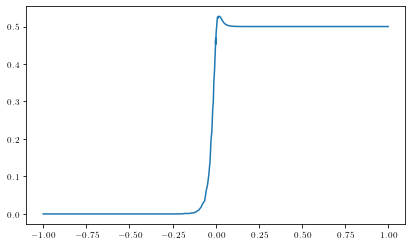

In [17]:
plt.plot(delta_list,np.mean(LN_onsite_list,1)/np.log(2))

In [ ]:
from matplotlib.patches import Rectangle

In [ ]:
fig,ax=plt.subplots()
# ax.plot(delta_list,LN_no_list,'.-',label='No measurement')

es=1000

ax.plot(delta_list,log_neg_list/np.log(2),'.-',label='No measure',color='b')

# ax.plot(delta_list,log_neg_neg_list/np.log(2),'.-',label='Measure all to s=-1 (occupied)',color='r')

# ax.errorbar(delta_list,log_neg_Born_list.mean(axis=1)/np.log(2),log_neg_Born_list.std(axis=1)/np.log(2)/np.sqrt(es-1),capsize=3,fmt='.-',label='Born rules',color='c')

ax.legend(loc=2)
ax.grid('on')
ax.set_xlabel(r'$\delta$')
ax.set_ylabel(r'log neg [log 2]')
ax.set_ylim([0,0.55])
green=Rectangle((-1,0),1,1,alpha=0.2,color='g')
yellow=Rectangle((0,0),1,1,alpha=0.2,color='y')
ax.add_patch(green)
ax.add_patch(yellow)
ax.set_xlim([-1,1])
ax.text(.2,.65,'Trivial',transform=ax.transAxes,fontsize=16,ha='center',va='bottom')
ax.text(.8,.65,'Topological',transform=ax.transAxes,fontsize=16,ha='center',va='bottom')

fig.savefig('/mnt/d/KITP/slides_SPT/Kitaev_1.png',facecolor='w',dpi=1000)

In [ ]:
fig,ax=plt.subplots()
colorlist=iter('bgrcmyk')

ax.plot(delta_list,log_neg_list/np.log(2),'.-',label='No measure',color=colorlist.__next__())
ax.plot(delta_list,log_neg_pos_list/np.log(2),'.-',label='Measure all to s=+1 (empty)',color=colorlist.__next__())
ax.plot(delta_list,log_neg_neg_list/np.log(2),'.-',label='Measure all to s=-1 (occupied)',color=colorlist.__next__())
ax.plot(delta_list,np.mean(log_neg_Born_list,1)/np.log(2),'.-',label='Born rules',color=colorlist.__next__())

ax.legend()
ax.grid('on')
ax.set_xlabel(r'$\delta$')
ax.set_ylabel(r'log neg [log 2]')
fig.tight_layout()
# fig.savefig('/mnt/d/kitp/Rp_SPT/5/Log_Neg_Measure.pdf',bbox_inches='tight')
# fig.savefig('/mnt/d/kitp/Rp_SPT/6/Log_Neg_Measure.pdf',bbox_inches='tight')



In [ ]:
delta_list[np.argmax(log_neg_pos_list)]

# Scaling behavior: Peak height and position

## Decay length at $ \delta =0 $

In [ ]:
MI_list=[]
AAp=2
d_list=np.arange(AAp+2,64,2)
for ApB in d_list:
    subregionA=np.arange(AAp)
    subregionAp=np.arange(AAp,ApB,2)
    subregionB=np.arange(ApB,ApB+2)
    params=Params(delta=0,L=256,bc=-1,basis='m')
    MI_list.append(params.mutual_information_m(subregionA,subregionB))

In [ ]:
fig,ax=plt.subplots()
ax.plot(np.log(d_list),np.log(MI_list),'.')
mask=np.log(d_list)<4.5
lr=scipy.stats.linregress(np.log(d_list)[mask],np.log(MI_list)[mask])
ax.plot(np.log(d_list),lr.slope*np.log(d_list)+lr.intercept)
ax.text(.1,.1,r'log MI={:.4f}$\log L$+{:.2f},  $R^2$={:.4f}'.format(lr.slope,lr.intercept,lr.rvalue),transform=ax.transAxes)

In [ ]:
d_list=np.arange(AAp+2,256,2)


In [ ]:
# All project to 0
MI_pos_list=[]
d_list=np.arange(AAp+2,256,2)
AAp=2
for ApB in d_list:
    subregionA=np.arange(AAp)
    subregionAp=np.arange(AAp,ApB,2)
    subregionB=np.arange(ApB,ApB+2)
    params=Params(delta=0,L=1024,bc=-1,basis='m')
    params.measure_all(1,subregionAp)
    MI_pos_list.append(params.mutual_information_m(subregionA,subregionB))

In [ ]:
fig,ax=plt.subplots()
mask=np.arange(len(d_list))[1::2]
x=np.log(np.log(d_list))[mask][:-5]
y=np.array(MI_pos_list)[mask][:-5]
ax.plot(x,y,'.')
lr=scipy.stats.linregress(x,y)
ax.plot(x,lr.slope*x+lr.intercept)
ax.text(.1,.1,r'MI={:.4f}$\log L$+{:.2f},  $R^2$={:.4f}'.format(lr.slope,lr.intercept,lr.rvalue),transform=ax.transAxes)

In [ ]:
fig,ax=plt.subplots()
mask=np.arange(len(d_list))[1::2]
x=np.log(d_list)[mask][:-5]
y=np.log((MI_pos_list))[mask][:-5]
ax.plot(x,y,'.')
lr=scipy.stats.linregress(x,y)
ax.plot(x,lr.slope*x+lr.intercept)
ax.text(.1,.1,r'MI={:.4f}$\log L$+{:.2f},  $R^2$={:.4f}'.format(lr.slope,lr.intercept,lr.rvalue),transform=ax.transAxes)

In [ ]:
fig,ax=plt.subplots()
mask=np.arange(len(d_list))[:]
x=np.log(d_list)[mask][:-5]
y=np.log((MI_pos_list))[mask][:-5]
ax.plot(x,y,'.')


In [ ]:
x_0

In [ ]:
fig,axs=plt.subplots(3,1,figsize=(6.8,8))
mask_0=np.arange(len(d_list))[::2]
mask_1=np.arange(len(d_list))[1::2]
ax=axs[0]
x_0=np.array(d_list)[mask_0][:-5]
x_1=np.array(d_list)[mask_1][:-5]

y_0=np.array((MI_pos_list))[mask_0][:-5]
y_1=np.array((MI_pos_list))[mask_1][:-5]

ax.plot(x_0,y_0/np.log(2),'.',color='b',label='Dist = even ferimoin sites')
ax.plot(x_1,y_1/np.log(2),'.',color='r',label='Dist = odd ferimoin sites')
ax.legend()

ax.set_xlabel(r'L')
ax.set_ylabel('MI [log 2]')
ax.text(.5,1,'Measure all to +1',ha='center',va='bottom',transform=ax.transAxes)

ax=axs[1]
mask=np.arange(len(d_list))[1::2]
x=np.log(d_list)[mask][:-5]
y=np.log((MI_pos_list))[mask][:-5]
ax.plot(x,y,'.')
lr=scipy.stats.linregress(x,y)
ax.plot(x,lr.slope*x+lr.intercept)
ax.text(.1,.1,r'log MI={:.4f}$\log L$+{:.2f},  $R^2$={:.4f}'.format(lr.slope,lr.intercept,lr.rvalue),transform=ax.transAxes)
ax.set_xlabel(r'log L')
ax.set_ylabel('log MI')

ax=axs[2]
mask=np.arange(len(d_list))[0::2]
x=np.log(d_list)[mask][:-5]
y=np.log((MI_pos_list))[mask][:-5]
ax.plot(x,y,'.')
lr=scipy.stats.linregress(x,y)
ax.plot(x,lr.slope*x+lr.intercept)
ax.text(.1,.1,r'log MI={:.4f}$\log L$+{:.2f},  $R^2$={:.4f}'.format(lr.slope,lr.intercept,lr.rvalue),transform=ax.transAxes)
ax.set_xlabel(r'log L')
ax.set_ylabel('log MI')

fig.tight_layout()

fig.savefig('/mnt/d/kitp/Rp_SPT/5/MI_delta0_dist_pos.pdf',bbox_inches='tight')

In [ ]:
fig,ax=plt.subplots()
mask=np.arange(len(d_list))[1::2]
x=np.log(d_list)[mask][:-5]
y=np.log((MI_pos_list))[mask][:-5]
ax.plot(x,y,'.')
lr=scipy.stats.linregress(x,y)
ax.plot(x,lr.slope*x+lr.intercept)
ax.text(.1,.1,r'MI={:.4f}$\log L$+{:.2f},  $R^2$={:.4f}'.format(lr.slope,lr.intercept,lr.rvalue),transform=ax.transAxes)
ax.set_xlabel(r'log $\delta$')
ax.set_ylabel('log MI')


In [ ]:
# All project to 0
MI_neg_list=[]
d_list=np.arange(AAp+2,64,2)
AAp=2
for ApB in d_list:
    subregionA=np.arange(AAp)
    subregionAp=np.arange(AAp,ApB,2)
    subregionB=np.arange(ApB,ApB+2)
    params=Params(delta=0,L=256,bc=-1,basis='m')
    params.measure_all(0,subregionAp)
    MI_neg_list.append(params.mutual_information_m(subregionA,subregionB))

In [ ]:
fig,ax=plt.subplots()
ax.plot(np.log(d_list),np.log(MI_neg_list),'.')
mask=np.log(d_list)<3.5
lr=scipy.stats.linregress(np.log(d_list)[mask],np.log(MI_neg_list)[mask])
ax.plot(np.log(d_list),lr.slope*np.log(d_list)+lr.intercept)
ax.text(.1,.1,r'log MI={:.4f}$\log L$+{:.2f},  $R^2$={:.4f}'.format(lr.slope,lr.intercept,lr.rvalue),transform=ax.transAxes)

In [ ]:
fig,axs=plt.subplots(2,1,sharex=True,figsize=(6.8,6))
ax=axs[0]
ax.plot(np.log(d_list),np.log(MI_list),'.')
mask=np.log(d_list)<4.5
lr=scipy.stats.linregress(np.log(d_list)[mask],np.log(MI_list)[mask])
ax.plot(np.log(d_list),lr.slope*np.log(d_list)+lr.intercept)
ax.text(.1,.1,r'log MI={:.4f}$\log L$+{:.2f},  $R^2$={:.4f}'.format(lr.slope,lr.intercept,lr.rvalue),transform=ax.transAxes)
ax.set_ylabel('log MI')
ax.text(0.5,1,'No measurement',ha='center',va='bottom',transform=ax.transAxes)
ax=axs[1]
ax.plot(np.log(d_list),np.log(MI_neg_list),'.')
mask=np.log(d_list)<3.5
lr=scipy.stats.linregress(np.log(d_list)[mask],np.log(MI_neg_list)[mask])
ax.plot(np.log(d_list),lr.slope*np.log(d_list)+lr.intercept)
ax.text(.1,.1,r'log MI={:.4f}$\log L$+{:.2f},  $R^2$={:.4f}'.format(lr.slope,lr.intercept,lr.rvalue),transform=ax.transAxes)
ax.text(0.5,1,'Measure all to -1',ha='center',va='bottom',transform=ax.transAxes)

ax.set_xlabel(r'$\log L$')
ax.set_ylabel('log MI')
fig.tight_layout()

fig.savefig('/mnt/d/kitp/Rp_SPT/5/MI_delta0_dist.pdf',bbox_inches='tight')

## Scale as a function of dist between A & B

In [ ]:
# no measurement
mutual_info_list={}
delta_list=np.linspace(-1,1,300)**5
AAp=2
for ApB in np.arange(AAp+2,64,2):
    mutual_info_list[ApB]=[]

    for delta in delta_list:
        params=Params(delta=delta,L=64,bc=-1)
        subregionA=np.arange(AAp)
        subregionAp=np.arange(AAp,ApB,2)
        subregionB=np.arange(ApB,ApB+2)
        # subregionBp=np.arange(ApB+32,2*params.L,2)
        # params.measure_all(1,subregionAp)
        # params.measure_all(1,subregionBp)
        mutual_info_list[ApB].append(params.mutual_information_m(subregionA,subregionB))

In [ ]:
mutual_info_pos_list={}

In [ ]:
# all projections to 0
delta_list=np.linspace(-1,1,300)**5
AAp=2
for ApB in np.arange(AAp+2,64,2):
    mutual_info_pos_list[ApB]=[]

    for delta in delta_list:
        params=Params(delta=delta,L=64,bc=-1)
        subregionA=np.arange(AAp)
        subregionAp=np.arange(AAp,ApB,2)
        subregionB=np.arange(ApB,ApB+2)
        # subregionBp=np.arange(ApB+32,2*params.L,2)
        params.measure_all(1,subregionAp)
        # params.measure_all(1,subregionBp)
        mutual_info_pos_list[ApB].append(params.mutual_information_m(subregionA,subregionB))

In [ ]:
mutual_info_neg_list={}

In [ ]:
# all projections to 1
delta_list=np.linspace(-1,1,300)**5
AAp=2
for ApB in np.arange(AAp+2,64,2):
    mutual_info_neg_list[ApB]=[]

    for delta in delta_list:
        params=Params(delta=delta,L=64,bc=-1)
        subregionA=np.arange(AAp)
        subregionAp=np.arange(AAp,ApB,2)
        subregionB=np.arange(ApB,ApB+2)
        # subregionBp=np.arange(ApB+32,2*params.L,2)
        params.measure_all(0,subregionAp)
        # params.measure_all(1,subregionBp)
        mutual_info_neg_list[ApB].append(params.mutual_information_m(subregionA,subregionB))

In [ ]:
# all projections to 1
delta_list=np.linspace(-1,1,300)**5
for ApB in np.arange(34,65,2):
    mutual_info_neg_list[ApB]=[]

    for delta in delta_list:
        params=Params(delta=delta,L=64,bc=-1)
        subregionA=np.arange(32)
        subregionAp=np.arange(32,ApB,2)
        subregionB=np.arange(ApB,ApB+32)
        subregionBp=np.arange(ApB+32,2*params.L,2)
        params.measure_all(0,subregionAp)
        mutual_info_neg_list[ApB].append(params.mutual_information_m(subregionA,subregionB))

In [ ]:
ApB=64
subregionA=np.arange(32)
subregionAp=np.arange(32,ApB,2)
subregionB=np.arange(ApB,ApB+32)
subregionBp=np.arange(ApB+32,2*params.L,2)

In [ ]:
subregionAp.shape[0]*2

In [ ]:
np.arange(34,64,4)+2

In [ ]:
mutual_info_pos_list.keys()

In [ ]:
colorlist=('bgrcmyk')

In [ ]:
fig,ax=plt.subplots(2,3,figsize=(10,6),sharex=True)
colorlist=('bgrcmyk')
plotstyle='-'
for i,color in zip(np.arange(34,64,4),colorlist):
    ax[0,0].plot(delta_list,mutual_info_pos_list[i]/np.log(2),plotstyle,label=r'$L_{{AB}}={}$'.format(i),color=color)
    ax[0,1].plot(delta_list,mutual_info_neg_list[i]/np.log(2),plotstyle,label=r'$L_{{AB}}={}$'.format(i),color=color)
    ax[0,2].plot(delta_list,mutual_info_list[i]/np.log(2),plotstyle,label=r'$L_{{AB}}={}$'.format(i),color=color)

    ax[1,0].plot(delta_list,mutual_info_pos_list[i+2]/np.log(2),plotstyle,label=r'$L_{{AB}}={}$'.format(i+2),color=color)
    ax[1,1].plot(delta_list,mutual_info_neg_list[i+2]/np.log(2),plotstyle,label=r'$L_{{AB}}={}$'.format(i+2),color=color)
    ax[1,2].plot(delta_list,mutual_info_list[i+2]/np.log(2),plotstyle,label=r'$L_{{AB}}={}$'.format(i+2),color=color)


[ax.legend() for ax in ax.flatten()]
[ax.set_xlabel('$\delta$') for ax in ax[1,:]]
ax[0,0].set_ylabel('MI between A and B [log 2]')
ax[1,0].set_ylabel('MI between A and B [log 2]')

ax[0,0].text(.5,1,'Measure +1',transform=ax[0,0].transAxes,ha='center',va='bottom')
ax[0,1].text(.5,1,'Measure -1',transform=ax[0,1].transAxes,ha='center',va='bottom')
ax[0,2].text(.5,1,'No measurement',transform=ax[0,2].transAxes,ha='center',va='bottom')

fig.tight_layout()

fig.savefig('/mnt/d/kitp/Rp_SPT/5/MI_scaling_distance.pdf',bbox_inches='tight')

In [ ]:
distance_list=[]
peak_list=[]
peak_pos_list=[]
for i in np.arange(34,64,4):
# plt.plot(delta_list,mutual_info_pos_list[i+2]/np.log(2))
    peak=(mutual_info_pos_list[i+2]/np.log(2)).max()
    peak_pos=delta_list[(np.argmax(mutual_info_pos_list[i+2]/np.log(2)))]
    # print('peak: {}, peak position: {}'.format(peak,peak_pos))
    distance_list.append(i+2)
    peak_list.append(peak)
    peak_pos_list.append(peak_pos)

In [ ]:
plt.plot(distance_list,peak_list)

In [ ]:
plt.plot(distance_list,peak_pos_list)

In [ ]:
fig,ax=plt.subplots(2,1,sharex=True,figsize=(6.8,5))
ax[0].plot(distance_list,peak_list,'.-')
ax[1].plot(distance_list,peak_pos_list,'.-')
ax[0].set_ylabel(r'MI Peak height ($\log 2$)')
ax[1].set_ylabel(r'MI Peak position ($\delta$)')
ax[1].set_xlabel('Distance between subregion A and B')

fig.tight_layout()
fig.savefig('/mnt/d/kitp/Rp_SPT/5/MI_scaling_distance_peakpos.pdf',bbox_inches='tight')

## System size 

### |A|/dist = 1/2

In [ ]:
# no measurment
mutual_info_list={}
delta_list=np.linspace(-1,1,100)**3
L_list=np.arange(16,101,4)
for L in L_list:
    mutual_info_list[L]=[]
    for delta in delta_list:
        params=Params(delta=delta,L=L,bc=-1)
        mutual_info_list[L].append(params.mutual_information_m(np.arange(int(params.L/2)),np.arange(int(params.L/2))+params.L))

In [ ]:
# all projections to 0
mutual_info_pos_list={}
for L in L_list:
    mutual_info_pos_list[L]=[]
    for delta in delta_list:
        params=Params(delta=delta,L=L,bc=-1)
        params.measure_all(1)
        mutual_info_pos_list[L].append(params.mutual_information_m(np.arange(int(params.L/2)),np.arange(params.L/2)+params.L))

In [ ]:
# all projections to 1
mutual_info_neg_list={}
for L in L_list:
    mutual_info_neg_list[L]=[]
    for delta in delta_list:
        params=Params(delta=delta,L=L,bc=-1)
        params.measure_all(0)
        mutual_info_neg_list[L].append(params.mutual_information_m(np.arange(int(params.L/2)),np.arange(params.L/2)+params.L))

In [ ]:
L_list

In [ ]:
mutual_info_neg_list.keys()

In [ ]:
fig,ax=plt.subplots(2,1,figsize=(6.8,6),sharex=True)
# i=20
colorlist=('bgrcmyk')
for i,color in zip(range(16,64,8),colorlist):
    ax[0].plot(delta_list,mutual_info_list[i]/np.log(2),label=r'$L={}$'.format(i),ls='-',lw=1,color=color)
    ax[0].plot(delta_list,mutual_info_pos_list[i]/np.log(2),ls='--',lw=1,color=color)
    ax[0].plot(delta_list,mutual_info_neg_list[i]/np.log(2),ls=':',lw=1,color=color)

    # i+=2
    # ax[0,1].plot(delta_list,mutual_info_list[i]/np.log(2),label=r'$L={}$'.format(i),ls='-',lw=1,color=color)
    # ax[0,1].plot(delta_list,mutual_info_pos_list[i]/np.log(2),ls='--',lw=1,color=color)
    # ax[0,1].plot(delta_list,mutual_info_neg_list[i]/np.log(2),ls=':',lw=1,color=color)

    i+=4
    ax[1].plot(delta_list,mutual_info_list[i]/np.log(2),label=r'$L={}$'.format(i),ls='-',lw=1,color=color)
    ax[1].plot(delta_list,mutual_info_pos_list[i]/np.log(2),ls='--',lw=1,color=color)
    ax[1].plot(delta_list,mutual_info_neg_list[i]/np.log(2),ls=':',lw=1,color=color)

    # i+=2
    # ax[1,1].plot(delta_list,mutual_info_list[i]/np.log(2),label=r'$L={}$'.format(i),ls='-',lw=1,color=color)
    # ax[1,1].plot(delta_list,mutual_info_pos_list[i]/np.log(2),ls='--',lw=1,color=color)
    # ax[1,1].plot(delta_list,mutual_info_neg_list[i]/np.log(2),ls=':',lw=1,color=color)

    # ax[0,1].plot(delta_list,mutual_info_list[i+2]/np.log(2))

[ax.legend() for ax in ax.flatten()]
ax[1].set_xlabel(r'$\delta$')
[ax.set_ylabel(r'Mutual information [$\log 2$]') for ax in ax[:]]
[ax.text(-0.1,1,'({})'.format(text),ha='right',va='top',transform=ax.transAxes) for ax,text in zip(ax.flatten(),'abcd')]
fig.tight_layout()
# fig.savefig('/mnt/d/kitp/Rp_SPT/5/MI_scaling_size.pdf')

In [ ]:
fig,ax=plt.subplots()
for i,color in zip(range(16,64,8),colorlist):
    ax.plot(delta_list,mutual_info_neg_list[i]/np.log(2),ls=':',lw=1,color=color)


In [ ]:
f1=interpolate.interp1d(delta_list,mutual_info_neg_list[16]/np.log(2))
f2=interpolate.interp1d(delta_list,mutual_info_neg_list[16+8]/np.log(2))

In [ ]:
def find_intersection(delta_list,d1,d2):
    f1=interpolate.interp1d(delta_list,d1)
    f2=interpolate.interp1d(delta_list,d2)
    x=np.arange(-0.01,0.01,1e-5)
    y=f1(x)-f2(x)
    x0=x[np.argmin(np.abs(y))]
    return x0,f1(x0).item()

In [ ]:
delta0_list=[]
f0_list=[]
for i in range(16,56,8):
    x0,y0=find_intersection(delta_list,mutual_info_neg_list[i]/np.log(2),mutual_info_neg_list[i+8]/np.log(2))
    delta0_list.append(x0)
    f0_list.append(y0)

In [ ]:
plt.plot(delta0_list,f0_list)

In [ ]:
# all projections to 0
mutual_info_pos_fine_list={}
delta_list=np.linspace(-.02,.06,100)
L_list=np.arange(16,401,8)
for L in L_list:
    mutual_info_pos_fine_list[L]=[]
    for delta in delta_list:
        params=Params(delta=delta,L=L,bc=-1)
        params.measure_all(1)
        mutual_info_pos_fine_list[L].append(params.mutual_information_m(np.arange(int(params.L/2)),np.arange(params.L/2)+params.L))

In [ ]:
# all projections to 1
mutual_info_neg_fine_list={}
delta_list=np.linspace(-.02,.06,100)
L_list=np.arange(16,401,8)
for L in L_list:
    mutual_info_neg_fine_list[L]=[]
    for delta in delta_list:
        params=Params(delta=delta,L=L,bc=-1)
        params.measure_all(0)
        mutual_info_neg_fine_list[L].append(params.mutual_information_m(np.arange(int(params.L/2)),np.arange(params.L/2)+params.L))

In [ ]:
L_list=[]
peak_list=[]
peak_pos_list=[]
for i in range(16,401,8):
# plt.plot(delta_list,mutual_info_pos_list[i+2]/np.log(2))
    peak=(mutual_info_pos_fine_list[i]/np.log(2)).max()
    peak_pos=delta_list[(np.argmax(mutual_info_pos_fine_list[i]/np.log(2)))]
    # print('peak: {}, peak position: {}'.format(peak,peak_pos))
    L_list.append(i)
    peak_list.append(peak)
    peak_pos_list.append(peak_pos)

In [ ]:
fig,ax=plt.subplots(2,1,sharex=True,figsize=(6.8,5))
ax[0].plot(L_list,peak_list,'.-')
ax[1].plot(L_list,peak_pos_list,'.-')
ax[0].set_ylabel(r'MI Peak height ($\log 2$)')
ax[1].set_ylabel(r'MI Peak position ($\delta$)')
ax[1].set_xlabel('L')

fig.tight_layout()
fig.savefig('/mnt/d/kitp/Rp_SPT/5/MI_scaling_size_peakpos.pdf',bbox_inches='tight')

In [ ]:
len(peak_list)

In [ ]:
fig,ax=plt.subplots()
ax.plot(np.log(L_list),(peak_list),'.',marker='x')
ax.set_xlabel('log L')
ax.set_ylabel(r'MI Peak height ($\log 2$)')
lr=scipy.stats.linregress(np.log(L_list),(peak_list))
ax.plot(np.log(L_list),lr.slope*np.log(L_list)+lr.intercept)
ax.text(.1,.8,r'MI={:.4f}$\log L$+{:.2f},  $R^2$={:.4f}'.format(lr.slope,lr.intercept,lr.rvalue),transform=ax.transAxes)
fig.savefig('/mnt/d/kitp/Rp_SPT/5/MI_scaling_size_peak_log.pdf',bbox_inches='tight')

In [ ]:
lr

In [ ]:
plt.plot(L_list,peak_pos_list,'.-')

In [ ]:
MI_list=[]
L_list=np.arange(4,100,2)
for dist in L_list:
    params=Params(delta=0.,L=400,bc=-1,basis='m')
    MI_list.append(params.mutual_information_m(np.arange(2),np.arange(2)+dist))


In [ ]:
plt.plot(L_list,MI_list)

In [ ]:
plt.plot(np.log(L_list),np.log(MI_list))

In [ ]:
lr=scipy.stats.linregress(np.log(L_list),np.log(MI_list))

In [ ]:
lr

In [ ]:
MI_list=[]
L_list=np.arange(4,100,2)
for dist in L_list:    
    params=Params(delta=0.,L=400,bc=-1,basis='m')
    
    MI_list.append(params.mutual_information_m(np.arange(2),np.arange(2)+dist))


### |A|/dist = 1/4

In [ ]:
# no measurment
mutual_info_list={}
delta_list=np.linspace(-1,1,100)**3
L_list=np.arange(16,101,4)
for L in L_list:
    mutual_info_list[L]=[]
    for delta in delta_list:
        params=Params(delta=delta,L=L,bc=-1)
        mutual_info_list[L].append(params.mutual_information_m(np.arange(int(params.L/2)),np.arange(int(params.L/2))+params.L))

In [ ]:
# all projections to 0
mutual_info_pos_list={}
for L in L_list:
    mutual_info_pos_list[L]=[]
    for delta in delta_list:
        params=Params(delta=delta,L=L,bc=-1)
        params.measure_all(1)
        mutual_info_pos_list[L].append(params.mutual_information_m(np.arange(int(params.L/2)),np.arange(params.L/2)+params.L))

In [ ]:
subregionA.shape

In [ ]:
subregionAp.shape

In [ ]:
subregionB

In [ ]:
ratio=np.array([1,3])

In [ ]:
np.gradient(np.array([1,2,4]))

In [ ]:
np.gradient(ratio)

In [ ]:
# all projections to 1
delta_list=np.linspace(-1,1,100)**3
mutual_info_neg_list={}
ratio=np.array([1,3])
L_list=np.arange(2,20)*ratio[1]*2
alpha=ratio[0]/ratio[1]
for L in L_list:
    # print(L)
    mutual_info_neg_list[L]=[]
    subregionA=np.arange(L*alpha,dtype='int')    
    subregionAp=np.arange(L*alpha,L,2,dtype='int')
    subregionB=np.arange(L,L*(1+alpha),dtype='int')

    for delta in delta_list:
        params=Params(delta=delta,L=L,bc=-1)
        params.measure_all(0,subregionAp)
        mutual_info_neg_list[L].append(params.mutual_information_m(subregionA,subregionB))

In [ ]:
fig,ax=plt.subplots()
for i,color in zip(L_list,colorlist):
    ax.plot(delta_list,mutual_info_neg_list[i]/np.log(2),ls=':',lw=1,color=color)


In [ ]:
# all projections to 1
delta_list=np.linspace(-.01,.01,100)
mutual_info_neg_finer_list={}
L_list=np.arange(2,20)*3*2
ratio=np.array([1,3])
alpha=ratio[0]/ratio[1]
for L in L_list:
    # print(L)
    mutual_info_neg_finer_list[L]=[]
    subregionA=np.arange(L*alpha,dtype='int')    
    subregionAp=np.arange(L*alpha,L,2,dtype='int')
    subregionB=np.arange(L,L*(1+alpha),dtype='int')

    for delta in delta_list:
        params=Params(delta=delta,L=L,bc=-1)
        params.measure_all(0,subregionAp)
        mutual_info_neg_finer_list[L].append(params.mutual_information_m(subregionA,subregionB))

In [ ]:
def find_intersection(delta_list,d1,d2):
    f1=interpolate.interp1d(delta_list,d1)
    f2=interpolate.interp1d(delta_list,d2)
    x=np.arange(-0.01,0.01,1e-5)
    y=f1(x)-f2(x)
    x0=x[np.argmin(np.abs(y))]
    return x0,f1(x0).item()

In [ ]:
mutual_info_neg_finer_list.keys()

In [ ]:
find_intersection(delta_list,mutual_info_neg_finer_list[108],mutual_info_neg_finer_list[114])

In [ ]:
# all projections to 1
delta_list=np.linspace(-.01,.01,100)
mutual_info_neg_list={}
# ratio=(1,3)
ratio_list=[(1,x) for x in range(2,10)]
for ratio in ratio_list:
    L_list=np.arange(10,12)*ratio[1]*2
    alpha=ratio[0]/ratio[1]
    mutual_info_neg_list[ratio]={}
    for L in L_list:
        # print(L)
        mutual_info_neg_list[ratio][L]=[]
        subregionA=np.arange(L*alpha,dtype='int')    
        subregionAp=np.arange(L*alpha,L,2,dtype='int')
        subregionB=np.arange(L,L*(1+alpha),dtype='int')

        for delta in delta_list:
            params=Params(delta=delta,L=L,bc=-1)
            params.measure_all(0,subregionAp)
            mutual_info_neg_list[ratio][L].append(params.mutual_information_m(subregionA,subregionB))

In [ ]:
# mutual_info_neg_list.keys()
ratio_list=[(1,x) for x in range(2,10)]


In [ ]:
delta_intersection_list=[]
MI_intersection_list=[]
ratio_float_list=[]
for k,v in  mutual_info_neg_list.items():
    # print(k,v)
    ratio_float_list.append(1/k[1])
    delta_intersection,MI_intersection=find_intersection(delta_list,v[10*k[1]*2],v[11*k[1]*2])
    delta_intersection_list.append(delta_intersection)
    MI_intersection_list.append(MI_intersection)

In [ ]:
[r'$\frac{}{}$'.format(x[0],x[1]) for x in ratio_list]

In [ ]:
fig,axs=plt.subplots(2,1,figsize=(6.8,6),sharex=True)
ax=axs[0]
ax.plot(ratio_float_list,delta_intersection_list,'.')
ax.set_ylabel('$\delta$ of the MI intersection')

ax=axs[1]
ax.plot(ratio_float_list,MI_intersection_list/np.log(2),'.')
ax.set_ylabel('MI [log 2] of the MI intersection ')

ax.set_xlabel(r'$\frac{|A|}{dist}$')

ax.set_xticks(ratio_float_list)
ax.set_xticklabels([r'$\frac{}{}$'.format(x[0],x[1]) for x in ratio_list])

fig.tight_layout()
fig.savefig('/mnt/d/kitp/Rp_SPT/5/MI_intersection_ratio.pdf',bbox_inches='tight')


## cross ratio

In [23]:
import matplotlib.patches as mpatches
def place_region(x,y,fig,ax,color='ybyk'):  
    # fig,ax=plt.subplots()
    arc=[mpatches.Arc((x,y),50,50,-theta,0,90,transform=None,ec=ec,lw=5) for theta,ec in zip(np.arange(4)*90,color)]
    [fig.artists.append(arc) for arc in arc]
    ax.text(x+25,y+25,r'$A$',transform=None,ha='center',va='center')
    ax.text(x+25,y-25,r'$A^\prime$',transform=None,ha='center',va='center')
    ax.text(x-25,y-25,r'$B$',transform=None,ha='center',va='center')
    ax.text(x-25,y+25,r'$B^\prime$',transform=None,ha='center',va='center')

### No Measurement

In [63]:
L=64
ps=1000
eta_no_list=np.zeros(ps)
MI_no_list=np.zeros(ps)
LN_no_list=np.zeros(ps)
def run(p):
    L,=p
    params=Params(delta=0.0,L=L,bc=-1,basis='f',T=0.)
    x=sorted(np.random.choice(np.arange(1,L),3,replace=False))
    x=[0]+x
    subregionA=np.arange(x[0],x[1])
    subregionB=np.arange(x[2],x[3])
    eta=cross_ratio(x,L)
    MI=params.mutual_information_m(subregionA,subregionB)    
    LN=params.log_neg(subregionA,subregionB)
    return MI,LN,eta

inputs=[(L,) for _ in range(ps)]
sync=rc[:].map_sync(run,inputs)
for es_i,result in enumerate(sync):
    MI,LN,eta=result
    MI_no_list[es_i]=(MI)
    LN_no_list[es_i]=(LN)
    eta_no_list[es_i]=(eta)

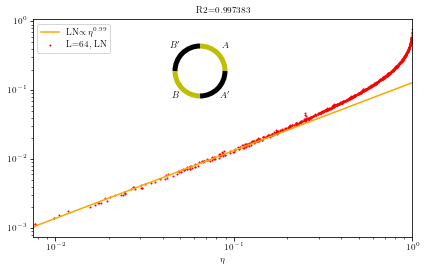

In [70]:
fig,ax=plt.subplots()
# ax.scatter(eta_no_list,MI_no_list,s=1,color='b',label='L=128, MI')
ax.scatter(eta_no_list,LN_no_list,s=1,color='r',label='L={}, LN'.format(L))

ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlim([np.min(eta_no_list),1])
# ax.set_ylim([1e-10,1])

# mask_MI=(MI_no_list>1e-10)&((eta_no_list)<0.1)
# lr_MI=scipy.stats.linregress(np.log(eta_no_list[mask_MI]),np.log(MI_no_list[mask_MI]))
# x_int=np.linspace(np.min(eta_no_list),1,10)
# y_int=np.exp(lr_MI.slope*np.log(x_int)+lr_MI.intercept)
# ax.plot(x_int,y_int,'c',label=r'MI$\propto\eta^{{{:.2f}}}$'.format(lr_MI.slope))

mask_LN=(LN_no_list>1e-10)&((eta_no_list)<0.1)
lr_LN=scipy.stats.linregress(np.log(eta_no_list[mask_LN]),np.log(LN_no_list[mask_LN]))
x_int=np.linspace(np.min(eta_no_list),1,10)
y_int=np.exp(lr_LN.slope*np.log(x_int)+lr_LN.intercept)
ax.plot(x_int,y_int,label=r'LN$\propto\eta^{{{:.2f}}}$'.format(lr_LN.slope),color='orange')
ax.set_xlabel(r'$\eta$')
ax.legend()
ax.set_title('R2={:f}'.format(lr_LN.rvalue))
place_region(200,200,fig,ax,'ykyk')
# fig.savefig('/mnt/d/kitp/Rp_SPT/6/MI_LN_no.pdf')

# fig.savefig('/mnt/d/KITP/slides_SPT/MI_LN_no.png')

In [62]:
lr_LN

LinregressResult(slope=1.0129878172039823, intercept=-1.652730209201303, rvalue=0.6198160296058355, pvalue=2.9351269565096453e-12, stderr=0.12761757234517596, intercept_stderr=0.40478460874532174)

In [ ]:
def test_powerlaw(delta):
    eta_no_list=[]
    MI_no_list=[]
    LN_no_list=[]
    L=128
    # delta=0
    T=0.1
    def run(p):
        L,delta,T=p
        params=Params(delta=delta,L=L,bc=-1,basis='m',T=T)
        x=2*np.random.choice(np.arange(L),4,replace=False)
        x.sort()
        eta=cross_ratio(x,2*L)
        # eta_no_list.append(eta)
        subregionA=np.arange(x[0],x[1])
        subregionB=np.arange(x[2],x[3])
        # MI=params.mutual_information_m(subregionA,subregionB)    
        # MI_no_list.append(MI)
        LN=params.log_neg(subregionA,subregionB)
        # LN_no_list.append(LN)
        return eta,LN
    inputs=[(L,delta,T) for _ in range(200)]
    async_result=rc[:].map_sync(run,inputs)

    for results in async_result:
        eta,LN=results
        eta_no_list.append(eta)
        LN_no_list.append(LN)

    eta_no_list=np.array(eta_no_list)
    LN_no_list=np.array(LN_no_list)
    mask_LN=(LN_no_list>1e-10)&((eta_no_list)<0.1)
    lr_LN=scipy.stats.linregress(np.log(eta_no_list[mask_LN]),np.log(LN_no_list[mask_LN]))
    return lr_LN,eta_no_list,LN_no_list



In [ ]:
first=0
last=0.06
# first=(first+last)/2

# last=(first+last)/2

delta_candidate_list=(np.linspace(first,last,41))
lr_LN_list=[]
eta_no_list_list=[]
LN_no_list_list=[]
for delta in delta_candidate_list:
    lr_LN,eta_no_list,LN_no_list=test_powerlaw(delta)
    lr_LN_list.append(lr_LN)
    eta_no_list_list.append(eta_no_list)
    LN_no_list_list.append(LN_no_list)

# z=[test_powerlaw(delta) for delta in delta_candidate_list]
r2_list=[lr_LN.rvalue for lr_LN in lr_LN_list]

In [ ]:
fig,ax=plt.subplots()
ax.plot(delta_candidate_list,r2_list)
argmax=delta_candidate_list[np.argmax(r2_list)]
ax.axvline(x=argmax)
ax.set_title('$\delta$={:f}, $R^2$={:f}'.format(argmax,np.max(r2_list)))

In [ ]:
np.argmax(r2_list)

In [ ]:
fig,ax=plt.subplots()
LN_no_list=LN_no_list_list[np.argmax(r2_list)]
eta_no_list=eta_no_list_list[np.argmax(r2_list)]
ax.scatter(eta_no_list,LN_no_list,s=1,color='r',label='L=128, LN')

ax.set_xscale('log')
ax.set_yscale('log')

mask_LN=(LN_no_list>1e-10)&((eta_no_list)<0.1)
lr_LN=scipy.stats.linregress(np.log(eta_no_list[mask_LN]),np.log(LN_no_list[mask_LN]))
x_int=np.linspace(np.min(eta_no_list),1,10)
y_int=np.exp(lr_LN.slope*np.log(x_int)+lr_LN.intercept)
ax.plot(x_int,y_int,label=r'LN$\propto\eta^{{{:.2f}}}$'.format(lr_LN.slope),color='orange')
ax.set_xlabel(r'$\eta$')
ax.legend()
ax.set_title('R2={:f}'.format(lr_LN.rvalue))

In [ ]:
lr_LN.rvalue

In [ ]:
fig,ax=plt.subplots()
ax.scatter(eta_list,MI_list,s=1,color='b',label='L=128, MI')
ax.scatter(eta_L_list,LN_L_list,s=1,color='r',label='L=128, LN')

ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlim([np.min(eta_L_list),1])
# ax.set_ylim([1e-10,1])

mask=(MI_L_list>1e-10)&((eta_L_list)<0.1)
lr=scipy.stats.linregress(np.log(eta_L_list[mask]),np.log(MI_L_list[mask]))
x_int=np.linspace(np.min(eta_L_list),1,10)
y_int=np.exp(lr.slope*np.log(x_int)+lr.intercept)
ax.plot(x_int,y_int,'k')
ax.legend()
ax.text(0.1,0.5,r'$\eta^{{{:.2f}}}$'.format(lr.slope),ha='left',va='center',transform=ax.transAxes)
ax.set_xlabel(r'$\eta$')
place_region(200,200,fig,ax,'ykyk')

fig.savefig('/mnt/d/kitp/Rp_SPT/6/MI_LN_no.pdf')


### Born measurement

In [ ]:
MI_Born_Ap_list.shape

In [ ]:
with open('/mnt/d/kitp/Rp_SPT/6/MI_LN_Born_es100_pt1000_Ap.pickle','rb') as f:
    eta_Born_Ap_list,MI_Born_Ap_list,LN_Born_Ap_list=pickle.load(f)

In [18]:
with open('/mnt/d/kitp/Rp_SPT/6/MI_LN_Born_es100_pt1000_L256_Ap.pickle','rb') as f:
    eta_Born_Ap_list,MI_Born_Ap_list,LN_Born_Ap_list=pickle.load(f)

In [7]:
with open('Majarona_scaling_L64_es10_ps100_onsite.pickle','rb') as f:
    LN_onsite_list,MI_onsite_list,eta_onsite_list,L,es,ps=pickle.load(f)

In [106]:
ps=500
es=1
L=128
eta_onsite_list=np.zeros(ps)
MI_onsite_list=np.zeros((ps,es))
LN_onsite_list=np.zeros((ps,es))
def run(p):
    L,x=p
    subregionA=np.arange(x[0],x[1])
    subregionB=np.arange(x[2],x[3])
    subregionAp=np.arange(x[1],x[2])
    params=Params(delta=0,L=L,bc=-1,basis='f')
    params.measure_all_Born(subregionAp,prob=0)
    MI=params.mutual_information_m(subregionA,subregionB)
    LN=params.log_neg(subregionA,subregionB)
    return MI,LN

for ps_i in range(ps):
    x=sorted(np.random.choice(np.arange(1,L),3,replace=False))
    x=[0]+x
    
    eta=cross_ratio(x,L)
    eta_onsite_list[ps_i]=(eta)
    inputs=[(L,x) for _ in range(es)]
    sync=rc[:].map_sync(run,inputs)

    for es_i,result in enumerate(sync):
        MI,LN=result
        MI_onsite_list[ps_i,es_i]=MI
        LN_onsite_list[ps_i,es_i]=LN

Text(0.5, 1.0, 'R2=0.648508')

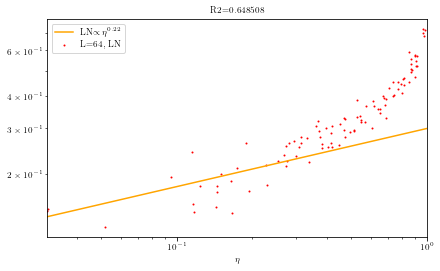

In [8]:
MI_onsite_list_mean=MI_onsite_list.mean(axis=1)
LN_onsite_list_mean=LN_onsite_list.mean(axis=1)
fig,ax=plt.subplots()
ax.scatter(eta_onsite_list,LN_onsite_list_mean,s=1,color='r',label='L={:d}, LN'.format(L))

ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlim([np.min(eta_onsite_list),1])

mask_LN=(LN_onsite_list_mean>1e-10)&((eta_onsite_list)<0.1)
lr_LN=scipy.stats.linregress(np.log(eta_onsite_list[mask_LN]),np.log(LN_onsite_list_mean[mask_LN]))
x_int=np.linspace(np.min(eta_onsite_list),1,10)
y_int=np.exp(lr_LN.slope*np.log(x_int)+lr_LN.intercept)
ax.plot(x_int,y_int,label=r'LN$\propto\eta^{{{:.2f}}}$'.format(lr_LN.slope),color='orange')
ax.set_xlabel(r'$\eta$')
ax.legend()
ax.set_title('R2={:f}'.format(lr_LN.rvalue))
# place_region(200,200,fig,ax,'ycyk')
# fig.savefig('/mnt/d/kitp/Rp_SPT/6/MI_LN_Born_Ap.pdf')
# fig.savefig('/mnt/d/KITP/slides_SPT/MI_LN_Born_Ap.png')

In [100]:
lr_LN.slope

0.5025450398123612

In [52]:
with open('/mnt/d/kitp/Paper_SPT/Fig/Majarona_scaling.pickle','wb') as f:
    pickle.dump([LN_no_list,LN_onsite_list,MI_no_list,MI_onsite_list,eta_no_list,eta_onsite_list,L,es,ps],f)

In [ ]:
with open('MI_LN_Born_es100_pt1000_ApBp.pickle','rb') as f:
    eta_Born_ApBp_list,MI_Born_ApBp_list,LN_Born_ApBp_list=pickle.load(f)

In [ ]:
with open('/mnt/d/kitp/Rp_SPT/6/MI_LN_Born_es100_pt1000_L256_ApBp.pickle','rb') as f:
    eta_Born_ApBp_list,MI_Born_ApBp_list,LN_Born_ApBp_list=pickle.load(f)

In [ ]:
eta_Born_ApBp_list=[]
MI_Born_ApBp_list=[]
LN_Born_ApBp_list=[]
# x_list=[]
# subregion_list=[]
es=10
L=128
for _ in range(100):
    MI_ensemble_list=[]
    LN_ensemble_list=[]
    x=sorted(2*np.random.choice(np.arange(1,L),3,replace=False))
    x=[0]+x
    subregionA=np.arange(x[0],x[1])
    subregionB=np.arange(x[2],x[3])
    subregionAp=np.arange(x[1],x[2],2)
    subregionBp=np.concatenate([np.arange(x[3],2*L,2),np.arange(0,x[0],2)])
    eta=cross_ratio(x,L)
    for _ in range(es):
        params=Params(delta=0,L=L,bc=-1,basis='m').measure_all_Born(subregionAp).measure_all_Born(subregionBp)
        MI_ensemble_list.append(params.mutual_information_m(subregionA,subregionB))
        LN_ensemble_list.append(params.log_neg(subregionA,subregionB))

    eta_Born_ApBp_list.append(eta)
    MI_Born_ApBp_list.append(MI_ensemble_list)
    LN_Born_ApBp_list.append(LN_ensemble_list)
eta_Born_ApBp_list=np.array(eta_Born_ApBp_list)
MI_Born_ApBp_list=np.array(MI_Born_ApBp_list)
LN_Born_ApBp_list=np.array(LN_Born_ApBp_list)

In [ ]:
MI_Born_ApBp_list_mean=MI_Born_ApBp_list.mean(axis=1)
LN_Born_ApBp_list_mean=LN_Born_ApBp_list.mean(axis=1)
fig,ax=plt.subplots()
ax.scatter(eta_Born_ApBp_list,MI_Born_ApBp_list_mean,s=1,color='b',label='L=256, MI')
ax.scatter(eta_Born_ApBp_list,LN_Born_ApBp_list_mean,s=1,color='r',label='L=256, LN')

ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlim([np.min(eta_Born_ApBp_list),1])
# ax.set_ylim([1e-10,1])

mask_MI=(MI_Born_ApBp_list_mean>1e-10)&((eta_Born_ApBp_list)<0.1)
lr_MI=scipy.stats.linregress(np.log(eta_Born_ApBp_list[mask_MI]),np.log(MI_Born_ApBp_list_mean[mask_MI]))
x_int=np.linspace(np.min(eta_Born_ApBp_list),1,10)
y_int=np.exp(lr_MI.slope*np.log(x_int)+lr_MI.intercept)
ax.plot(x_int,y_int,'c',label=r'MI$\propto\eta^{{{:.2f}}}$'.format(lr_MI.slope))

mask_LN=(LN_Born_ApBp_list_mean>1e-10)&((eta_Born_ApBp_list)<0.1)
lr_LN=scipy.stats.linregress(np.log(eta_Born_ApBp_list[mask_LN]),np.log(LN_Born_ApBp_list_mean[mask_LN]))
x_int=np.linspace(np.min(eta_Born_ApBp_list),1,10)
y_int=np.exp(lr_LN.slope*np.log(x_int)+lr_LN.intercept)
ax.plot(x_int,y_int,label=r'LN$\propto\eta^{{{:.2f}}}$'.format(lr_LN.slope),color='orange')
ax.set_xlabel(r'$\eta$')
ax.legend()

place_region(200,200,fig,ax,'ycyc')
fig.savefig('/mnt/d/kitp/Rp_SPT/6/MI_LN_Born_ApBp.pdf')


### Measure to s=-1

In [ ]:
eta_neg_Ap_list=[]
MI_neg_Ap_list=[]
LN_neg_Ap_list=[]
L=128
for _ in range(1000):
    params=Params(delta=0,L=L,bc=-1,basis='m')
    x=sorted(2*np.random.choice(np.arange(1,L),3,replace=False))
    x=[0]+x
    subregionA=np.arange(x[0],x[1])
    subregionB=np.arange(x[2],x[3])
    subregionAp=np.arange(x[1],x[2],2)
    params.measure_all(0,subregionAp)
    # MI_neg_Ap_list.append(params.mutual_information_m(subregionA,subregionB))
    LN_neg_Ap_list.append(params.log_neg(subregionA,subregionB))
    eta_neg_Ap_list.append(cross_ratio(x,2*L))
eta_neg_Ap_list=np.array(eta_neg_Ap_list)
# MI_neg_Ap_list=np.array(MI_neg_Ap_list)
LN_neg_Ap_list=np.array(LN_neg_Ap_list)

In [ ]:
fig,ax=plt.subplots()
# ax.scatter(eta_neg_Ap_list,MI_neg_Ap_list,s=1,color='b',label='L=128, MI')
ax.scatter(eta_neg_Ap_list,LN_neg_Ap_list,s=1,color='r',label='L=128, LN')

ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlim([np.min(eta_neg_Ap_list),1])
# ax.set_ylim([1e-10,1])

# mask_MI=(MI_neg_Ap_list>1e-10)&((eta_neg_Ap_list)<0.1)
# lr_MI=scipy.stats.linregress(np.log(eta_neg_Ap_list[mask_MI]),np.log(MI_neg_Ap_list[mask_MI]))
# x_int=np.linspace(np.min(eta_neg_Ap_list),1,10)
# y_int=np.exp(lr_MI.slope*np.log(x_int)+lr_MI.intercept)
# ax.plot(x_int,y_int,'c',label=r'MI$\propto\eta^{{{:.2f}}}$'.format(lr_MI.slope))

mask_LN=(LN_neg_Ap_list>1e-10)&((eta_neg_Ap_list)<0.1)
lr_LN=scipy.stats.linregress(np.log(eta_neg_Ap_list[mask_LN]),np.log(LN_neg_Ap_list[mask_LN]))
x_int=np.linspace(np.min(eta_neg_Ap_list),1,10)
y_int=np.exp(lr_LN.slope*np.log(x_int)+lr_LN.intercept)
ax.plot(x_int,y_int,label=r'LN$\propto\eta^{{{:.2f}}}$'.format(lr_LN.slope),color='orange')
ax.set_xlabel(r'$\eta$')
ax.legend()

place_region(200,200,fig,ax,'ycyk')
# fig.savefig('/mnt/d/kitp/Rp_SPT/6/MI_LN_neg_Ap.pdf')
fig.savefig('/mnt/d/KITP/slides_SPT/MI_LN_neg_Ap.png')


In [ ]:
1/np.log(np.sqrt(2)+1)

In [ ]:
eta_neg_ApBp_list=[]
MI_neg_ApBp_list=[]
LN_neg_ApBp_list=[]
L=128
for _ in range(1000):
    params=Params(delta=0.0,L=L,bc=-1,basis='m')
    x=sorted(2*np.random.choice(np.arange(1,L),3,replace=False))
    x=[0]+x
    subregionA=np.arange(x[0],x[1])
    subregionB=np.arange(x[2],x[3])
    subregionAp=np.arange(x[1],x[2],2)
    subregionBp=np.concatenate([np.arange(x[3],2*params.L,2),np.arange(0,x[0],2)])
    params.measure_all(0,subregionAp).measure_all(0,subregionBp)
    MI_neg_ApBp_list.append(params.mutual_information_m(subregionA,subregionB))
    LN_neg_ApBp_list.append(params.log_neg(subregionA,subregionB))
    eta_neg_ApBp_list.append(cross_ratio(x,2*L)
)
eta_neg_ApBp_list=np.array(eta_neg_ApBp_list)
MI_neg_ApBp_list=np.array(MI_neg_ApBp_list)
LN_neg_ApBp_list=np.array(LN_neg_ApBp_list)

In [ ]:
fig,ax=plt.subplots()
ax.scatter(eta_neg_ApBp_list,MI_neg_ApBp_list,s=1,color='b',label='L=128, MI')
ax.scatter(eta_neg_ApBp_list,LN_neg_ApBp_list,s=1,color='r',label='L=128, LN')

ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlim([np.min(eta_neg_ApBp_list),1])
# ax.set_ylim([1e-10,1])

mask_MI=(MI_neg_ApBp_list>1e-10)&((eta_neg_ApBp_list)<0.1)
lr_MI=scipy.stats.linregress(np.log(eta_neg_ApBp_list[mask_MI]),np.log(MI_neg_ApBp_list[mask_MI]))
x_int=np.linspace(np.min(eta_neg_ApBp_list),1,10)
y_int=np.exp(lr_MI.slope*np.log(x_int)+lr_MI.intercept)
ax.plot(x_int,y_int,'c',label=r'MI$\propto\eta^{{{:.2f}}}$'.format(lr_MI.slope))

mask_LN=(LN_neg_ApBp_list>1e-10)&((eta_neg_ApBp_list)<0.1)
lr_LN=scipy.stats.linregress(np.log(eta_neg_ApBp_list[mask_LN]),np.log(LN_neg_ApBp_list[mask_LN]))
x_int=np.linspace(np.min(eta_neg_ApBp_list),1,10)
y_int=np.exp(lr_LN.slope*np.log(x_int)+lr_LN.intercept)
ax.plot(x_int,y_int,label=r'LN$\propto\eta^{{{:.2f}}}$'.format(lr_LN.slope),color='orange')
ax.set_xlabel(r'$\eta$')
ax.legend()

place_region(200,200,fig,ax,'ycyc')
fig.savefig('/mnt/d/kitp/Rp_SPT/6/MI_LN_neg_ApBp.pdf')


### Measure to s=+1

In [ ]:
eta_pos_Ap_list=[]
MI_pos_Ap_list=[]
LN_pos_Ap_list=[]
L=128
# delta=delta_list[np.argmax(log_neg_pos_list)]
delta=0.0
for _ in range(1000):
    x=sorted(2*np.random.choice(np.arange(1,L),3,replace=False))
    x=[0]+x
    while ((x[2]-x[1])/2)%2==1 or (L-(x[3]-x[0])/2)%2==1:
        x=sorted(2*np.random.choice(np.arange(1,L),3,replace=False))
        x=[0]+x
    params=Params(delta=delta,L=L,bc=-1,basis='m')
    subregionA=np.arange(x[0],x[1])
    subregionB=np.arange(x[2],x[3])
    subregionAp=np.arange(x[1],x[2],2)
    params.measure_all(1,subregionAp)
    eta_pos_Ap_list.append(cross_ratio(x,2*L))
    MI_pos_Ap_list.append(params.mutual_information_m(subregionA,subregionB))
    LN_pos_Ap_list.append(params.log_neg(subregionA,subregionB))
eta_pos_Ap_list=np.array(eta_pos_Ap_list)
MI_pos_Ap_list=np.array(MI_pos_Ap_list)
LN_pos_Ap_list=np.array(LN_pos_Ap_list)

In [ ]:
with open('/mnt/d/KITP/Rp_SPT/5/MI_pos_Ap_L1024_es1000.pickle','rb') as f:
    eta_pos_Ap_list,MI_pos_Ap_list=pickle.load(f)

In [ ]:
fig,ax=plt.subplots()
ax.scatter(eta_pos_Ap_list,MI_pos_Ap_list,s=1,color='b',label='L=128, MI')
ax.scatter(eta_pos_Ap_list,LN_pos_Ap_list,s=1,color='r',label='L=128, LN')

ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlim([np.min(eta_pos_Ap_list),1])
# ax.set_ylim([1e-10,1])

mask_MI=(MI_pos_Ap_list>1e-10)&((eta_pos_Ap_list)<0.1)
lr_MI=scipy.stats.linregress(np.log(eta_pos_Ap_list[mask_MI]),np.log(MI_pos_Ap_list[mask_MI]))
x_int=np.linspace(np.min(eta_pos_Ap_list),1,10)
y_int=np.exp(lr_MI.slope*np.log(x_int)+lr_MI.intercept)
ax.plot(x_int,y_int,'c',label=r'MI$\propto\eta^{{{:.2f}}}$'.format(lr_MI.slope))

mask_LN=(LN_pos_Ap_list>1e-10)&((eta_pos_Ap_list)<0.1)
lr_LN=scipy.stats.linregress(np.log(eta_pos_Ap_list[mask_LN]),np.log(LN_pos_Ap_list[mask_LN]))
x_int=np.linspace(np.min(eta_pos_Ap_list),1,10)
y_int=np.exp(lr_LN.slope*np.log(x_int)+lr_LN.intercept)
ax.plot(x_int,y_int,label=r'LN$\propto\eta^{{{:.2f}}}$'.format(lr_LN.slope),color='orange')

ax.set_xlabel(r'$\eta$')
ax.legend()

place_region(200,200,fig,ax,'ycyk')
# fig.savefig('/mnt/d/kitp/Rp_SPT/6/MI_LN_pos_Ap.pdf')


In [ ]:
delta_list[np.argmax(log_neg_pos_list)]

In [ ]:
def find_pos_peak_Ap(x,L=128,di=51):
    assert ((x[2]-x[1])/2)%2==0, "The projection region is not even numbered"
    delta_list=np.linspace(-.1,.1,di)
    LN_pos_list=[]
    MI_pos_list=[]
    subregionA=np.arange(x[0],x[1])
    subregionB=np.arange(x[2],x[3])
    subregionAp=np.arange(x[1],x[2],2)
    for delta in delta_list:
        params=Params(delta=delta,L=L,bc=-1)
        params.measure_all(1,subregionAp)
        LN_pos_list.append(params.log_neg(subregionA,subregionB))
        # MI_pos_list.append(params.mutual_information_m(subregionA,subregionB))
    argmax_LN=delta_list[np.argmax(LN_pos_list)]
    # argmax_MI=delta_list[np.argmax(MI_pos_list)]
    return argmax_LN
    # return delta_list,LN_pos_list,MI_pos_list

In [ ]:
x=sorted(2*np.random.choice(np.arange(1,L),3,replace=False))
x=[0]+x
while ((x[2]-x[1])/2)%2==1:
    x=sorted(2*np.random.choice(np.arange(1,L),3,replace=False))
    x=[0]+x

In [ ]:
x

In [ ]:
(x[2]-x[1])/2

In [ ]:
L-(x[3]-x[0])/2

In [ ]:
find_pos_peak(x)

In [ ]:
plt.plot(z_d,z_MI/np.log(2))
plt.plot(z_d,z_LN/np.log(2))

In [ ]:
eta_pos_max_Ap_list=[]
MI_pos_max_Ap_list=[]
LN_pos_max_Ap_list=[]
L=128
# delta=delta_list[np.argmax(log_neg_pos_list)]
delta_LN_pos_max_Ap_list=[]
# delta_MI_pos_max_Ap_list=[]

x_list=[]
for _ in range(1000):
    x=sorted(2*np.random.choice(np.arange(1,L),3,replace=False))
    x=[0]+x
    while ((x[2]-x[1])/2)%2==1 or (L-(x[3]-x[0])/2)%2==1:
        x=sorted(2*np.random.choice(np.arange(1,L),3,replace=False))
        x=[0]+x
    x_list.append(x)
    argmax_LN=find_pos_peak_Ap(x)
    delta_LN_pos_max_Ap_list.append(argmax_LN)
    # delta_MI_pos_max_Ap_list.append(argmax_MI)
    params=Params(delta=argmax_LN,L=L,bc=-1,basis='m')    
    subregionA=np.arange(x[0],x[1])
    subregionB=np.arange(x[2],x[3])
    subregionAp=np.arange(x[1],x[2],2)
    params.measure_all(1,subregionAp)
    eta_pos_max_Ap_list.append(cross_ratio(x,2*L))
    MI_pos_max_Ap_list.append(params.mutual_information_m(subregionA,subregionB))
    LN_pos_max_Ap_list.append(params.log_neg(subregionA,subregionB))
eta_pos_max_Ap_list=np.array(eta_pos_max_Ap_list)
MI_pos_max_Ap_list=np.array(MI_pos_max_Ap_list)
LN_pos_max_Ap_list=np.array(LN_pos_max_Ap_list)

In [ ]:
x_list[3]

In [ ]:
x_list[3][3]-x_list[3][2]

In [ ]:
delta_pos_max_Ap_list[3]

In [ ]:
eta_list[np.argmax(delta_MI_pos_max_Ap_list)]

In [ ]:
x=x_list[2]

In [ ]:
plt.plot(sorted(delta_LN_pos_max_Ap_list),'.')
# plt.plot(sorted(eta_pos_max_Ap_list),'.')


In [ ]:
fig,ax=plt.subplots()
ax.scatter(eta_pos_max_Ap_list,MI_pos_max_Ap_list,s=1,color='b',label='L=128, MI')
ax.scatter(eta_pos_max_Ap_list,LN_pos_max_Ap_list,s=1,color='r',label='L=128, LN')

# ax.set_xscale('log')
# ax.set_yscale('log')
# ax.set_xlim([np.min(eta_pos_max_Ap_list),1])
# ax.set_ylim([1e-10,1])

# mask_MI=(MI_pos_max_Ap_list>1e-10)&((eta_pos_max_Ap_list)<0.1)
# lr_MI=scipy.stats.linregress(np.log(eta_pos_max_Ap_list[mask_MI]),np.log(MI_pos_max_Ap_list[mask_MI]))
# x_int=np.linspace(np.min(eta_pos_max_Ap_list),1,10)
# y_int=np.exp(lr_MI.slope*np.log(x_int)+lr_MI.intercept)
# ax.plot(x_int,y_int,'c',label=r'MI$\propto\eta^{{{:.2f}}}$'.format(lr_MI.slope))

# mask_LN=(LN_pos_max_Ap_list>1e-10)&((eta_pos_max_Ap_list)<0.1)
# lr_LN=scipy.stats.linregress(np.log(eta_pos_max_Ap_list[mask_LN]),np.log(LN_pos_max_Ap_list[mask_LN]))
# x_int=np.linspace(np.min(eta_pos_max_Ap_list),1,10)
# y_int=np.exp(lr_LN.slope*np.log(x_int)+lr_LN.intercept)
# ax.plot(x_int,y_int,label=r'LN$\propto\eta^{{{:.2f}}}$'.format(lr_LN.slope),color='orange')
ax.set_xlabel(r'$\eta$')
ax.legend()

place_region(200,220,fig,ax,'ycyk')
fig.savefig('/mnt/d/kitp/Rp_SPT/6/MI_LN_pos_max_Ap.pdf')


In [ ]:
with open('MI_LN_Born_es100_pt100_Ap.pickle','rb') as f:
    eta_Born_Ap_list,MI_Born_Ap_list,LN_Born_Ap_list=pickle.load(f)

In [ ]:
x=sorted(2*np.random.choice(np.arange(1,L),3,replace=False))
x=[0]+x

In [ ]:
x

In [ ]:
(x[2]-x[1])/2

In [ ]:
z_d,z_LN,z_MI=find_pos_peak(x)

In [ ]:
fig,ax=plt.subplots()
ax.plot(z_d,z_LN,color='r')
ax.plot(z_d,z_MI,color='b')
ax.axvline(x=z_d[np.argmax(z_LN)],color='r')
ax.axvline(x=z_d[np.argmax(z_MI)],color='b')



In [ ]:
eta_pos_ApBp_list=[]
MI_pos_ApBp_list=[]
LN_pos_ApBp_list=[]
L=128
delta=0
for _ in range(1000):
    x=sorted(2*np.random.choice(np.arange(1,L),3,replace=False))
    x=[0]+x
    while ((x[2]-x[1])/2)%2==1 or (L-(x[3]-x[0])/2)%2==1:
        x=sorted(2*np.random.choice(np.arange(1,L),3,replace=False))
        x=[0]+x
    params=Params(delta=delta,L=L,bc=-1,basis='m')    
    subregionA=np.arange(x[0],x[1])
    subregionB=np.arange(x[2],x[3])
    subregionAp=np.arange(x[1],x[2],2)
    subregionBp=np.concatenate([np.arange(x[3],2*params.L,2),np.arange(0,x[0],2)])
    params.measure_all(1,subregionAp).measure_all(1,subregionBp)
    eta_pos_ApBp_list.append(cross_ratio(x,2*L))
    MI_pos_ApBp_list.append(params.mutual_information_m(subregionA,subregionB))
    LN_pos_ApBp_list.append(params.log_neg(subregionA,subregionB))
eta_pos_ApBp_list=np.array(eta_pos_ApBp_list)
MI_pos_ApBp_list=np.array(MI_pos_ApBp_list)
LN_pos_ApBp_list=np.array(LN_pos_ApBp_list)

In [ ]:
with open('/mnt/d/KITP/Rp_SPT/5/MI_pos_ApBp_L1024_es2000.pickle','rb') as f:
    eta_pos_ApBp_list,MI_pos_ApBp_list=pickle.load(f)

In [ ]:
fig,ax=plt.subplots()
ax.scatter(eta_pos_ApBp_list,MI_pos_ApBp_list,s=1,color='b',label='L=128, MI')
ax.scatter(eta_pos_ApBp_list,LN_pos_ApBp_list,s=1,color='r',label='L=128, LN')

# ax.set_xscale('log')
# ax.set_yscale('log')
# ax.set_xlim([np.min(eta_pos_ApBp_list),1])
# # ax.set_ylim([1e-10,1])

# mask_MI=(MI_pos_ApBp_list>1e-10)&((eta_pos_ApBp_list)<0.1)
# lr_MI=scipy.stats.linregress(np.log(eta_pos_ApBp_list[mask_MI]),np.log(MI_pos_ApBp_list[mask_MI]))
# x_int=np.linspace(np.min(eta_pos_ApBp_list),1,10)
# y_int=np.exp(lr_MI.slope*np.log(x_int)+lr_MI.intercept)
# ax.plot(x_int,y_int,'c',label=r'MI$\propto\eta^{{{:.2f}}}$'.format(lr_MI.slope))

# mask_LN=(LN_pos_ApBp_list>1e-10)&((eta_pos_ApBp_list)<0.1)
# lr_LN=scipy.stats.linregress(np.log(eta_pos_ApBp_list[mask_LN]),np.log(LN_pos_ApBp_list[mask_LN]))
# x_int=np.linspace(np.min(eta_pos_ApBp_list),1,10)
# y_int=np.exp(lr_LN.slope*np.log(x_int)+lr_LN.intercept)
# ax.plot(x_int,y_int,label=r'LN$\propto\eta^{{{:.2f}}}$'.format(lr_LN.slope),color='orange')

ax.set_xlabel(r'$\eta$')
ax.legend()

place_region(200,200,fig,ax,'ycyc')
fig.savefig('/mnt/d/kitp/Rp_SPT/6/MI_LN_pos_ApBp.pdf')


In [ ]:
def find_pos_peak_ApBp(x,L=128,di=51):
    assert ((x[2]-x[1])/2)%2==0, "The projection region is not even numbered"
    delta_list=np.linspace(-.1,.1,di)
    LN_pos_list=[]
    MI_pos_list=[]
    subregionA=np.arange(x[0],x[1])
    subregionB=np.arange(x[2],x[3])
    subregionAp=np.arange(x[1],x[2],2)
    subregionBp=np.concatenate([np.arange(x[3],L,2),np.arange(0,x[0],2)])
    for delta in delta_list:
        params=Params(delta=delta,L=L,bc=-1)
        params.measure_all(1,subregionAp).measure_all(1,subregionBp)
        LN_pos_list.append(params.log_neg(subregionA,subregionB))
        # MI_pos_list.append(params.mutual_information_m(subregionA,subregionB))
    argmax_LN=delta_list[np.argmax(LN_pos_list)]
    # argmax_MI=delta_list[np.argmax(MI_pos_list)]
    return argmax_LN
    # return delta_list,LN_pos_list,MI_pos_list

In [ ]:
z_d,z_MI,z_LN=find_pos_peak_ApBp(x)

In [ ]:
plt.plot(z_d,z_MI,'r')
plt.plot(z_d,z_LN,'b')

In [ ]:
eta_pos_max_ApBp_list=[]
MI_pos_max_ApBp_list=[]
LN_pos_max_ApBp_list=[]
L=128
# delta=delta_list[np.argmax(log_neg_pos_list)]
delta_LN_pos_max_ApBp_list=[]
# delta_MI_pos_max_ApBp_list=[]

x_list=[]
for _ in range(1000):
    x=sorted(2*np.random.choice(np.arange(1,L),3,replace=False))
    x=[0]+x
    while ((x[2]-x[1])/2)%2==1 or (L-(x[3]-x[0])/2)%2==1:
        x=sorted(2*np.random.choice(np.arange(1,L),3,replace=False))
        x=[0]+x
    x_list.append(x)
    argmax_LN=find_pos_peak_ApBp(x)
    delta_LN_pos_max_ApBp_list.append(argmax_LN)
    # delta_MI_pos_max_ApBp_list.append(argmax_MI)
    params=Params(delta=argmax_LN,L=L,bc=-1,basis='m')    
    subregionA=np.arange(x[0],x[1])
    subregionB=np.arange(x[2],x[3])
    subregionAp=np.arange(x[1],x[2],2)
    params.measure_all(1,subregionAp)
    eta_pos_max_ApBp_list.append(cross_ratio(x,2*L))
    MI_pos_max_ApBp_list.append(params.mutual_information_m(subregionA,subregionB))
    LN_pos_max_ApBp_list.append(params.log_neg(subregionA,subregionB))
eta_pos_max_ApBp_list=np.array(eta_pos_max_ApBp_list)
MI_pos_max_ApBp_list=np.array(MI_pos_max_ApBp_list)
LN_pos_max_ApBp_list=np.array(LN_pos_max_ApBp_list)

In [ ]:
plt.plot(sorted(delta_LN_pos_max_ApBp_list),'.')


In [ ]:
fig,ax=plt.subplots()
ax.scatter(eta_pos_max_ApBp_list,MI_pos_max_ApBp_list,s=1,color='b',label='L=128, MI')
ax.scatter(eta_pos_max_ApBp_list,LN_pos_max_ApBp_list,s=1,color='r',label='L=128, LN')

# ax.set_xscale('log')
# ax.set_yscale('log')
# ax.set_xlim([np.min(eta_pos_max_ApBp_list),1])
# ax.set_ylim([1e-10,1])

# mask_MI=(MI_pos_max_ApBp_list>1e-10)&((eta_pos_max_ApBp_list)<0.1)
# lr_MI=scipy.stats.linregress(np.log(eta_pos_max_ApBp_list[mask_MI]),np.log(MI_pos_max_ApBp_list[mask_MI]))
# x_int=np.linspace(np.min(eta_pos_max_ApBp_list),1,10)
# y_int=np.exp(lr_MI.slope*np.log(x_int)+lr_MI.intercept)
# ax.plot(x_int,y_int,'c',label=r'MI$\propto\eta^{{{:.2f}}}$'.format(lr_MI.slope))

# mask_LN=(LN_pos_max_ApBp_list>1e-10)&((eta_pos_max_ApBp_list)<0.1)
# lr_LN=scipy.stats.linregress(np.log(eta_pos_max_ApBp_list[mask_LN]),np.log(LN_pos_max_ApBp_list[mask_LN]))
# x_int=np.linspace(np.min(eta_pos_max_ApBp_list),1,10)
# y_int=np.exp(lr_LN.slope*np.log(x_int)+lr_LN.intercept)
# ax.plot(x_int,y_int,label=r'LN$\propto\eta^{{{:.2f}}}$'.format(lr_LN.slope),color='orange')
ax.set_xlabel(r'$\eta$')
ax.legend()

place_region(200,220,fig,ax,'ycyc')
fig.savefig('/mnt/d/kitp/Rp_SPT/6/MI_LN_pos_max_ApBp.pdf')


In [ ]:
mask_parity=np.array([len(x)%2==0 for x in subregion_list])

In [ ]:
mask_parity={}
for i in range(4):
    mask_parity[i]=np.array([len(x)%4==i for x in subregion_list])

In [ ]:
[np.count_nonzero(mask_parity[i]) for i in range(4)]

In [ ]:
def func_fit(x,a,b,c):
    # return a*x**b
    return a*(x+b)**c

In [ ]:
mask=eta_pos_list<0.5

In [ ]:
popt, pcov=scipy.optimize.curve_fit(func_fit,eta_pos_list[mask],MI_pos_list[mask]-0.4433)

In [ ]:
popt

In [ ]:
np.min(MI_pos_list)

In [ ]:
eta_pos_list[np.argmin(MI_pos_list)]

In [ ]:
MI_pos_list[np.argmin(eta_pos_list)]

In [ ]:
MI_pos_list

In [ ]:
fig,ax=plt.subplots()
ax.scatter(eta_pos_list[mask_parity[0]],MI_pos_list[mask_parity[0]]-np.min(MI_pos_list),s=1,color='b')
ax.scatter(eta_pos_list[mask_parity[1]],MI_pos_list[mask_parity[1]]-np.min(MI_pos_list),s=1,color='r')
ax.scatter(eta_pos_list[mask_parity[2]],MI_pos_list[mask_parity[2]]-np.min(MI_pos_list),s=1,color='g')
ax.scatter(eta_pos_list[mask_parity[3]],MI_pos_list[mask_parity[3]]-np.min(MI_pos_list),s=1,color='y')

# ax.scatter(eta_pos_list[~mask_parity],MI_pos_list[~mask_parity]-np.min(MI_pos_list),s=1,color='r')
# ax.set_xscale('log')
# ax.set_yscale('log')
# ax.set_xlim([np.min(eta_list),1])
# ax.set_ylim([1e-10,1])

# mask=(MI_pos_list>1e-10)&((eta_pos_list)<0.1)
# lr=scipy.stats.linregress(np.log(eta_pos_list[mask]),np.log(MI_pos_list[mask]))
# x_int=np.linspace(np.min(eta_pos_list),1,10)
# y_int=np.exp(lr.slope*np.log(x_int)+lr.intercept)
# ax.plot(x_int,y_int,'k')
# ax.text(0.1,0.5,r'$\eta^{{{:.2f}}}$'.format(lr.slope),ha='left',va='center',transform=ax.transAxes)
# ax.set_xlabel(r'$\eta$')
# ax.set_ylabel('MI')
# fig.savefig('/mnt/d/kitp/Rp_SPT/5/MI_CFT_pos.pdf')


In [ ]:
fig,ax=plt.subplots()
ax.scatter(eta_pos_list[mask_parity],MI_pos_list[mask_parity],s=1,color='b')
ax.set_xscale('log')
ax.set_yscale('log')
# ax.set_xlim([np.min(eta_list),1])
# ax.set_ylim([1e-10,1])

# mask=(MI_pos_list>1e-10)&((eta_pos_list)<0.1)
# lr=scipy.stats.linregress(np.log(eta_pos_list[mask]),np.log(MI_pos_list[mask]))
# x_int=np.linspace(np.min(eta_pos_list),1,10)
# y_int=np.exp(lr.slope*np.log(x_int)+lr.intercept)
# ax.plot(x_int,y_int,'k')
# ax.text(0.1,0.5,r'$\eta^{{{:.2f}}}$'.format(lr.slope),ha='left',va='center',transform=ax.transAxes)
# ax.set_xlabel(r'$\eta$')
# ax.set_ylabel('MI')
# fig.savefig('/mnt/d/kitp/Rp_SPT/5/MI_CFT_pos.pdf')


In [ ]:
fig,ax=plt.subplots()
ax.scatter(eta_pos_list[~mask_parity],MI_pos_list[~mask_parity],s=1,color='b')
ax.set_xscale('log')
ax.set_yscale('log')
# ax.set_xlim([np.min(eta_list),1])
# ax.set_ylim([1e-10,1])

# mask=(MI_pos_list>1e-10)&((eta_pos_list)<0.1)
# lr=scipy.stats.linregress(np.log(eta_pos_list[mask]),np.log(MI_pos_list[mask]))
# x_int=np.linspace(np.min(eta_pos_list),1,10)
# y_int=np.exp(lr.slope*np.log(x_int)+lr.intercept)
# ax.plot(x_int,y_int,'k')
# ax.text(0.1,0.5,r'$\eta^{{{:.2f}}}$'.format(lr.slope),ha='left',va='center',transform=ax.transAxes)
# ax.set_xlabel(r'$\eta$')
# ax.set_ylabel('MI')
# fig.savefig('/mnt/d/kitp/Rp_SPT/5/MI_CFT_pos.pdf')


In [ ]:
(eta_L_list>1e-5)&((eta_L_list)<0.5)

In [ ]:
mask=(MI_L_list>1e-4)&((eta_L_list)<0.5)
lr=scipy.stats.linregress(np.log(eta_L_list[mask]),np.log(MI_L_list[mask]))

In [ ]:
lr=scipy.stats.linregress(np.log(eta_L_list[mask]),np.log(MI_L_list[mask]))


In [ ]:
mask=(eta_L_list)<0.5

In [ ]:
lr=scipy.stats.linregress(np.log(eta_L_list[mask]),np.log(MI_L_list[mask]))

In [ ]:
lr

In [ ]:
eta_list[1]

In [ ]:
x_list[1]

In [ ]:
np.abs(x_list[0]-x_list[1])

In [ ]:
x01=np.sin(np.pi/(2*params.L)*np.abs(x_list[1][0]-x_list[1][1]))

In [ ]:
x23=np.sin(np.pi/(2*params.L)*np.abs(x_list[1][2]-x_list[1][3]))

In [ ]:
x02=np.sin(np.pi/(2*params.L)*np.abs(x_list[1][0]-x_list[1][2]))

In [ ]:
x13=np.sin(np.pi/(2*params.L)*np.abs(x_list[1][1]-x_list[1][3]))

In [ ]:
x01*x23/(x02*x13)

In [ ]:
eta_list[1]

In [ ]:
eta,MI=params.CFT_correlator(x_list[1])

In [ ]:
eta

In [ ]:
MI_list[1]

In [ ]:
et

In [ ]:
np.where(np.array(eta_list)<0)

In [ ]:
x=lambda x: x**2

In [ ]:
xx=np.random.choice(np.arange(params.L*2),4,replace=False).sort()

In [ ]:
xx

In [ ]:
xx.sort()

In [ ]:
xx

### Exhausted sampling

In [ ]:
eta_L_list=[]
MI_L_list=[]
LN_L_list=[]
x_list=[]
params=Params(delta=0,L=128,bc=-1,basis='m')
for _ in range(10000):
    x=2*np.random.choice(np.arange(params.L),4,replace=False)
    x.sort()
    x_list.append(x)
    eta,MI,LN=params.CFT_correlator(x)
    eta_L_list.append(eta)
    MI_L_list.append(MI)
    LN_L_list.append(LN)
eta_L_list=np.array(eta_L_list)
MI_L_list=np.array(MI_L_list)
LN_L_list=np.array(LN_L_list)

# Finite temperature

## MI

In [ ]:
mutual_info_list={}
mutual_info_pos_list={}
mutual_info_neg_list={}

In [ ]:
for T0 in (0,0.1e-1,0.2e-1,0.5e-1,1e-1,2e-1,3e-1):
    # T_list=np.linspace(0,5e-2,100)
    # no measurment
    delta_list=np.linspace(-1,1,100)**3
    mutual_info_list[T0]=[]
    for delta in delta_list:    
        params=Params(delta=delta,L=64,bc=-1,T=T0)
        mutual_info_list[T0].append(params.mutual_information_m(np.arange((params.L//2)),np.arange((params.L//2))+params.L))

    # all projections to 0
    mutual_info_pos_list[T0]=[]
    for delta in delta_list:    
        params=Params(delta=delta,L=64,bc=-1,T=T0)
        params.measure_all(1)
        mutual_info_pos_list[T0].append(params.mutual_information_m(np.arange((params.L//2)),np.arange((params.L//2))+params.L))

    # all projections to 1
    mutual_info_neg_list[T0]=[]
    for delta in delta_list:
        params=Params(delta=delta,L=64,bc=-1,T=T0)
        params.measure_all(0)
        mutual_info_neg_list[T0].append(params.mutual_information_m(np.arange((params.L//2)),np.arange((params.L//2))+params.L))

In [ ]:
fig,ax=plt.subplots(figsize=(6.8,4))
colorlist=iter('bgrcmyk')
label_height_pos=0.8
for T0,color in zip((0,0.1e-1,0.2e-1,0.5e-1,1e-1,2e-1,3e-1),colorlist):
    ax.plot(delta_list,mutual_info_list[T0]/np.log(2),'-',label='no measure, T={:.2f}'.format(T0),color=color,ls='--')
    ax.plot(delta_list,mutual_info_pos_list[T0]/np.log(2),'-',label='measure all +1, T={:.2f}'.format(T0),color=color,ls='-')
    ax.plot(delta_list,mutual_info_neg_list[T0]/np.log(2),'-',label='measure all -1, T={:.2f}'.format(T0),color=color,ls=':')
    # ax.text(0.1,label_height_pos+0.01,'*',color=color,transform=ax.transAxes,ha='right')
    ax.text(0.1,label_height_pos,'T={}'.format(T0),color=color,transform=ax.transAxes)
    label_height_pos-=0.05

ax.set_xlabel(r'$\delta$')
ax.set_ylabel(r'Mutual information [$\log 2$]')
# ax.legend()
ax.text(0.2,0.8,'--- all measure to +1',transform=ax.transAxes,ha='left')
ax.text(0.2,0.7,'... all measure to -1',transform=ax.transAxes,ha='left')
ax.text(0.2,0.6,'- - no measure',transform=ax.transAxes,ha='left')

fig.tight_layout()
fig.savefig('/mnt/d/kitp/Rp_SPT/6/MI_Finite_T.pdf',bbox_inches='tight')

In [ ]:
delta_list=np.linspace(-1,1,100)**3
T_list=np.linspace(0,6e-1,10)
# T_list=10*T_list**2

mutual_info_map=np.zeros((len(T_list),len(delta_list)))
mutual_info_pos_map=np.zeros((len(T_list),len(delta_list)))
mutual_info_neg_map=np.zeros((len(T_list),len(delta_list)))

for T_i,T in enumerate(T_list):
    for delta_i,delta in enumerate(delta_list):    
        params=Params(delta=delta,L=64,bc=-1,T=T)
        mutual_info_map[T_i,delta_i]=(params.mutual_information_m(np.arange((params.L//2)),np.arange((params.L//2))+params.L))

    # all projections to 0
    for delta_i,delta in enumerate(delta_list):    
        params=Params(delta=delta,L=64,bc=-1,T=T)
        params.measure_all(1)
        mutual_info_pos_map[T_i,delta_i]=(params.mutual_information_m(np.arange((params.L//2)),np.arange(params.L//2)+params.L))

    # all projections to 1
    for delta_i,delta in enumerate(delta_list):    
        params=Params(delta=delta,L=64,bc=-1,T=T)
        params.measure_all(0)
        mutual_info_neg_map[T_i,delta_i]=(params.mutual_information_m(np.arange((params.L//2)),np.arange(params.L//2)+params.L))

In [ ]:
T_list=np.linspace(0,6e-1,50)
delta_list=np.linspace(-1,1,100)**3
# T_list=10*T_list**2

mutual_info_map_para=np.zeros((len(T_list),len(delta_list)))
mutual_info_pos_map_para=np.zeros((len(T_list),len(delta_list)))
mutual_info_neg_map_para=np.zeros((len(T_list),len(delta_list)))

# for T,T in enumerate(T_list):
def parallel_func(T):
    delta_list=np.linspace(-1,1,100)**3
    mutual_info_map_slice=np.zeros(len(delta_list))
    mutual_info_pos_map_slice=np.zeros(len(delta_list))
    mutual_info_neg_map_slice=np.zeros(len(delta_list))
    for delta_i,delta in enumerate(delta_list):    
        params=Params(delta=delta,L=64,bc=-1,T=T)
        mutual_info_map_slice[delta_i]=(params.mutual_information_m(np.arange((params.L//2)),np.arange((params.L//2))+params.L))

    # all projections to 0
    for delta_i,delta in enumerate(delta_list):    
        params=Params(delta=delta,L=64,bc=-1,T=T)
        params.measure_all(1)
        mutual_info_pos_map_slice[delta_i]=(params.mutual_information_m(np.arange((params.L//2)),np.arange(params.L//2)+params.L))

    # all projections to 1
    for delta_i,delta in enumerate(delta_list):    
        params=Params(delta=delta,L=64,bc=-1,T=T)
        params.measure_all(0)
        mutual_info_neg_map_slice[delta_i]=(params.mutual_information_m(np.arange((params.L//2)),np.arange(params.L//2)+params.L))
    return mutual_info_map_slice,mutual_info_pos_map_slice,mutual_info_neg_map_slice

rc[:].execute("from Majorana_chain import *")
rc[:].execute("import numpy as np")
async_result=rc[:].map_async(parallel_func,T_list)

In [ ]:
T_L128_list=np.linspace(0,6e-1,50)
delta_L128_list=np.linspace(-1,1,100)**3
# T_L128_list=10*T_L128_list**2

mutual_info_map_L128_para=np.zeros((len(T_L128_list),len(delta_L128_list)))
mutual_info_pos_map_L128_para=np.zeros((len(T_L128_list),len(delta_L128_list)))
mutual_info_neg_map_L128_para=np.zeros((len(T_L128_list),len(delta_L128_list)))

# for T,T in enumerate(T_L128_list):
def parallel_func(T):
    delta_L128_list=np.linspace(-1,1,100)**3
    mutual_info_map_slice=np.zeros(len(delta_L128_list))
    mutual_info_pos_map_slice=np.zeros(len(delta_L128_list))
    mutual_info_neg_map_slice=np.zeros(len(delta_L128_list))
    for delta_i,delta in enumerate(delta_L128_list):    
        params=Params(delta=delta,L=128,bc=-1,T=T)
        mutual_info_map_slice[delta_i]=(params.mutual_information_m(np.arange((params.L//2)),np.arange((params.L//2))+params.L))

    # all projections to 0
    for delta_i,delta in enumerate(delta_L128_list):    
        params=Params(delta=delta,L=128,bc=-1,T=T)
        params.measure_all(1)
        mutual_info_pos_map_slice[delta_i]=(params.mutual_information_m(np.arange((params.L//2)),np.arange(params.L//2)+params.L))

    # all projections to 1
    for delta_i,delta in enumerate(delta_L128_list):    
        params=Params(delta=delta,L=128,bc=-1,T=T)
        params.measure_all(0)
        mutual_info_neg_map_slice[delta_i]=(params.mutual_information_m(np.arange((params.L//2)),np.arange(params.L//2)+params.L))
    return mutual_info_map_slice,mutual_info_pos_map_slice,mutual_info_neg_map_slice

rc[:].execute("from Majorana_chain import *")
rc[:].execute("import numpy as np")
async_result=rc[:].map_async(parallel_func,T_L128_list)

In [ ]:
async_result.ready()

In [ ]:
async_result.progress

In [ ]:
for idx,results in enumerate(async_result):
    MI,MI_pos,MI_neg=results
    mutual_info_map_para[idx,:]=(MI)
    mutual_info_pos_map_para[idx,:]=(MI_pos)
    mutual_info_neg_map_para[idx,:]=(MI_neg)

In [ ]:
for idx,results in enumerate(async_result):
    MI,MI_pos,MI_neg=results
    mutual_info_map_L128_para[idx,:]=(MI)
    mutual_info_pos_map_L128_para[idx,:]=(MI_pos)
    mutual_info_neg_map_L128_para[idx,:]=(MI_neg)

In [ ]:
T_list=np.linspace(0,6e-1,200)
delta_list=np.linspace(-1,1,100)**3
# T_list=10*T_list**2

mutual_info_map_ref0_para=np.zeros((len(T_list),len(delta_list)))   # Adjacent AB
mutual_info_map_ref1_para=np.zeros((len(T_list),len(delta_list)))   # A and A_complementary


# for T,T in enumerate(T_list):
def parallel_func(T):
    delta_list=np.linspace(-1,1,100)**3
    mutual_info_map_ref0_slice=np.zeros(len(delta_list))
    mutual_info_map_ref1_slice=np.zeros(len(delta_list))
    for delta_i,delta in enumerate(delta_list):    
        params=Params(delta=delta,L=64,bc=-1,T=T)
        mutual_info_map_ref0_slice[delta_i]=(params.mutual_information_m(np.arange((params.L//2)),np.arange((params.L//2))+params.L//2))
        mutual_info_map_ref1_slice[delta_i]=(params.mutual_information_m(np.arange((params.L//2)),np.arange((params.L//2),2*params.L)))

    return mutual_info_map_ref0_slice, mutual_info_map_ref1_slice

rc[:].execute("from Majorana_chain import *")
rc[:].execute("import numpy as np")
async_result=rc[:].map_async(parallel_func,T_list)



In [ ]:
for idx,results in enumerate(async_result):
    MI_ref0,MI_ref1=results
    mutual_info_map_ref0_para[idx,:]=(MI_ref0)
    mutual_info_map_ref1_para[idx,:]=(MI_ref1)

In [ ]:
inflection_list=[find_inflection(delta_list,x/np.log(2)) for x in mutual_info_neg_map_para]

In [ ]:
inflection_L128_list=[find_inflection(delta_L128_list,x/np.log(2)) for x in mutual_info_neg_map_L128_para]

In [ ]:
fig,axs=plt.subplots(4,1,sharex=True,sharey=True,figsize=(6.8,8))
color='magma'
for ax,x in zip(axs,(mutual_info_map_para,mutual_info_pos_map_para,mutual_info_neg_map_para)):
    im=ax.pcolormesh(delta_list,T_list,x/np.log(2),shading='gouraud',cmap=color)
    axins=ax.inset_axes([1.02, 0, 0.03, 1],transform=ax.transAxes)
    cb=fig.colorbar(im,cax=axins)    
im=(axs[-1].pcolormesh(delta_dict_para[0],np.linspace(0,6e-1,50),mutual_info_mean/np.log(2),shading='gouraud',cmap=color))  
axins=axs[-1].inset_axes([1.02, 0, 0.03, 1],transform=axs[-1].transAxes)
cb=fig.colorbar(im,cax=axins)

axs[0].text(1.01,1,'MI (log 2)',transform=axs[0].transAxes,ha='left',va='bottom')
[ax.set_ylabel(r'$T$') for ax in axs]
axs[2].set_xlabel(r'$\delta$')
axs[0].text(.5,1,'No measure',transform=axs[0].transAxes,ha='center',va='bottom')
axs[1].text(.5,1,'Measure all +1',transform=axs[1].transAxes,ha='center',va='bottom')
axs[2].text(.5,1,'Measure all -1',transform=axs[2].transAxes,ha='center',va='bottom')
axs[-1].text(.5,1,'Born rule',transform=axs[-1].transAxes,ha='center',va='bottom')
[ax.plot(delta_list,eigvallist_m[:,16],'c') for ax in axs]
[ax.set_xlim(-1,1)]
[ax.set_ylim(0,0.6)]
axs[2].plot(inflection_list,T_list,'r',lw=2)

fig.tight_layout()

fig.savefig('/mnt/d/kitp/Rp_SPT/6/MI_T_map.pdf',bbox_inches='tight')

In [ ]:
fig,axs=plt.subplots(4,1,figsize=(6.8,8),sharex=True,tight_layout=True)
ax=axs[0]
colorlist='bgrcmyk'
for i,color in zip((9,19,50,80,90),colorlist):
    ax.plot(T_list,mutual_info_map_para[:,i],label=r'$\delta={:.2f}$'.format(delta_list[i]),color=color)
ax.legend()
ax.set_title('No Measure')
ax.set_ylabel('MI [log 2]')

ax=axs[1]
for i,color in zip((9,19,50,80,90),colorlist):
    ax.plot(T_list,mutual_info_pos_map_para[:,i],label=r'$\delta={:.2f}$'.format(delta_list[i]),color=color)
ax.legend()
ax.set_title('Measure all to +1')
ax.set_ylabel('MI [log 2]')
ax=axs[2]
for i,color in zip((9,19,50,80,90),colorlist):
    ax.plot(T_list,mutual_info_neg_map_para[:,i],label=r'$\delta={:.2f}$'.format(delta_list[i]),color=color)
ax.legend()
ax.set_title('Measure all to -1')
ax.set_ylabel('MI [log 2]')
ax=axs[3]
for i,color in zip((9,19,50,80,90),colorlist):
    ax.plot(T_list,mutual_info_mean[:,i],label=r'$\delta={:.2f}$'.format(delta_list[i]),color=color)
ax.legend()
ax.set_title('Born rule')
ax.set_xlabel(r'T')
ax.set_ylabel('MI [log 2]')
fig.savefig('/mnt/d/KITP/Rp_SPT/6/MI_T_linecuts.pdf',bbox_inches='tight')

In [ ]:
fig,axs=plt.subplots(3,1,sharex=True,sharey=True,figsize=(6.8,6))
color='magma'
for ax,x in zip(axs,(mutual_info_map_L128_para,mutual_info_pos_map_L128_para,mutual_info_neg_map_L128_para)):
    im=ax.pcolormesh(delta_L128_list,T_L128_list,x/np.log(2),shading='gouraud',cmap=color)
    axins=ax.inset_axes([1.02, 0, 0.03, 1],transform=ax.transAxes)
    cb=fig.colorbar(im,cax=axins)    
# im=(axs[-1].pcolormesh(delta_dict_L128_para[0],np.linspace(0,6e-1,50),mutual_info_mean/np.log(2),shading='gouraud',cmap=color))  
# axins=axs[-1].inset_axes([1.02, 0, 0.03, 1],transform=axs[-1].transAxes)
# cb=fig.colorbar(im,cax=axins)

axs[0].text(1.01,1,'MI (log 2)',transform=axs[0].transAxes,ha='left',va='bottom')
[ax.set_ylabel(r'$T$') for ax in axs]
axs[2].set_xlabel(r'$\delta$')
axs[0].text(.5,1,'No measure',transform=axs[0].transAxes,ha='center',va='bottom')
axs[1].text(.5,1,'Measure all +1',transform=axs[1].transAxes,ha='center',va='bottom')
axs[2].text(.5,1,'Measure all -1',transform=axs[2].transAxes,ha='center',va='bottom')
# axs[-1].text(.5,1,'Born rule',transform=axs[-1].transAxes,ha='center',va='bottom')

axs[2].plot(inflection_L128_list,T_L128_list,'r',lw=2)

fig.tight_layout()

# fig.savefig('/mnt/d/kitp/Rp_SPT/6/MI_T_map.pdf',bbox_inches='tight')

In [ ]:
fig,axs=plt.subplots(2,1,sharex=True,sharey=True,figsize=(6.8,6))
color='magma'
for ax,x in zip(axs,(mutual_info_map_ref0_para,mutual_info_map_ref1_para)):
    im=ax.pcolormesh(delta_list,T_list,x/np.log(2),shading='gouraud',cmap=color)
    axins=ax.inset_axes([1.02, 0, 0.03, 1],transform=ax.transAxes)
    cb=fig.colorbar(im,cax=axins)    
    
axs[0].text(1.01,1,'MI (log 2)',transform=axs[0].transAxes,ha='left',va='bottom')
[ax.set_ylabel(r'$T$') for ax in axs]
axs[-1].set_xlabel(r'$\delta$')
axs[0].text(.5,1,r'$I(A=[1,32],B=[33;64];T)$',transform=axs[0].transAxes,ha='center',va='bottom')
axs[1].text(.5,1,r'$I(A=[1,32],\bar{A}=[33,128];T)$',transform=axs[1].transAxes,ha='center',va='bottom')


fig.tight_layout()

fig.savefig('/mnt/d/kitp/Rp_SPT/5/MI_Finite_T_map_reference.pdf',bbox_inches='tight')

In [ ]:
fig,axs=plt.subplots(3,1,sharex=True,sharey=True,figsize=(6.8,6))
color='seismic'
for ax,x in zip(axs,(mutual_info_map_para,mutual_info_pos_map_para,mutual_info_neg_map_para)):
    mm=np.abs((x-mutual_info_map_ref0_para)/np.log(2)).max()
    im=ax.pcolormesh(delta_list,T_list,(x-mutual_info_map_ref0_para)/np.log(2),shading='gouraud',cmap=color,vmin=-mm,vmax=mm)
    axins=ax.inset_axes([1.02, 0, 0.03, 1],transform=ax.transAxes)
    cb=fig.colorbar(im,cax=axins)    
    
axs[0].text(1.01,1,'MI (log 2)',transform=axs[0].transAxes,ha='left',va='bottom')
[ax.set_ylabel(r'$T$') for ax in axs]
axs[2].set_xlabel(r'$\delta$')
axs[0].text(.5,1,'No measure',transform=axs[0].transAxes,ha='center',va='bottom')
axs[1].text(.5,1,'Measure all +1',transform=axs[1].transAxes,ha='center',va='bottom')
axs[2].text(.5,1,'Measure all -1',transform=axs[2].transAxes,ha='center',va='bottom')

axs[2].plot(inflection_list,T_list,'r',lw=2)

fig.tight_layout()

fig.savefig('/mnt/d/kitp/Rp_SPT/5/MI_Finite_T_map_diff.pdf',bbox_inches='tight')

In [ ]:
i=70
plt.plot(delta_list,mutual_info_pos_map[i]/np.log(2))
plt.title(T_list[i])

In [ ]:
from scipy.interpolate import interp1d
spl=UnivariateSpline(delta_list,mutual_info_neg_map[90]/np.log(2),s=0)

In [ ]:
spld=spl.derivative()

In [ ]:
spld2=spl.derivative(n=2)

In [ ]:
plt.plot(np.linspace(-1,1,1000),spl(np.linspace(-1,1,1000)))
plt.plot(np.linspace(-1,1,1000),spld(np.linspace(-1,1,1000)))

# plt.plot(np.linspace(-1,1,1000),spld2(np.linspace(-1,1,1000)))

In [ ]:
import matplotlib.colors as colors

In [ ]:
plt.pcolormesh(delta_list,T_list,np.real(np.log(mutual_info_neg_map_para/np.log(2)+0j)),shading='gouraud',cmap=color,vmin=-2)

In [ ]:
fig,axs=plt.subplots(3,1,sharex=True,sharey=True,figsize=(6.8,6))
color='magma'
for ax,x,vmin in zip(axs,(mutual_info_map_para,mutual_info_pos_map_para,mutual_info_neg_map_para),(-40,-1,-1)):
    im=ax.pcolormesh(delta_list,T_list,np.real(np.log(x/np.log(2)+0j)),shading='gouraud',cmap=color,vmin=vmin)
    axins=ax.inset_axes([1.02, 0, 0.03, 1],transform=ax.transAxes)
    cb=fig.colorbar(im,cax=axins)    
    
axs[0].text(1.0,1.03,r'$\log(\rm{MI}/\log 2)$',transform=axs[0].transAxes,ha='left',va='bottom')
[ax.set_ylabel(r'$T$') for ax in axs]
axs[2].set_xlabel(r'$\delta$')
axs[0].text(.5,1,'No measure',transform=axs[0].transAxes,ha='center',va='bottom')
axs[1].text(.5,1,'Measure all +1',transform=axs[1].transAxes,ha='center',va='bottom')
axs[2].text(.5,1,'Measure all -1',transform=axs[2].transAxes,ha='center',va='bottom')

fig.tight_layout()
axs[2].plot(inflection_list,T_list,'r',lw=2)

fig.savefig('/mnt/d/kitp/Rp_SPT/5/MI_Finite_T_map_para_log.pdf',bbox_inches='tight')

## LN

In [ ]:
LN_list={}
LN_pos_list={}
LN_neg_list={}

In [ ]:
# T0=0.1e-1
# T_list=np.linspace(0,5e-2,100)
for T0 in (0,0.1e-1,0.2e-1,0.5e-1,1e-1,2e-1,3e-1):
    delta_list=np.linspace(-1,1,100)**3

    # no measurment
    LN_list[T0]=[]
    for delta in delta_list:    
        params=Params(delta=delta,L=64,bc=-1,T=T0)
        LN_list[T0].append(params.log_neg(np.arange(params.L//2),np.arange(params.L//2)+params.L))

    # all projections to 0
    LN_pos_list[T0]=[]
    for delta in delta_list:    
        params=Params(delta=delta,L=64,bc=-1,T=T0)
        params.measure_all(1)
        LN_pos_list[T0].append(params.log_neg(np.arange(params.L//2),np.arange(params.L//2)+params.L))

    # all projections to 1
    LN_neg_list[T0]=[]
    for delta in delta_list:
        params=Params(delta=delta,L=64,bc=-1,T=T0)
        params.measure_all(0)
        LN_neg_list[T0].append(params.log_neg(np.arange(params.L//2),np.arange(params.L//2)+params.L))

In [ ]:
fig,ax=plt.subplots(figsize=(6.8,4))
colorlist=iter('bgrcmyk')
label_height_pos=0.8
for T0,color in zip((0,0.1e-1,0.2e-1,0.5e-1,1e-1,2e-1,3e-1),colorlist):
    ax.plot(delta_list,LN_list[T0]/np.log(2),'-',label='no measure, T={:.2f}'.format(T0),color=color,ls='--')
    ax.plot(delta_list,LN_pos_list[T0]/np.log(2),'-',label='measure all +1, T={:.2f}'.format(T0),color=color,ls='-')
    ax.plot(delta_list,LN_neg_list[T0]/np.log(2),'-',label='measure all -1, T={:.2f}'.format(T0),color=color,ls=':')
    # ax.text(0.1,label_height_pos+0.01,'*',color=color,transform=ax.transAxes,ha='right')
    ax.text(0.1,label_height_pos,'T={}'.format(T0),color=color,transform=ax.transAxes)
    label_height_pos-=0.05

ax.set_xlabel(r'$\delta$')
ax.set_ylabel(r'LN [$\log 2$]')
# ax.legend()
ax.text(0.2,0.8,'--- all measure to +1',transform=ax.transAxes,ha='left')
ax.text(0.2,0.7,'... all measure to -1',transform=ax.transAxes,ha='left')
ax.text(0.2,0.6,'- - no measure',transform=ax.transAxes,ha='left')

fig.tight_layout()
fig.savefig('/mnt/d/kitp/Rp_SPT/6/LN_Finite_T.pdf',bbox_inches='tight')

In [ ]:
fig,axs=plt.subplots(2,1,figsize=(6.8,6))
colorlist=iter('bgrcmyk')
label_height_pos=0.8
ax=axs[0]
for T0,color in zip((0,0.1e-1,0.2e-1,0.5e-1,1e-1,2e-1,3e-1),colorlist):
    ax.plot(delta_list,mutual_info_list[T0]/np.log(2),'-',label='no measure, T={:.2f}'.format(T0),color=color,ls='--')
    ax.plot(delta_list,mutual_info_pos_list[T0]/np.log(2),'-',label='measure all +1, T={:.2f}'.format(T0),color=color,ls='-')
    ax.plot(delta_list,mutual_info_neg_list[T0]/np.log(2),'-',label='measure all -1, T={:.2f}'.format(T0),color=color,ls=':')
    # ax.text(0.1,label_height_pos+0.01,'*',color=color,transform=ax.transAxes,ha='right')
    ax.text(0.1,label_height_pos,'T={}'.format(T0),color=color,transform=ax.transAxes)
    label_height_pos-=0.05

ax.set_xlabel(r'$\delta$')
ax.set_ylabel(r'MI [$\log 2$]')
# ax.legend()
ax.text(0.2,0.8,'--- all measure to +1',transform=ax.transAxes,ha='left')
ax.text(0.2,0.7,'... all measure to -1',transform=ax.transAxes,ha='left')
ax.text(0.2,0.6,'- - no measure',transform=ax.transAxes,ha='left')



ax=axs[1]
colorlist=iter('bgrcmyk')
label_height_pos=0.8
for T0,color in zip((0,0.1e-1,0.2e-1,0.5e-1,1e-1,2e-1,3e-1),colorlist):
    ax.plot(delta_list,LN_list[T0]/np.log(2),'-',label='no measure, T={:.2f}'.format(T0),color=color,ls='--')
    ax.plot(delta_list,LN_pos_list[T0]/np.log(2),'-',label='measure all +1, T={:.2f}'.format(T0),color=color,ls='-')
    ax.plot(delta_list,LN_neg_list[T0]/np.log(2),'-',label='measure all -1, T={:.2f}'.format(T0),color=color,ls=':')
    # ax.text(0.1,label_height_pos+0.01,'*',color=color,transform=ax.transAxes,ha='right')
    ax.text(0.1,label_height_pos,'T={}'.format(T0),color=color,transform=ax.transAxes)
    label_height_pos-=0.05

ax.set_xlabel(r'$\delta$')
ax.set_ylabel(r'LN [$\log 2$]')
# ax.legend()
ax.text(0.2,0.8,'--- all measure to +1',transform=ax.transAxes,ha='left')
ax.text(0.2,0.7,'... all measure to -1',transform=ax.transAxes,ha='left')
ax.text(0.2,0.6,'- - no measure',transform=ax.transAxes,ha='left')

fig.savefig('/mnt/d/kitp/Rp_SPT/6/MI_LN_T.pdf',bbox_inches='tight')

In [ ]:
delta_list=np.linspace(-1,1,100)**3
T_list=np.linspace(0,6e-1,50)

LN_map=np.zeros((len(T_list),len(delta_list)))
LN_pos_map=np.zeros((len(T_list),len(delta_list)))
LN_neg_map=np.zeros((len(T_list),len(delta_list)))

for T_i,T in enumerate(T_list):
    for delta_i,delta in enumerate(delta_list):    
        params=Params(delta=delta,L=64,bc=-1,T=T)
        LN_map[T_i,delta_i]=(params.log_neg(np.arange(params.L//2),np.arange(params.L//2)+params.L))

    # all projections to 0
    for delta_i,delta in enumerate(delta_list):    
        params=Params(delta=delta,L=64,bc=-1,T=T)
        params.measure_all(1)
        LN_pos_map[T_i,delta_i]=(params.log_neg(np.arange(params.L//2),np.arange(params.L//2)+params.L))

    # all projections to 1
    for delta_i,delta in enumerate(delta_list):    
        params=Params(delta=delta,L=64,bc=-1,T=T)
        params.measure_all(0)
        LN_neg_map[T_i,delta_i]=(params.log_neg(np.arange(params.L//2),np.arange(params.L//2)+params.L))

In [ ]:
# delta_list=np.linspace(-1,1,100)
# eigvallist_f=[]
eigvallist_m=[]
for delta in delta_list:
    params=Params(delta,L=16,bc=-1,basis='m')
    params.bandstructure('m')
    eigvallist_m.append(params.val_m)
eigvallist_m=np.array(eigvallist_m)

In [ ]:
LN_neg_map_inflection_list=[find_inflection(delta_list,x/np.log(2)) for x in LN_neg_map]
log_neg_mean_inflection_list=[find_inflection(delta_list,x/np.log(2)) for x in log_neg_mean]

In [ ]:
fig,axs=plt.subplots(4,1,sharex=True,sharey=True,figsize=(6.8,8))
color='magma'

for ax,x in zip(axs,(LN_map,LN_pos_map,LN_neg_map,log_neg_mean)):
    im=ax.pcolormesh(delta_list,T_list,x/np.log(2),shading='gouraud',cmap=color)
    axins=ax.inset_axes([1.02, 0, 0.03, 1],transform=ax.transAxes)
    cb=fig.colorbar(im,cax=axins)    

axs[0].text(1.01,1,'LN (log 2)',transform=axs[0].transAxes,ha='left',va='bottom')
[ax.set_ylabel(r'$T$') for ax in axs]
axs[2].set_xlabel(r'$\delta$')
axs[0].text(.5,1,'No measure',transform=axs[0].transAxes,ha='center',va='bottom')
axs[1].text(.5,1,'Measure all +1',transform=axs[1].transAxes,ha='center',va='bottom')
axs[2].text(.5,1,'Measure all -1',transform=axs[2].transAxes,ha='center',va='bottom')
axs[-1].text(.5,1,'Born rule',transform=axs[-1].transAxes,ha='center',va='bottom')
[ax.plot(delta_list,eigvallist_m[:,16],'c') for ax in axs]
[ax.set_xlim(-1,1)]
[ax.set_ylim(0,0.6)]
fig.tight_layout()

axs[2].plot(LN_neg_map_inflection_list,.4*T_list,'r',lw=2)
# axs[3].plot(log_neg_mean_inflection_list,T_list,'r',lw=2)


# fig.savefig('/mnt/d/kitp/Rp_SPT/6/LN_T_map.pdf',bbox_inches='tight')

In [ ]:
fig,axs=plt.subplots(4,1,figsize=(6.8,8),sharex=True,tight_layout=True)
ax=axs[0]
colorlist='bgrcmyk'
for i,color in zip((9,19,50,80,90),colorlist):
    ax.plot(T_list,LN_map[:,i],label=r'$\delta={:.2f}$'.format(delta_list[i]),color=color)
ax.legend()
ax.set_title('No Measure')
ax.set_ylabel('MI [log 2]')

ax=axs[1]
for i,color in zip((9,19,50,80,90),colorlist):
    ax.plot(T_list,LN_pos_map[:,i],label=r'$\delta={:.2f}$'.format(delta_list[i]),color=color)
ax.legend()
ax.set_title('Measure all to +1')
ax.set_ylabel('MI [log 2]')
ax=axs[2]
for i,color in zip((9,19,50,80,90),colorlist):
    ax.plot(T_list,LN_neg_map[:,i],label=r'$\delta={:.2f}$'.format(delta_list[i]),color=color)
ax.legend()
ax.set_title('Measure all to -1')
ax.set_ylabel('MI [log 2]')
ax=axs[3]
for i,color in zip((9,19,50,80,90),colorlist):
    ax.plot(T_list,log_neg_mean[:,i],label=r'$\delta={:.2f}$'.format(delta_list[i]),color=color)
ax.legend()
ax.set_title('Born rule')
ax.set_xlabel(r'T')
ax.set_ylabel('MI [log 2]')
fig.savefig('/mnt/d/KITP/Rp_SPT/6/LN_T_linecuts.pdf',bbox_inches='tight')

## Born rule

In [5]:
es=1000
with open('/mnt/d/KITP/Rp_SPT/5/mutual_info_Born_En{:d}_T.pickle'.format(es),'rb') as f:
    delta_dict_para,mutual_info_dis_dict_para,s_history_dis_dict_para=pickle.load(f)

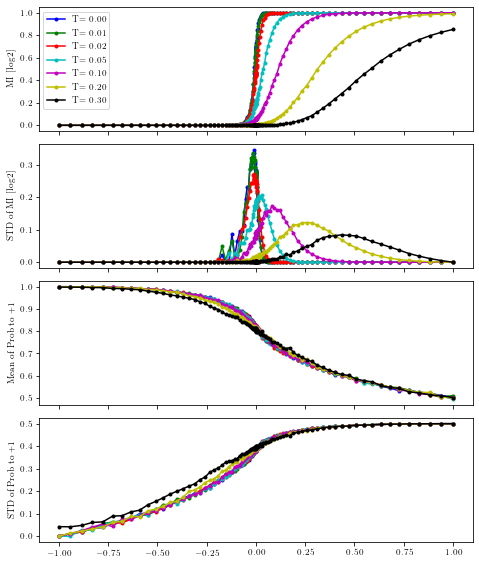

In [6]:
fig,axs=plt.subplots(4,1,figsize=(6.8,8),sharex=True)
colorlist='bgrcmyk'
ax=axs[0]
for i,color in zip(delta_dict_para.keys(),colorlist):
    ax.plot(delta_dict_para[i],np.mean(mutual_info_dis_dict_para[i],axis=1)/np.log(2),'.-',label='T= {:.2f}'.format(i),color=color)
ax.legend()
ax.set_ylabel(r'MI [$\log2$]')

ax=axs[1]
for i,color in zip(delta_dict_para.keys(),colorlist):
    ax.plot(delta_dict_para[i],np.std(mutual_info_dis_dict_para[i],axis=1)/np.log(2),'.-',label='T= {:.2f}'.format(i),color=color)
ax.set_ylabel(r'STD of MI [$\log2$]')

ax=axs[2]
for i,color in zip(delta_dict_para.keys(),colorlist):
    ax.plot(delta_dict_para[i],np.mean(s_history_dis_dict_para[i],axis=(1,2)),'.-',label='T= {:.2f}'.format(i),color=color)
# ax.legend()
ax.set_ylabel(r'Mean of Prob to +1')

ax=axs[3]
for i,color in zip(delta_dict_para.keys(),colorlist):
    ax.plot(delta_dict_para[i],np.std(s_history_dis_dict_para[i],axis=(1,2)),'.-',label='T= {:.2f}'.format(i),color=color)
# ax.legend()
ax.set_ylabel(r'STD of Prob to +1')

fig.tight_layout()
# fig.savefig('/mnt/d/KITP/Rp_SPT/5/MI_Born_Es_{:d}_T.pdf'.format(es),bbox_inches='tight')


In [7]:
es=10000
with open('/mnt/d/KITP/Rp_SPT/5/mutual_info_Born_En{:d}_T.pickle'.format(es),'rb') as f:
    delta_dict_para,mutual_info_dis_dict_para,s_history_dis_dict_para=pickle.load(f)

In [4]:
es=1000
with open('/mnt/d/KITP/Rp_SPT/6/MI_Born_En{:d}_T.pickle'.format(es),'rb') as f:
    delta_dict_para,mutual_info_dis_dict_para,log_neg_dis_dict_para,s_history_dis_dict_para=pickle.load(f)

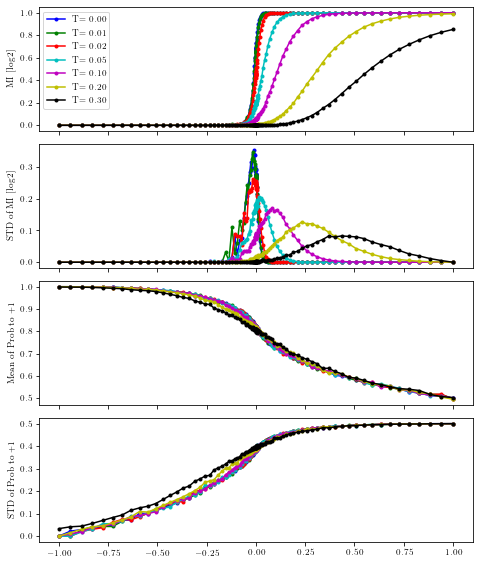

In [5]:
fig,axs=plt.subplots(4,1,figsize=(6.8,8),sharex=True)
colorlist='bgrcmyk'
ax=axs[0]
for i,color in zip(delta_dict_para.keys(),colorlist):
    ax.plot(delta_dict_para[i],np.mean(mutual_info_dis_dict_para[i],axis=1)/np.log(2),'.-',label='T= {:.2f}'.format(i),color=color)
ax.legend()
ax.set_ylabel(r'MI [$\log2$]')

ax=axs[1]
for i,color in zip(delta_dict_para.keys(),colorlist):
    ax.plot(delta_dict_para[i],np.std(mutual_info_dis_dict_para[i],axis=1)/np.log(2),'.-',label='T= {:.2f}'.format(i),color=color)
ax.set_ylabel(r'STD of MI [$\log2$]')

ax=axs[2]
for i,color in zip(delta_dict_para.keys(),colorlist):
    ax.plot(delta_dict_para[i],np.mean(s_history_dis_dict_para[i],axis=(1,2)),'.-',label='T= {:.2f}'.format(i),color=color)
# ax.legend()
ax.set_ylabel(r'Mean of Prob to +1')

ax=axs[3]
for i,color in zip(delta_dict_para.keys(),colorlist):
    ax.plot(delta_dict_para[i],np.std(s_history_dis_dict_para[i],axis=(1,2)),'.-',label='T= {:.2f}'.format(i),color=color)
# ax.legend()
ax.set_ylabel(r'STD of Prob to +1')

fig.tight_layout()
# fig.savefig('/mnt/d/KITP/Rp_SPT/5/MI_Born_Es_{:d}_T.pdf'.format(es),bbox_inches='tight')


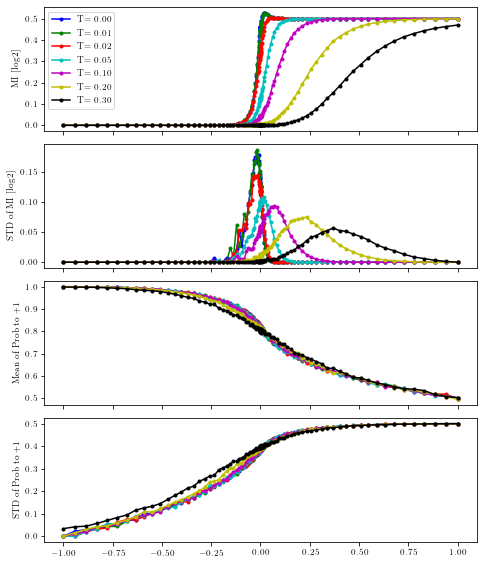

In [6]:
fig,axs=plt.subplots(4,1,figsize=(6.8,8),sharex=True)
colorlist='bgrcmyk'
ax=axs[0]
for i,color in zip(delta_dict_para.keys(),colorlist):
    ax.plot(delta_dict_para[i],np.mean(log_neg_dis_dict_para[i],axis=1)/np.log(2),'.-',label='T= {:.2f}'.format(i),color=color)
ax.legend()
ax.set_ylabel(r'MI [$\log2$]')

ax=axs[1]
for i,color in zip(delta_dict_para.keys(),colorlist):
    ax.plot(delta_dict_para[i],np.std(log_neg_dis_dict_para[i],axis=1)/np.log(2),'.-',label='T= {:.2f}'.format(i),color=color)
ax.set_ylabel(r'STD of MI [$\log2$]')

ax=axs[2]
for i,color in zip(delta_dict_para.keys(),colorlist):
    ax.plot(delta_dict_para[i],np.mean(s_history_dis_dict_para[i],axis=(1,2)),'.-',label='T= {:.2f}'.format(i),color=color)
# ax.legend()
ax.set_ylabel(r'Mean of Prob to +1')

ax=axs[3]
for i,color in zip(delta_dict_para.keys(),colorlist):
    ax.plot(delta_dict_para[i],np.std(s_history_dis_dict_para[i],axis=(1,2)),'.-',label='T= {:.2f}'.format(i),color=color)
# ax.legend()
ax.set_ylabel(r'STD of Prob to +1')

fig.tight_layout()
# fig.savefig('/mnt/d/KITP/Rp_SPT/5/MI_Born_Es_{:d}_T.pdf'.format(es),bbox_inches='tight')


Text(0, 0.5, 'LN [log 2]')

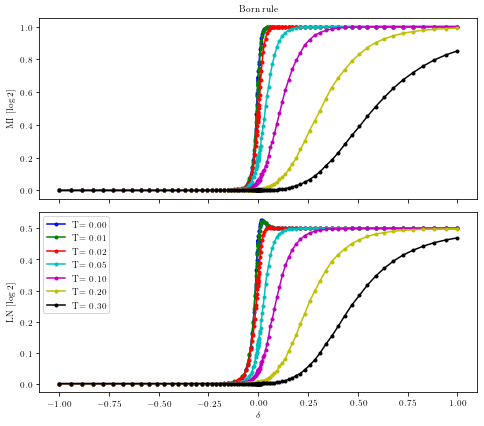

In [7]:
fig,axs=plt.subplots(2,1,sharex=True,figsize=(6.8,6),tight_layout=True)
ax=axs[0]
for i,color in zip(delta_dict_para.keys(),colorlist):
    ax.plot(delta_dict_para[i],np.mean(mutual_info_dis_dict_para[i],axis=1)/np.log(2),'.-',label='T= {:.2f}'.format(i),color=color)
ax.set_title('Born rule')
ax.set_ylabel('MI [log 2]')

ax=axs[1]
for i,color in zip(delta_dict_para.keys(),colorlist):
    ax.plot(delta_dict_para[i],np.mean(log_neg_dis_dict_para[i],axis=1)/np.log(2),'.-',label='T= {:.2f}'.format(i),color=color)
ax.legend()

ax.legend()
ax.set_xlabel(r'$\delta$')
ax.set_ylabel('LN [log 2]')

# fig.savefig('/mnt/d/kitp/Rp_SPT/6/MI_LN_T_Born.pdf')

Text(0, 0.5, 'MI')

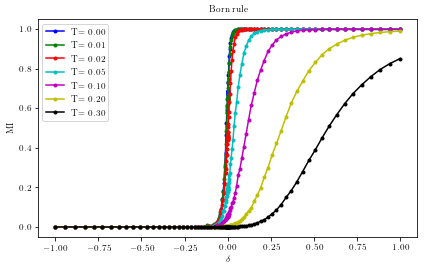

In [8]:
fig,ax=plt.subplots()
for i,color in zip(delta_dict_para.keys(),colorlist):
    ax.plot(delta_dict_para[i],np.mean(mutual_info_dis_dict_para[i],axis=1)/np.log(2),'.-',label='T= {:.2f}'.format(i),color=color)
ax.legend()
ax.set_title('Born rule')
ax.set_xlabel(r'$\delta$')
ax.set_ylabel('MI')
# fig.savefig('/mnt/d/kitp/Rp_SPT/6/MI_T_Born.pdf')

In [9]:
es=1000
with open('/mnt/d/KITP/Rp_SPT/6/MI_Born_En{}_T_map.pickle'.format(es),'rb') as f:
    delta_dict_para,mutual_info_dis_dict_para,log_neg_dis_dict_para,s_history_dis_dict_para=pickle.load(f)

In [ ]:
es=3000
with open('/mnt/d/KITP/Rp_SPT/6/MI_Born_En{}_T.pickle'.format(es),'rb') as f:
    delta_dict_para,log_neg_dis_dict_para,T_list=pickle.load(f)

In [ ]:
mutual_info_mean=np.array(list(mutual_info_dis_dict_para.values())).mean(axis=2)
mutual_info_std=np.array(list(mutual_info_dis_dict_para.values())).std(axis=2)

In [ ]:
T_list=np.linspace(0,8e-1,50)

In [ ]:
log_neg_mean=np.array(list(log_neg_dis_dict_para.values())).mean(axis=2)
log_neg_std=np.array(list(log_neg_dis_dict_para.values())).std(axis=2)

In [ ]:
z0=np.array(list(mutual_info_dis_dict_para.values()))

In [ ]:
z1=np.array(list(log_neg_dis_dict_para.values()))

In [ ]:
(z1-z0)

In [ ]:
with open('Born.pickle','wb') as f:
    pickle.dump([Born_mean,Born_std],f)

In [ ]:
with open('/mnt/d/KITP/Rp_SPT/5/Born.pickle','rb') as f:
    Born_mean,Born_std=pickle.load(f)


In [ ]:
with open('/mnt/d/KITP/Rp_SPT/5/Born_2.pickle','rb') as f:
    Born_mean,Born_std=pickle.load(f)


NameError: name 'delta_dict_para' is not defined

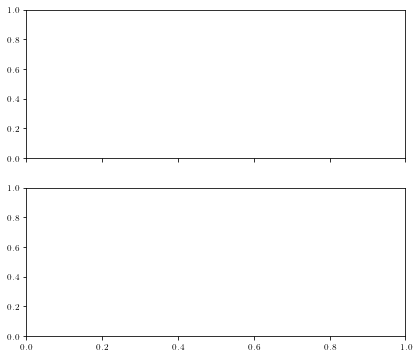

In [4]:
fig,axs=plt.subplots(2,1,sharex=True,figsize=(6.8,6))
color='magma'
ax=axs[0]
im=ax.pcolormesh(delta_dict_para[0],T_list,Born_mean/np.log(2),shading='auto',cmap=color)
ax.set_ylabel(r'$T$')
ax.text(0.5,1,'Mean of MI using Born rule',ha='center',va='bottom',transform=ax.transAxes)
axins=ax.inset_axes([1.02, 0, 0.03, 1],transform=ax.transAxes)
cb=fig.colorbar(im,cax=axins)    

ax=axs[1]
im=ax.pcolormesh(delta_dict_para[0],T_list,Born_std/np.log(2),shading='auto',cmap=color)
ax.text(0.5,1,'STD of MI using Born rule',ha='center',va='bottom',transform=ax.transAxes)
axins=ax.inset_axes([1.02, 0, 0.03, 1],transform=ax.transAxes)
cb=fig.colorbar(im,cax=axins) 

axs[0].text(1.01,1,'MI (log 2)',transform=axs[0].transAxes,ha='left',va='bottom')

ax.set_xlabel(r'$\delta$')
ax.set_ylabel(r'$T$')

fig.tight_layout()

# fig.savefig('/mnt/d/kitp/Rp_SPT/6/MI_Born_Es_1000_T_Map.pdf',bbox_inches='tight')

### proj using Born

In [7]:
L_list=[64,128,256]

In [8]:
es=3000
# L_list=[64,128,256]
delta_dict_para={}
log_neg_dis_dict_para={}
T_list={}
#L=64
# with open('/mnt/d/KITP/Rp_SPT/6/MI_Born_En{}_T.pickle'.format(es),'rb') as f:
for L in L_list:
    with open('/mnt/d/KITP/Rp_SPT/12/MI_Born_En3000_L{:d}_Born_T.pickle'.format(L,es),'rb') as f:
        delta_dict_para[L],log_neg_dis_dict_para[L],T_list[L]=pickle.load(f)

In [9]:
log_neg_mean={}
log_neg_std={}
for L in L_list:
    log_neg_mean[L]=np.array(list(log_neg_dis_dict_para[L].values())).mean(axis=2)
    log_neg_std[L]=np.array(list(log_neg_dis_dict_para[L].values())).std(axis=2)

In [10]:
def find_grad(x,y,z):
    gx,gy=np.gradient(z)
    g2=gx**2+gy**2
    y_max=y[g2.argmax(axis=0)]
    return x,y_max

In [11]:
inflection={}
for L in L_list:
    inflection[L]=find_grad(list(delta_dict_para[L].values())[0],T_list[L],log_neg_mean[L])

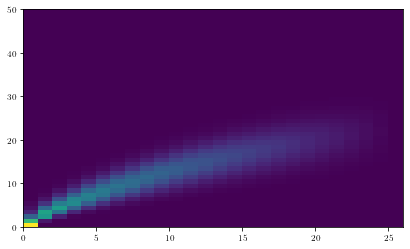

In [12]:
plt.pcolormesh(log_neg_std[L])

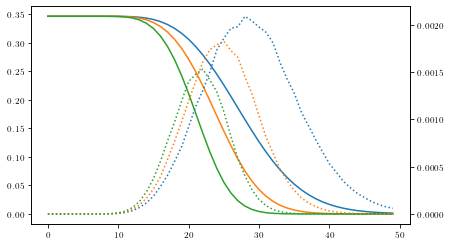

In [13]:
fig,ax=plt.subplots()
ax1=ax.twinx()
for L in L_list:
    ax.plot(log_neg_mean[L][:,24])
    ax1.plot(log_neg_std[L][:,24],ls=':')

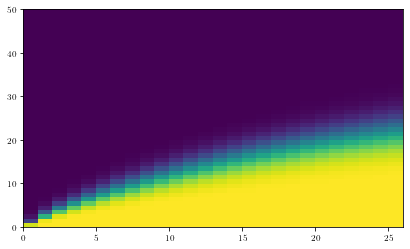

In [14]:
plt.pcolormesh(log_neg_mean[L])

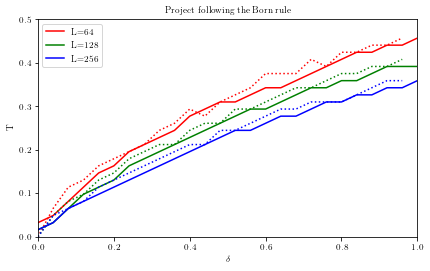

In [19]:
fig,ax=plt.subplots()
color_list='rgb'
for L,color in zip(L_list,color_list):
    ax.plot(*inflection[L],label='L={:d}'.format(L),color=color)
    ax.plot(list(delta_dict_para[L].values())[0][:-1],T_list[L][log_neg_std[L].argmax(axis=0)][:-1],':',color=color)
ax.legend()
ax.set_xlabel(r'$\delta$')
ax.set_ylabel('T')

ax.set_title('Project following the Born rule')

ax.margins(x=0,y=0)
ax.set_ylim([0,0.5])



fig.savefig('/mnt/d/kitp/Rp_SPT/12/Maj_Finite_T_Born.pdf')

In [53]:
T_list[L][log_neg_std[L].argmax(axis=0)]

array([0.        , 0.04897959, 0.06530612, 0.08163265, 0.11428571,
       0.13061224, 0.14693878, 0.16326531, 0.17959184, 0.19591837,
       0.2122449 , 0.2122449 , 0.24489796, 0.24489796, 0.26122449,
       0.27755102, 0.29387755, 0.29387755, 0.31020408, 0.31020408,
       0.31020408, 0.32653061, 0.34285714, 0.35918367, 0.35918367,
       0.11428571])

<ipython-input-104-22bd694ef504>:4: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  im=ax.pcolormesh(delta_dict_para[0],T_list,log_neg_mean/np.log(2),shading='flat',cmap=color)


Text(0, 0.5, '$T$')

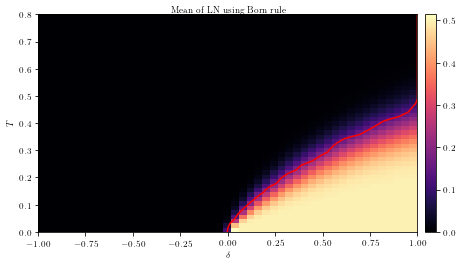

In [104]:
fig,axs=plt.subplots(1,1,sharex=True)
color='magma'
ax=axs
im=ax.pcolormesh(delta_dict_para[0],T_list,log_neg_mean/np.log(2),shading='flat',cmap=color)
ax.set_ylabel(r'$T$')
ax.text(0.5,1,'Mean of LN using Born rule',ha='center',va='bottom',transform=ax.transAxes)
axins=ax.inset_axes([1.02, 0, 0.03, 1],transform=ax.transAxes)
cb=fig.colorbar(im,cax=axins)    
ax.margins(x=0)
ax.plot(inflection_list,T_list,color='r')

# ax=axs[1]
# im=ax.pcolormesh(delta_dict_para[0],T_list,log_neg_std/np.log(2),shading='flat',cmap=color)
# ax.text(0.5,1,'STD of LN using Born rule',ha='center',va='bottom',transform=ax.transAxes)
# axins=ax.inset_axes([1.02, 0, 0.03, 1],transform=ax.transAxes)
# cb=fig.colorbar(im,cax=axins) 

# axs[0].text(1.01,1, 'LN (log 2)',transform=axs[0].transAxes,ha='left',va='bottom')

ax.set_xlabel(r'$\delta$')
ax.set_ylabel(r'$T$')

# fig.tight_layout()

# fig.savefig('/mnt/d/kitp/Rp_SPT/6/LN_Born_Es_{:d}_Majorana_T_Map.pdf'.format(es),bbox_inches='tight')
# fig.savefig('/mnt/d/kitp/Rp_SPT/6/LN_Born_Es_{:d}_Majorana_L128_T_Map.pdf'.format(es),bbox_inches='tight')

In [14]:
es=3000
with open('/mnt/d/KITP/Rp_SPT/6/MI_Born_En{}_L128_T.pickle'.format(es),'rb') as f:
    delta_dict_para,log_neg_dis_dict_para,T_list=pickle.load(f)

In [15]:
log_neg_mean=np.array(list(log_neg_dis_dict_para.values())).mean(axis=2)
log_neg_std=np.array(list(log_neg_dis_dict_para.values())).std(axis=2)

In [16]:
inflection_list=[find_inflection(delta_dict_para[0],x/np.log(2)) for x in log_neg_mean]

<ipython-input-17-d31f1f99ee59>:4: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  im=ax.pcolormesh(delta_dict_para[0],T_list,log_neg_mean/np.log(2),shading='flat',cmap=color)


Text(0, 0.5, '$T$')

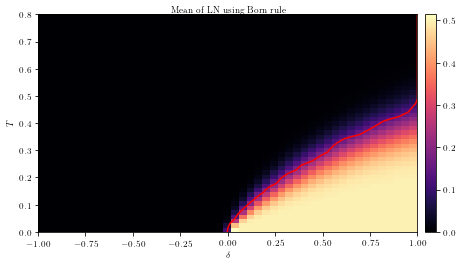

In [17]:
fig,axs=plt.subplots(1,1,sharex=True)
color='magma'
ax=axs
im=ax.pcolormesh(delta_dict_para[0],T_list,log_neg_mean/np.log(2),shading='flat',cmap=color)
ax.set_ylabel(r'$T$')
ax.text(0.5,1,'Mean of LN using Born rule',ha='center',va='bottom',transform=ax.transAxes)
axins=ax.inset_axes([1.02, 0, 0.03, 1],transform=ax.transAxes)
cb=fig.colorbar(im,cax=axins)    
ax.margins(x=0)
ax.plot(inflection_list,T_list,color='r')

ax.set_xlabel(r'$\delta$')
ax.set_ylabel(r'$T$')

# fig.savefig('/mnt/d/kitp/Rp_SPT/6/LN_Born_Es_{:d}_Majorana_L128_T_Map.pdf'.format(es),bbox_inches='tight')

### proj to n=1

In [18]:
es=2
# '/mnt/d/KITP/Rp_SPT/6/'
with open('MI_Born_En{}_L64_1_T.pickle'.format(es),'rb') as f:
    delta_dict_1,log_neg_dis_dict_1,T_list=pickle.load(f)

In [19]:
log_neg_mean_1=np.array(list(log_neg_dis_dict_1.values())).mean(axis=2)
log_neg_std_1=np.array(list(log_neg_dis_dict_1.values())).std(axis=2)

In [20]:
inflection_1_list=[find_inflection(delta_dict_1[0],x/np.log(2)) for x in log_neg_mean_1]

<ipython-input-21-a0afd305ee33>:4: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  im=ax.pcolormesh(delta_dict_1[0],T_list,log_neg_mean_1/np.log(2),shading='flat',cmap=color)


Text(0, 0.5, '$T$')

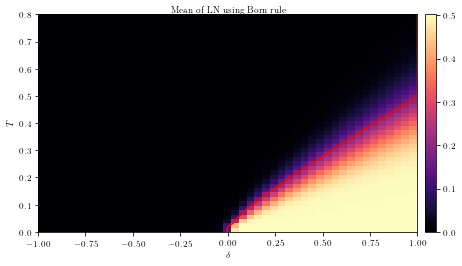

In [21]:
fig,axs=plt.subplots(1,1,sharex=True)
color='magma'
ax=axs
im=ax.pcolormesh(delta_dict_1[0],T_list,log_neg_mean_1/np.log(2),shading='flat',cmap=color)
ax.set_ylabel(r'$T$')
ax.text(0.5,1,'Mean of LN using Born rule',ha='center',va='bottom',transform=ax.transAxes)
axins=ax.inset_axes([1.02, 0, 0.03, 1],transform=ax.transAxes)
cb=fig.colorbar(im,cax=axins)    
ax.margins(x=0)
ax.plot(inflection_1_list,T_list,color='r')

ax.set_xlabel(r'$\delta$')
ax.set_ylabel(r'$T$')

# fig.savefig('/mnt/d/kitp/Rp_SPT/6/LN_Born_Es_{:d}_Majorana_L128_T_Map.pdf'.format(es),bbox_inches='tight')

In [ ]:
T_list[6]

In [ ]:
inflection_list[6]

In [ ]:
inflection_1_list[1]

In [ ]:
fig,ax=plt.subplots()
ax.plot(inflection_list,T_list,color='b')
ax.plot(inflection_1_list,T_list,color='r')


## T-dependce at fixed $\delta$

In [22]:
def run(p):
    delta,T,LA,LAp,mtype=p
    params=Params(delta=delta,L=np.inf,bc=-1,basis='m',T=T)
    subregionA=np.arange(0,LA)
    subregionAp=np.arange(LA,LA+LB)
    subregionB=np.arange(LA+LB,2*LA+LB)
    
    if mtype=='Born':
        params.measure_all_Born(proj_range=subregionAp)
    elif mtype=='1':
        params.measure_all(0)
    LN=params.log_neg(subregionA,subregionB)
    return LN

In [23]:
run((0.5,0,10,20,'link'))

TypeError: 'float' object cannot be interpreted as an integer

In [24]:
T_list=np.linspace(0,6e-1,20)
mtype='Born'
L_list=[16,32,64,96,128,128+64,256]
es=100
LN_map=np.zeros((len(L_list),len(T_list),es))
for L_i,L in enumerate(L_list):
    for T_i,T in enumerate(T_list):
        inputs=[(0.5,T,L,mtype) for _ in range(es)]    
        async_results=rc[:].map_sync(run,inputs)
        LN_map[L_i,T_i]=async_results
    

NameError: name 'rc' is not defined

In [ ]:
T_list=np.linspace(0,6e-1,20)
mtype='Born'
L_list=[16,32,64,128,256,512]
es=100
LN_d1_map=np.zeros((len(L_list),len(T_list),es))
for L_i,L in enumerate(L_list):
    for T_i,T in enumerate(T_list):
        inputs=[(1,T,L,mtype) for _ in range(es)]    
        async_results=rc[:].map_sync(run,inputs)
        LN_d1_map[L_i,T_i]=async_results
    

In [ ]:
fig,ax=plt.subplots()
colorlist=('bgrcmyk')
for (L_i,L),color in zip(enumerate(L_list),colorlist):
    ax.plot(T_list,LN_map.mean(axis=2)[L_i]/np.log(2),label='L={}'.format(L),color=color)
ax.legend()
ax.set_xlabel('T')
ax.set_ylabel('log neg [log 2]')
ax.margins(x=0)

In [ ]:
fig,ax=plt.subplots()
colorlist=('bgrcmyk')
for (L_i,L),color in zip(enumerate(L_list),colorlist):
    ax.plot(T_list,LN_d1_map.mean(axis=2)[L_i]/np.log(2),label='L={}'.format(L),color=color)
ax.legend()
ax.set_xlabel('T')
ax.set_ylabel('log neg [log 2]')
ax.margins(x=0)

## Scaling behavior

### Project to occupied

In [198]:
T_list=np.linspace(0,6e-1,50)
delta_list=np.linspace(-1,1,100)**3


def parallel_func(TL):
    T,L=TL
    delta_list=np.linspace(-1,1,100)**3
    mutual_info_neg_map_slice=np.zeros(len(delta_list))

    # all projections to s=-1
    for delta_i,delta in enumerate(delta_list):    
        params=Params(delta=delta,L=L,bc=-1,T=T)
        params.measure_all(0)
        mutual_info_neg_map_slice[delta_i]=(params.mutual_information_m(np.arange((params.L//4)),np.arange(params.L//4)+params.L//2))
    return mutual_info_neg_map_slice


In [199]:
L=64
input_list=[(T,L) for T in T_list]
async_result_L64=rc[:].map_sync(parallel_func,input_list)
# async_result_L64=map(parallel_func,input_list)

In [39]:
L=128
input_list=[(T,L) for T in T_list]
async_result_L128=rc[:].map_sync(parallel_func,input_list)

In [40]:
L=256
input_list=[(T,L) for T in T_list]
async_result_L256=rc[:].map_sync(parallel_func,input_list)

In [200]:
mutual_info_neg_map_para_L64=np.zeros((len(T_list),len(delta_list)))
for idx,results in enumerate(async_result_L64):
    mutual_info_neg_map_para_L64[idx,:]=(results)

In [42]:
mutual_info_neg_map_para_L128=np.zeros((len(T_list),len(delta_list)))
for idx,results in enumerate(async_result_L128):
    mutual_info_neg_map_para_L128[idx,:]=(results)

In [43]:
mutual_info_neg_map_para_L256=np.zeros((len(T_list),len(delta_list)))
for idx,results in enumerate(async_result_L256):
    mutual_info_neg_map_para_L256[idx,:]=(results)

In [46]:
inflection_L64_list=[find_inflection(delta_list,x/np.log(2)) for x in mutual_info_neg_map_para_L64]

In [47]:
inflection_L128_list=[find_inflection(delta_list,x/np.log(2)) for x in mutual_info_neg_map_para_L128]

In [48]:
inflection_L256_list=[find_inflection(delta_list,x/np.log(2)) for x in mutual_info_neg_map_para_L256]

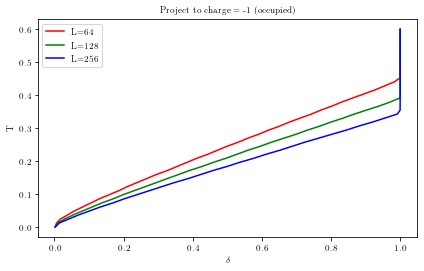

In [50]:
fig,ax=plt.subplots()
ax.plot(inflection_L64_list,T_list,label='L=64',color='r')
ax.plot(inflection_L128_list,T_list,label='L=128',color='g')
ax.plot(inflection_L256_list,T_list,label='L=256',color='b')
ax.legend()
ax.set_xlabel(r'$\delta$')
ax.set_ylabel('T')

ax.set_title('Project to charge = -1 (occupied)')

fig.savefig('/mnt/d/kitp/Rp_SPT/12/Maj_Finite_T_occ.pdf')

### Proj to occupied with inf L

In [3]:
T_list=np.linspace(0,6e-1,50)
# delta_list=np.linspace(-1,1,100)**3


# def parallel_func_inf_L(TL):
#     T,dmax=TL
#     delta_list=np.linspace(-1,1,100)**3
#     mutual_info_neg_map_slice=np.zeros(len(delta_list))

#     # all projections to s=-1
#     for delta_i,delta in enumerate(delta_list):    
#         params=Params(delta=delta,L=np.inf,bc=-1,T=T,dmax=dmax,basis='f')
#         subA=np.arange(16)
#         subB=np.arange(dmax-16,dmax)
#         subAp=np.arange(16,dmax-16)
#         params.measure_all(0,proj_range=subAp)
#         mutual_info_neg_map_slice[delta_i]=params.mutual_information_m(subA,subB)
#     return mutual_info_neg_map_slice

def parallel_func_inf_L(TL):
    T,dmax=TL
    # delta_list=np.linspace(-1,1,100)**3
    # mutual_info_neg_map_slice=np.zeros(len(delta_list))

    # all projections to s=-1
    params=Params(delta=1,L=np.inf,bc=-1,T=T,dmax=dmax,basis='f')
    subA=np.arange(16)
    subB=np.arange(dmax-16,dmax)
    subAp=np.arange(16,dmax-16)
    params.measure_all(0,proj_range=subAp)
    return params.mutual_information_m(subA,subB)


In [9]:
dmax_list=2**np.arange(6,9)
MI_neg_infL=np.zeros((dmax_list.shape[0],50))
T_list=np.zeros((dmax_list.shape[0],50))
inflection_infL_list=np.zeros(dmax_list.shape[0])
Tmax=6e-1
for dmax_index,dmax in enumerate(dmax_list):
    print(dmax)
    T_list[dmax_index]=np.linspace(0,Tmax,50)
    input_list=[(T,dmax) for T in T_list[dmax_index]]
    MI_neg_infL[dmax_index]=rc[:].map_sync(parallel_func_inf_L,input_list)
    inflection_infL_list[dmax_index]=find_inflection(T_list[dmax_index],MI_neg_infL[dmax_index]/np.log(2))
    Tmax=inflection_infL_list[dmax_index]

64
128
256


In [37]:
# with open('Maj_infL_occ_T.pickle','rb') as f:
with open('/mnt/d/KITP/Rp_SPT/12/Maj_infL_occ_T.pickle','rb') as f:
    [dmax_list,T_list,MI_neg_infL,inflection_infL_list]=pickle.load(f)


In [53]:
MI_neg_infL[0].shape

(50,)

In [60]:
find_inflection(T_list[0],MI_neg_infL[0])

(0.3486973947895791, 0.37702381029071963)

In [63]:
inflection_list=[]
inflection_val_list=[]
for x,y in zip(T_list,MI_neg_infL):
    z=find_inflection(x,y)
    inflection_list.append(z[0])
    inflection_val_list.append(z[1])

In [62]:
[find_inflection(x,y) for x,y in zip(T_list,MI_neg_infL)]

[(0.3486973947895791, 0.37702381029071963),
 (0.31561680475178816, 0.36201811911656256),
 (0.2981779881786376, 0.3561054860146955),
 (0.2792831580411286, 0.34545003142199615),
 (0.267550444149253, 0.3412456205808532),
 (0.2533814685117095, 0.33461508116427374),
 (0.24432185698705366, 0.3311690205702225),
 (0.2325380076245232, 0.3287070600332172)]

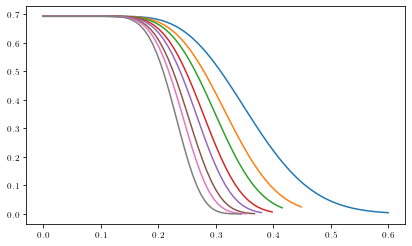

In [38]:
for T,MI in zip(T_list,MI_neg_infL):
    plt.plot(T,MI)

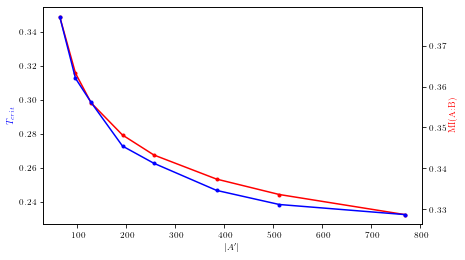

In [70]:
fig,ax=plt.subplots()

ax.plot(dmax_list,inflection_infL_list,'.-',color='r')
ax1=ax.twinx()
ax1.plot(dmax_list,inflection_val_list,'.-',color='b')
ax1.set_ylabel('MI(A:B)',color='r')
ax.set_xlabel('$|A^\prime|$')
ax.set_ylabel('$T_{crit}$ ',color='b')
fig.savefig('/mnt/d/KITP/Rp_SPT/12/Maj_Finite_T_occ_infL.pdf')


### Project using Born

In [27]:
T_list=np.linspace(0,6e-1,50)
es=100

def parallel_func(TL):
    T,L=TL
    delta_list=np.linspace(0,1,100)**3
    mutual_info_Born_map_slice=np.zeros(len(delta_list))

    for delta_i,delta in enumerate(delta_list):    
        params=Params(delta=delta,L=L,bc=-1,T=T)
        params.measure_all_Born(0)
        mutual_info_Born_map_slice[delta_i]=(params.mutual_information_m(np.arange((params.L//2)),np.arange(params.L//2)+params.L))
    return mutual_info_Born_map_slice



<AsyncResult: execute>

In [ ]:
L=64
input_list=[(T,L) for T in T_list]
async_result_L64=rc[:].map_async(parallel_func,input_list)

# Infinite temperature

In [ ]:
params_m=Params(delta=0,L=64,bc=-1,basis='mf',T=np.inf)
params_m.bandstructure()
Esum=[np.random.choice(params_m.val_m,params_m.L,replace=False).sum()/params_m.L for i in range(2000)]

In [ ]:
fig,ax=plt.subplots(2,1,sharex=True,gridspec_kw=dict(height_ratios=[3,1]),tight_layout=True)
ax[0].hist(Esum,bins=11)
ax[1].set_xlabel('Mean energy')
ax[0].set_ylabel('Occurence')
ax[1].set_yticks([])
ax[1].scatter(Esum,np.ones(len(Esum)),s=0.1)
# fig.savefig('/mnt/d/kitp/Rp_SPT/11/Majorana_d1.pdf')

In [ ]:
params_m=Params(delta=0.5,L=64,bc=-1,basis='mf',T=np.inf)
params_m.bandstructure()
Esum=[np.random.choice(params_m.val_m,params_m.L,replace=False).sum()/params_m.L for i in range(2000)]

In [ ]:
fig,ax=plt.subplots(2,1,sharex=True,gridspec_kw=dict(height_ratios=[3,1]),tight_layout=True)
ax[0].hist(Esum,bins=11)
ax[1].set_xlabel('Mean energy')
ax[0].set_ylabel('Occurence')
ax[1].set_yticks([])
ax[1].scatter(Esum,np.ones(len(Esum)),s=0.1)
fig.savefig('/mnt/d/kitp/Rp_SPT/6/Majorana_d0.5.pdf')

In [ ]:
params_m=Params(delta=0.,L=64,bc=-1,basis='mf',T=np.inf)
params_m.bandstructure()
Esum=[np.random.choice(params_m.val_m,params_m.L,replace=False).sum()/params_m.L for i in range(2000)]

In [ ]:
fig,ax=plt.subplots(2,1,sharex=True,gridspec_kw=dict(height_ratios=[3,1]),tight_layout=True)
ax[0].hist(Esum,bins=11)
ax[1].set_xlabel('Mean energy')
ax[0].set_ylabel('Occurence')
ax[1].set_yticks([])
ax[1].scatter(Esum,np.ones(len(Esum)),s=0.1)
fig.savefig('/mnt/d/kitp/Rp_SPT/6/Majorana_d0.pdf')

In [ ]:
params_m=Params(delta=-.5,L=64,bc=-1,basis='mf',T=np.inf)
params_m.bandstructure()
Esum=[np.random.choice(params_m.val_m,params_m.L,replace=False).sum()/params_m.L for i in range(2000)]

In [ ]:
fig,ax=plt.subplots(2,1,sharex=True,gridspec_kw=dict(height_ratios=[3,1]),tight_layout=True)
ax[0].hist(Esum,bins=11)
ax[1].set_xlabel('Mean energy')
ax[0].set_ylabel('Occurence')
ax[1].set_yticks([])
ax[1].scatter(Esum,np.ones(len(Esum)),s=0.1)
fig.savefig('/mnt/d/kitp/Rp_SPT/6/Majorana_d-0.5.pdf')

In [ ]:
params_m=Params(delta=-1,L=64,bc=-1,basis='mf',T=np.inf)
params_m.bandstructure()
Esum=[np.random.choice(params_m.val_m,params_m.L,replace=False).sum()/params_m.L for i in range(2000)]

In [ ]:
fig,ax=plt.subplots(2,1,sharex=True,gridspec_kw=dict(height_ratios=[3,1]),tight_layout=True)
ax[0].hist(Esum,bins=11)
ax[1].set_xlabel('Mean energy')
ax[0].set_ylabel('Occurence')
ax[1].set_yticks([])
ax[1].scatter(Esum,np.ones(len(Esum)),s=0.1)
fig.savefig('/mnt/d/kitp/Rp_SPT/6/Majorana_d-1.pdf')

In [ ]:
# params=Params(delta=-1,L=128,bc=-1,basis='mf')
params=Params(delta=0.,L=128,bc=-1,basis='mf',T=np.inf,E0=0,dE=0.05,kappa=0.5)

In [ ]:
params.covariance_matrix_f()

In [ ]:
params.mutual_information_m(np.arange(L//2),np.arange(L//2)+L)

In [ ]:
params.log_neg(np.arange(L//2),np.arange(L//2)+L)

In [ ]:
params.von_Neumann_entropy_m(np.arange(params.L))/(params.L)

In [ ]:
LN_dict={}

In [ ]:
es=100
L=128
m_list=np.arange(1,L+1,10)
kappa_list=[.1,.3,.5,.8]
for kappa in kappa_list:
    LN_dict[kappa]=np.zeros((m_list.shape[0],es))
    for m_i,m in enumerate(m_list):
        LN=[Params(delta=0,L=L,bc=-1,T=np.inf,E0=0,dE=0.01,kappa=kappa,basis='f').von_Neumann_entropy_m(np.arange(m))/(L) for _ in range(es)]
        LN_dict[kappa][m_i,:]=LN

In [ ]:
fig,ax=plt.subplots()
color_list='rgby'
for kappa,color in zip(kappa_list,color_list):
    ax.errorbar(m_list/(2*L),LN_dict[kappa].mean(axis=1),LN_dict[kappa].std(axis=1)/np.sqrt(es),fmt='.',capsize=3,label='$\kappa$={:.1f}'.format(kappa),color=color)
ax.grid('on')
ax.legend()
for kappa,color in zip(kappa_list,color_list):
    ax.plot(m_list/(2*L),analy_dict[kappa],color=color)
    # ax.errorbar(m_list,LN_dict[kappa].mean(axis=1),LN_dict[0.1].std(axis=1)/np.sqrt(es),fmt='.',capsize=3,label='{:.1f}'.format(kappa))
ax.set_yticks(np.linspace(0,0.2,11))
ax.set_xlabel('m/N')
ax.set_ylabel('S/N')
fig.savefig('/mnt/d/KITP/Rp_SPT/11/EE_Maj.pdf')

In [ ]:
import scipy.integrate as integrate
def func(kappa,lamb):
    lamb_p=(np.sqrt(kappa*(1-lamb))+np.sqrt(lamb*(1-kappa)))**2
    lamb_m=(np.sqrt(kappa*(1-lamb))-np.sqrt(lamb*(1-kappa)))**2
    integrand=lambda x:1/(2*np.pi*lamb)*np.sqrt((lamb_p-x)*(x-lamb_m))/(x*(1-x))*(-x*np.log(x)-(1-x)*np.log(1-x))
    integral=integrate.quad(integrand,lamb_m,lamb_p)
    return integral[0]

In [ ]:
analy_dict={}
for kappa in kappa_list:
    analy_dict[kappa]=[lamb*func(kappa,lamb) for lamb in m_list/(2*L)]

## MI & LN

In [ ]:
with open('/mnt/d/kitp/Rp_SPT/11/inf_T_Maj_no.pickle','rb') as f:
    MI_no_dict,LN_no_dict,E_no_mean=pickle.load(f)

In [ ]:
with open('/mnt/d/kitp/Rp_SPT/11/inf_T_Maj_onsite.pickle','rb') as f:
    MI_onsite_dict,LN_onsite_dict,E_onsite_mean=pickle.load(f)

In [ ]:
LN_no_mean_E0_list=[]
LN_no_std_E0_list=[]
MI_no_mean_E0_list=[]
MI_no_std_E0_list=[]
E=0
dE=0.05
L_list=np.array([16, 32, 64, 96, 128, 192, 256])
for L in L_list:
    energy=np.array(E_no_mean[L])
    logneg=np.array(LN_no_dict[L])
    mutinfo=np.array(MI_no_dict[L])
    mask=np.logical_and((E-dE)<energy,energy<(E+dE))
    LN_no_mean_E0_list.append(np.mean(logneg[mask]))
    LN_no_std_E0_list.append(np.std(logneg[mask]))
    MI_no_mean_E0_list.append(np.mean(mutinfo[mask]))
    MI_no_std_E0_list.append(np.std(mutinfo[mask]))


In [ ]:
LN_onsite_mean_E0_list=[]
LN_onsite_std_E0_list=[]
MI_onsite_mean_E0_list=[]
MI_onsite_std_E0_list=[]
E=0
dE=0.05
L_list=np.array([16, 32, 64, 96, 128, 192, 256])
for L in L_list:
    energy=np.array(E_onsite_mean[L])
    logneg=np.array(LN_onsite_dict[L])
    mutinfo=np.array(MI_onsite_dict[L])
    mask=np.logical_and((E-dE)<energy,energy<(E+dE))
    LN_onsite_mean_E0_list.append(np.mean(logneg[mask]))
    LN_onsite_std_E0_list.append(np.std(logneg[mask]))
    MI_onsite_mean_E0_list.append(np.mean(mutinfo[mask]))
    MI_onsite_std_E0_list.append(np.std(mutinfo[mask]))


In [ ]:
fig,ax=plt.subplots()

ax.errorbar(L_list,LN_no_mean_E0_list,LN_no_std_E0_list,fmt='.',label='no',color='r')
ax.errorbar(L_list,LN_onsite_mean_E0_list,LN_onsite_std_E0_list,fmt='.',label='onsite',color='b')

ax.set_xlabel('$N =2L$')
ax.set_ylabel('Log negativity')

lr_no=scipy.stats.linregress(L_list,LN_no_mean_E0_list)
ax.plot(L_list,lr_no.slope*L_list+lr_no.intercept,color='r',label='({:.3f} N+{:.2f})'.format(lr_no.slope,lr_no.intercept))
lr_onsite=scipy.stats.linregress(L_list,LN_onsite_mean_E0_list)
ax.plot(L_list,lr_onsite.slope*L_list+lr_onsite.intercept,color='b',label='({:.3f} N+{:.2f})'.format(lr_onsite.slope,lr_onsite.intercept))


ax.legend()
ax.set_title('E/L $\in$(-0.05,0.05)')
fig.savefig('/mnt/d/kitp/Rp_SPT/11/LN_L_delta0_E0_Maj.pdf')

In [ ]:
fig,ax=plt.subplots()

ax.errorbar(L_list,MI_no_mean_E0_list,MI_no_std_E0_list,fmt='.',label='no',color='r')
ax.errorbar(L_list,MI_onsite_mean_E0_list,MI_onsite_std_E0_list,fmt='.',label='onsite',color='b')

ax.set_xlabel('$N =2L$')
ax.set_ylabel('Mutual information ')

lr_no=scipy.stats.linregress(L_list,MI_no_mean_E0_list)
ax.plot(L_list,lr_no.slope*L_list+lr_no.intercept,color='r',label='({:.3f} N+{:.3f})'.format(lr_no.slope,lr_no.intercept))
lr_onsite=scipy.stats.linregress(L_list,MI_onsite_mean_E0_list)
ax.plot(L_list,lr_onsite.slope*L_list+lr_onsite.intercept,color='b',label='({:.3f} N+{:.3f})'.format(lr_onsite.slope,lr_onsite.intercept))


ax.legend()
ax.set_title('E/L $\in$(-0.05,0.05)')
fig.savefig('/mnt/d/kitp/Rp_SPT/11/MI_L_delta0_E0_Maj.pdf')

In [ ]:
fig,ax=plt.subplots()
L=64
ax.scatter(E_no_mean[L],np.array(LN_no_dict[L])/np.log(2),s=1)
ax.set_xlabel('$\\frac{E_{\\rm{tot}}}{L}$')
ax.set_ylabel('log neg [log 2]')
ax.set_title('L={}, no measurement'.format(L))

In [ ]:
fig,ax=plt.subplots()
L=64
ax.scatter(E_onsite_mean[L],np.array(LN_onsite_dict[L])/np.log(2),s=1)
ax.set_xlabel('$\\frac{E_{\\rm{tot}}}{L}$')
ax.set_ylabel('log neg [log 2]')
ax.set_title('L={}, onsite measurement'.format(L))

In [ ]:
E_list=np.arange(-0.2,0.2,0.05)
L=256
LN_no_mean={}
LN_no_std={}
ensemble_no={}
LN_no_mean[L]=[]
LN_no_std[L]=[]
ensemble_no[L]=[]
LN_no= np.array(LN_no_dict[L])
E_no=np.array(E_no_mean[L])
for E in E_list:
    dE=0.05
    mask=np.logical_and((E-dE)<E_no_mean[L],E_no_mean[L]<(E+dE))
    ensemble_no[L].append(LN_no[(mask)].shape[0])
    LN_no_mean[L].append(LN_no[mask].mean())
    LN_no_std[L].append(LN_no[mask].std()/np.sqrt(LN_no[(mask)].shape[0]))

In [ ]:
E_list=np.arange(-0.2,0.2,0.05)
# L=128
LN_onsite_mean={}
LN_onsite_std={}
ensemble_onsite={}
LN_onsite_mean[L]=[]
LN_onsite_std[L]=[]
ensemble_onsite[L]=[]
LN_onsite= np.array(LN_onsite_dict[L])
E_onsite=np.array(E_onsite_mean[L])
for E in E_list:
    dE=0.05
    mask=np.logical_and((E-dE)<E_onsite_mean[L],E_onsite_mean[L]<(E+dE))
    ensemble_onsite[L].append(LN_onsite[(mask)].shape[0])
    LN_onsite_mean[L].append(LN_onsite[mask].mean())
    LN_onsite_std[L].append(LN_onsite[mask].std()/np.sqrt(LN_onsite[(mask)].shape[0]))

In [ ]:
fig,axs=plt.subplots(2,2,figsize=(6.8,4),tight_layout=True)
# L=128

ax=axs[0,0]
ax.scatter(E_no_mean[L],np.array(LN_no_dict[L])/np.log(2),s=1)
ax.set_ylabel('log neg [log 2]')
ax.set_title('L={}, no measurement'.format(L))

ax=axs[1,0]
ax.scatter(E_onsite_mean[L],np.array(LN_onsite_dict[L])/np.log(2),s=1)
ax.set_ylabel('log neg [log 2]')
ax.set_title('L={}, onsite measurement'.format(L))


ax=axs[0,1]
ax.errorbar(E_list,LN_no_mean[L]/np.log(2),LN_no_std[L]/np.log(2),fmt='.')
ax.set_title('L={}, no measurement'.format(L))

ax=axs[1,1]
ax.errorbar(E_list,LN_onsite_mean[L]/np.log(2),LN_onsite_std[L]/np.log(2),fmt='.')
ax.set_title('L={}, onsite measurement'.format(L))



fig.savefig('/mnt/d/kitp/Rp_SPT/11/LN_purestate_L{}_Maj.pdf'.format(L))

# MI as a function of d(A,B) 

In [ ]:
delta_list=np.linspace(-1,1,100)**3
dist_list=np.arange(0,32,2)

def parallel_func(dist):
    T=0
    delta_list=np.linspace(-1,1,100)**3
    MI_map_slice=np.zeros(len(delta_list))
    MI_map_pos_slice=np.zeros(len(delta_list))
    MI_map_neg_slice=np.zeros(len(delta_list))

    for delta_i,delta in enumerate(delta_list):
        params=Params(delta=delta,L=64,bc=-1,T=T)
        subregionA=np.arange(params.L//2)
        subregionB=subregionA+dist+params.L//2        
        MI_map_slice[delta_i]=params.mutual_information_m(subregionA,subregionB)

        subregionAp=np.arange(params.L//2,params.L//2+dist,2)
        params.measure_all(1,subregionAp)
        MI_map_pos_slice[delta_i]=params.mutual_information_m(subregionA,subregionB)

        params=Params(delta=delta,L=64,bc=-1,T=T)
        params.measure_all(0,subregionAp)
        MI_map_neg_slice[delta_i]=params.mutual_information_m(subregionA,subregionB)

    return MI_map_slice,MI_map_pos_slice,MI_map_neg_slice

rc[:].execute("from Majorana_chain import *")
rc[:].execute("import numpy as np")
async_result=rc[:].map_sync(parallel_func,dist_list)
# z0,z1,z2=parallel_func(32)


In [ ]:
MI_map_para=np.zeros((len(dist_list),len(delta_list)))
MI_pos_map_para=np.zeros((len(dist_list),len(delta_list)))
MI_neg_map_para=np.zeros((len(dist_list),len(delta_list)))

for idx,results in enumerate(async_result):
    MI,MI_pos,MI_neg=results
    MI_map_para[idx,:]=(MI)
    MI_pos_map_para[idx,:]=(MI_pos)
    MI_neg_map_para[idx,:]=(MI_neg)

In [ ]:
plt.plot(delta_list,z0/np.log(2))

In [ ]:
plt.pcolor(delta_list,dist_list,MI_pos_map_para)

In [ ]:
plt.plot(delta_list,MI_pos_map_para[1])

# Evolution

In [ ]:
params=Params(delta=0.3,L=32,bc=-1)
params.mutual_information_m(np.arange(int(params.L/2)),np.arange(int(params.L/2))+params.L)
# params.measure_batch(1,(params.L/2,params.L))
params.measure(1,20,21)
params.measure(0,25,26)
params.measure(1,40,41)

In [ ]:
params.mutual_information_m(np.arange(int(params.L/2)),np.arange(int(params.L/2))+params.L)

In [ ]:
params.i_history

In [ ]:
params=Params(delta=0.3,L=32,bc=-1)
params.measure(1,40,21)
i=1
fig,ax=plt.subplots()
ax.imshow(params.C_m_history[i],cmap='seismic',vmin=-1,vmax=1)
# ax.text(0,1.05,r'Step {}: $\Upsilon_{}({},{})$'.format(i,'{'+str((-1)**s)+'}',params.i_history[i-1],params.i_history[i-1]+1),transform=ax.transAxes)

In [ ]:
params=Params(delta=0.3,L=32,bc=-1)
params.measure(0,40,21)
i=1
fig,ax=plt.subplots()
ax.imshow(params.C_m_history[i],cmap='seismic',vmin=-1,vmax=1)
# ax.text(0,1.05,r'Step {}: $\Upsilon_{}({},{})$'.format(i,'{'+str((-1)**s)+'}',params.i_history[i-1],params.i_history[i-1]+1),transform=ax.transAxes)

In [ ]:
i=0
c_m=params.C_m_history[0]
fig,ax=plt.subplots(1,2,figsize=(6.8,10))

im_1=ax[0].imshow(c_m,cmap='seismic',vmin=-1,vmax=1) 
im_2=ax[1].imshow(c_m@c_m,cmap='hot',vmin=-1,vmax=0) 

ax[0].set_xticks([])
ax[0].set_yticks([])
ax[1].set_xticks([])
ax[1].set_yticks([])

ax[0].text(0,1.05,'Step 0',transform=ax[0].transAxes)

axins0=ax[0].inset_axes([0.0, -.1, 1, 0.05],transform=ax[0].transAxes) 
cb0=fig.colorbar(im_1,cax=axins0,orientation='horizontal')
cb0.ax.xaxis.set_tick_params(pad=0)
# cb0.ax.tick_params(labelsize=20)

axins1=ax[1].inset_axes([0.0, -.1, 1, 0.05],transform=ax[1].transAxes) 
cb1=fig.colorbar(im_2,cax=axins1,orientation='horizontal')
cb1.ax.xaxis.set_tick_params(pad=0)
# cb1.ax.tick_params(labelsize=20)

# fig.savefig('/mnt/d/kitp/Rp_SPT/4/evolution_trivial_{}.pdf'.format(i),bbox_inches='tight',dpi=500)

In [ ]:
%%capture
for i,c_m,s,ii in zip(range(1,21),params.C_m_history[1:],params.s_history,params.i_history):
    
    fig,ax=plt.subplots(1,2,figsize=(6.8,10))

    im_1=ax[0].imshow(c_m,cmap='seismic',vmin=-1,vmax=1) 
    im_2=ax[1].imshow(c_m@c_m,cmap='hot',vmin=-1,vmax=0) 

    ax[0].set_xticks([])
    ax[0].set_yticks([])
    ax[1].set_xticks([])
    ax[1].set_yticks([])
    
    ax[0].text(0,1.05,r'Step {}: $\Upsilon_{}({},{})$'.format(i,'{'+str((-1)**s)+'}',ii,ii+1),transform=ax[0].transAxes)

    # fig.savefig('/mnt/d/kitp/Rp_SPT/4/evolution_trivial_{}.pdf'.format(i),bbox_inches='tight',dpi=500)

In [ ]:
tex_text="""
    \\begin{{figure}}[h]
        \\centering
        \\includegraphics[width=\\textwidth]{{evolution_trivial_{}.pdf}}
    \\end{{figure}}
    """

In [ ]:
string=""
for i in range(21):
    print(tex_text.format(i))

In [ ]:
print(string)

In [ ]:
for c_m in params.C_m_history:
    fig,ax=plt.subplots()
    ax.imshow(c_m@c_m)

In [ ]:
plt.imshow(params.C_m_history[1])

In [ ]:
params.measure(0, 4, 5)

In [ ]:
params.measure(0, 4, 5)

In [ ]:
params.measure(1, 6, 7)

In [ ]:
params.measure(1, 4, 5)

In [ ]:
params=Params(delta=-0.3,L=16,bc=0)
params.mutual_information_m(np.arange(2),np.arange(2)+16)
params.measure_batch(100)

In [ ]:
params.mutual_information_m(np.arange(2),np.arange(2)+16)

In [ ]:
len(params.C_m_history)

In [ ]:
params.i_history

In [ ]:
params.s_history

In [ ]:
for c_m in params.C_m_history:
    fig,ax=plt.subplots()
    ax.imshow(c_m)

# Test

In [ ]:
params=Params(delta=-0.3,L=16,bc=0)

In [ ]:
params.c_subregion_m(np.arange(4))

In [ ]:
params.c_subregion_m_obs(np.arange(4))-params.c_subregion_m(np.arange(4))

In [ ]:
params.c_subregion_m([0,1,2,3]+[8,9,10,11])-params.c_subregion_m_obs([0,1,2,3]+[8,9,10,11])

In [ ]:
start_time=time.time()
z=params.c_subregion_m(np.concatenate([np.arange(2),np.arange(2)+10]))
print(time.time()-start_time)

In [ ]:
start_time=time.time()
z_obs=params.c_subregion_m_obs(np.concatenate([np.arange(2),np.arange(2)+10]))
print(time.time()-start_time)

In [ ]:
z_obs-z

In [ ]:
np.concatenate([np.arange(20),np.arange(20)+10]).shape

In [ ]:
params.C_m_history